In [1]:
import pandas as pd
import diffacto_functions as diffacto
import seaborn as sb
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from __future__ import print_function #to use the splat * for diffacto output file
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as sch

### Follow the diffacto main function using proteins instead of peptide as original abundance matrix
#### Then do some pathway_grouping instead of peptide2protein grouping


In [2]:
proteins_file = "/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_proteins.tsv"
df = pd.read_csv(proteins_file, index_col=0, sep="\t")
print("Abundance matrix loaded: %d proteins" % len(df.index))

#remove protein groups:
df = df[~df.index.str.contains(";")]

samples_file='/home/vitalv/cyano_dataset_20170421/diffacto/samples.csv'
samples = [c for c in df.columns if "_" in c]

samples = []
groups = []
with open(samples_file) as fh:
	for line in fh.readlines():
		try:
			_s, _g = line.rstrip().split('\t')
			samples.append(_s)
			groups.append(_g)
		except ValueError:
			pass

samples = groups
#samples = [c for c in df.columns if "_" in c]

# per sample normalization of peptide abundances # Normalize input abundances (per sample) to zero-centered in log-scale. Deafult: None
norm_scale = np.nanmedian(df[samples], axis=0)
df[samples] = df[samples] - norm_scale

#group_names = [i for i in sorted(set(groups), key=lambda k: "{0:0>50}".format(k)) if i not in args.ref.split(';')]
group_names = [i for i in sorted(set(groups), key=lambda k: "{0:0>50}".format(k)) if i not in "".split(';')]
sampIx = np.array([[j for j in range(len(groups)) if groups[j] == i] for i in group_names])
print("Number of sample groups: %d" % len(group_names))


Abundance matrix loaded: 1407 proteins
Number of sample groups: 20


## 1st Category Level Annotations

In [3]:
def pathway_grouping(df, pathway_file, category_level='first'):
	header = ["definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
	pathways = pd.read_csv(pathways_file, sep="\t", names=header)
	pg = dict()
	for p in list(set(pathways["%s_category_name"%category_level])):
		pg[p] = pathways[pathways["%s_category_name"%category_level] == p].index.values.tolist()
	return pg


In [4]:
pathways_file='/home/vitalv/database/category.txt'
pg = pathway_grouping(df, pathways_file) 
print("Number of pathways: %d" % len(pg.keys()))

out_file = "/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways.csv"


Number of pathways: 18


In [5]:
if "RNA" in pg.keys(): del pg["RNA"];

def factor(df, pathways, out_file = out_file):

	f = open(out_file, 'w')
	print(*['Pathway', 'N.Prot', 'Q.Prot', 'S/N', 'Pvalue'] + group_names, sep='\t', file=f)

	for pathway in pathways:

		if not type(pathway) == str: continue
		prots = pg[pathway]
		if len(prots) == 1: continue
		dx = df.ix[[p for p in prots if p in df.index]]
		prot_count = len(dx)
		dof_loss = 0
		if prot_count <=1: continue
		#Input abundances are in log scale (True) or linear scale (False)' Default: False. But in this cas it's true
		dx[samples] = 2 ** dx[samples]
		prot_abd = dx[samples].values
		#defaults: mu=0.1; alpha=0.1, fast=True
		loading, noise = diffacto.fit_farms(prot_abd, mu=0.1,weight=0.1,max_iter=1000,force_iter=not True,fill_nan=1.0)
		sn = 10 * np.log10((1-noise)/noise)
		qc_passed = len(loading[loading>0.5]) #'Peptides weighted lower than the cutoff will be excluded . Default 0.5
		pathway_summary_group, pval = diffacto.weighted_average(loading, prot_abd, sampIx, 
										w_cutoff=0.5,
										dof_loss=dof_loss, 
										expMethod='gmean', 
										impute_missing=np.nanmin(prot_abd)/2, 
										nonmissing_threshold=0.01)
		#print(pathway, prot_count, qc_passed, sn, pval, *np.log2(pathway_summary_group), sep='\t')
		print(pathway, prot_count, qc_passed, sn, pval, *np.log2(pathway_summary_group), sep='\t', file=f)



In [6]:
factor(df=df, pathways=sorted(pg.keys()))

In [7]:
#Plot pathways Seaborn style
sb.set_style("whitegrid")
sb.set_context("notebook", font_scale=2)

def sb_factorplot(data, pathway=None, n_prot=None, q_prot=None, sn=None):
	sb.factorplot(x="Light",y="Intensity",hue="Pathway",data=data,
					palette="YlGnBu_d",
					order=["60", "100", "200", "300", "1000"],
					legend_out=True,
					size=10, aspect=1.5 )
	#facetGrid.add_legend(fontsize=15)
	plt.xticks(fontsize=20)
	plt.yticks(fontsize=20)
	plt.xlabel("Light (uE s-1 m2-1)", fontsize=25)
	plt.ylabel("Pathway (weighted geomean proteins)", fontsize=25)
	if pathway:
		plt.gcf().text(0.91, 0.9, "S/N: " + sn, fontsize=20) #use text method of the figure instead of that of the axes so (0,0) is bottom left and (1,1) is top right
		plt.gcf().text(0.91, 0.85, "N prot: " + n_prot, fontsize=20)
		plt.gcf().text(0.91, 0.8, "Q prot: " + q_prot, fontsize=20)
		plt.title(pathway, fontsize=25)
	plt.subplots_adjust(left=0.10, bottom=0.10, right=.62, top=.9) #for ipython matplotlib, not needed for notebook
	sb.despine(left=True)
	plt.show()
	print("\n\n\n\n")
    


In [8]:
#Plot each pathway individually using my sb_factorplot function within the "for i in range(len(data))" :
data = pd.read_csv("/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways.csv", sep="\t")

def batch_sb_factorplot(pathways_df=data):

	sb_dfs = list()
	for i in range(len(data)):
		pathway = data.loc[i, 'Pathway']
		n_prot = str(data.loc[i, 'N.Prot'])
		q_prot = str(data.loc[i, 'Q.Prot'])
		sn = str(round(data.loc[i, 'S/N'],2))
		p = '{:.2e}'.format(data.loc[i, 'Pvalue'])
		sb_df = pd.DataFrame()
		cols = [c for c in data.columns if "_" in c]
		sb_df['Intensity'] = data.ix[i][cols]
		lights = [l.split("_")[0] for l in sb_df.index]
		sb_df['Light'] = lights
		sb_df['Pathway'] = pathway
		sb_factorplot(data=sb_df, pathway=pathway, n_prot=n_prot, q_prot=q_prot, sn=sn)
		sb_dfs.append(sb_df)



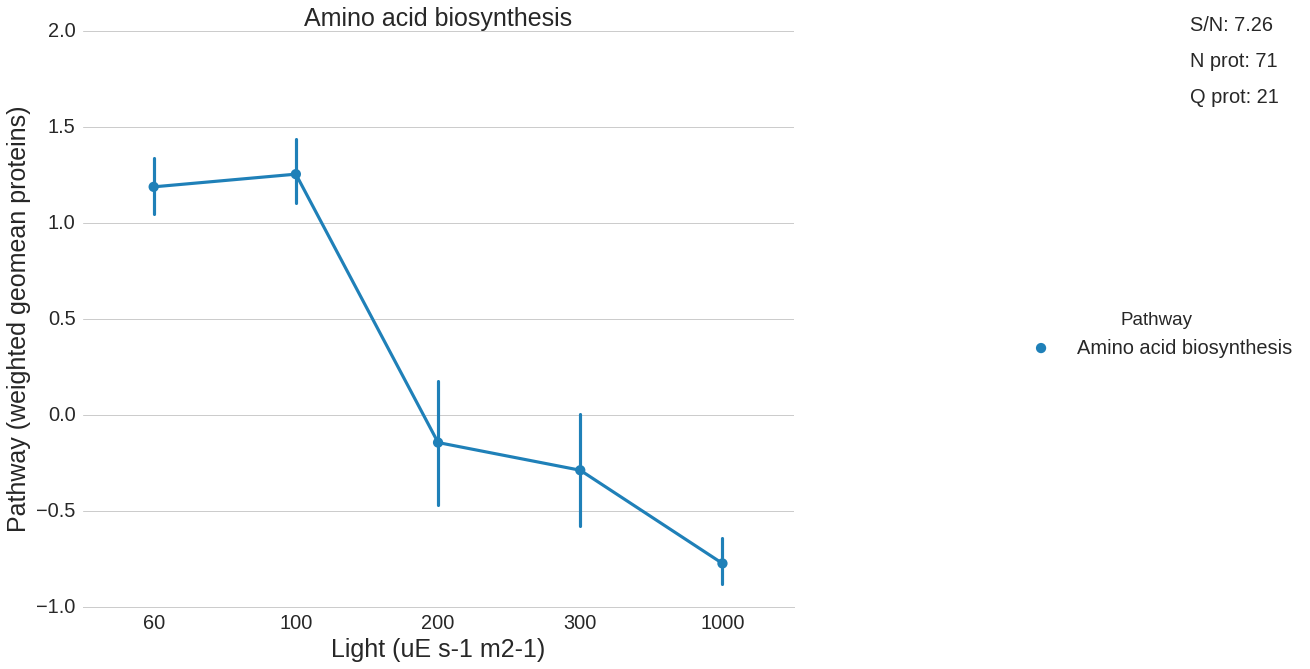

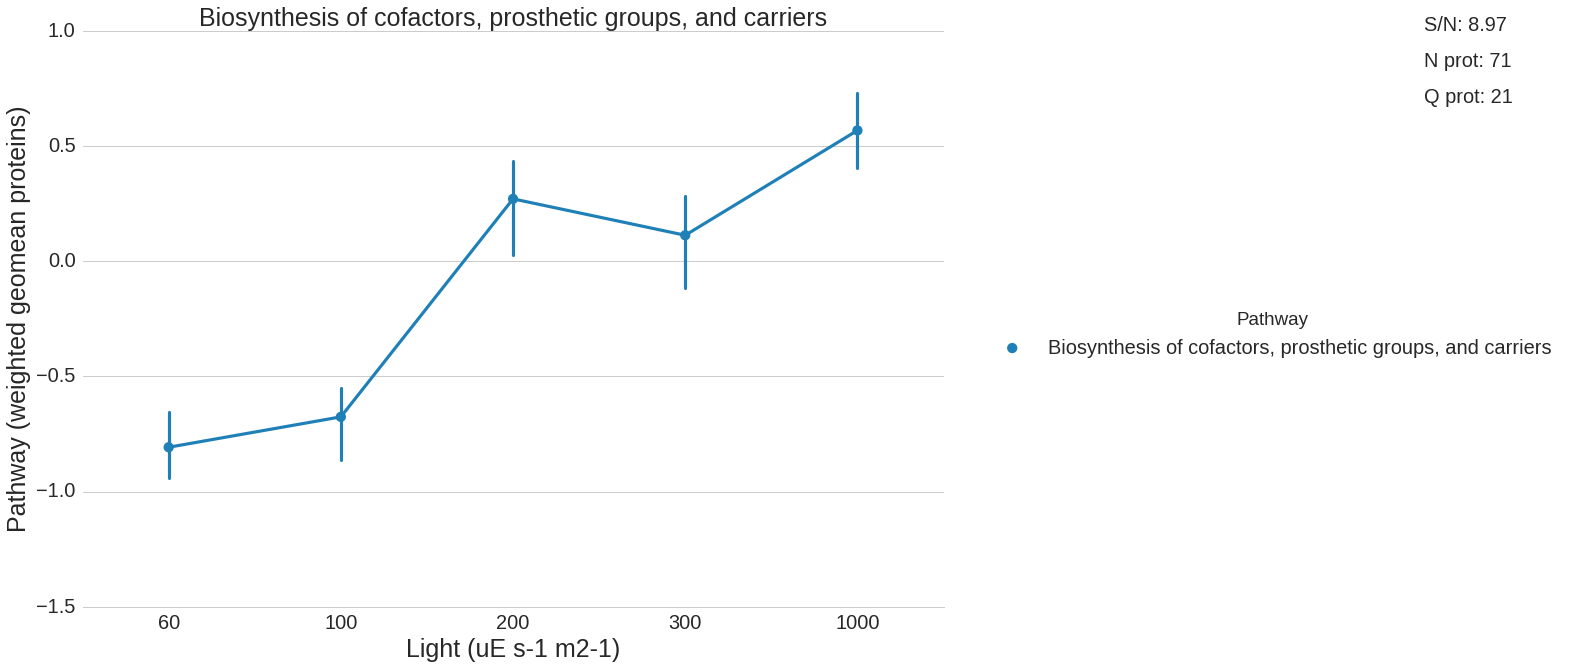

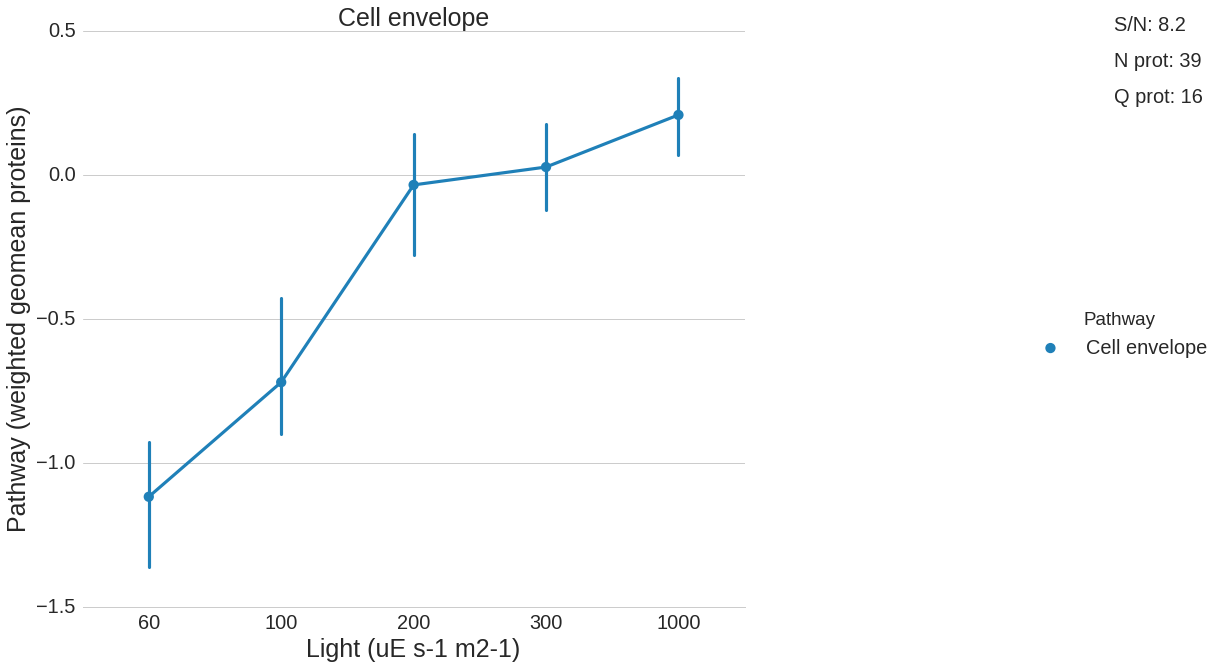

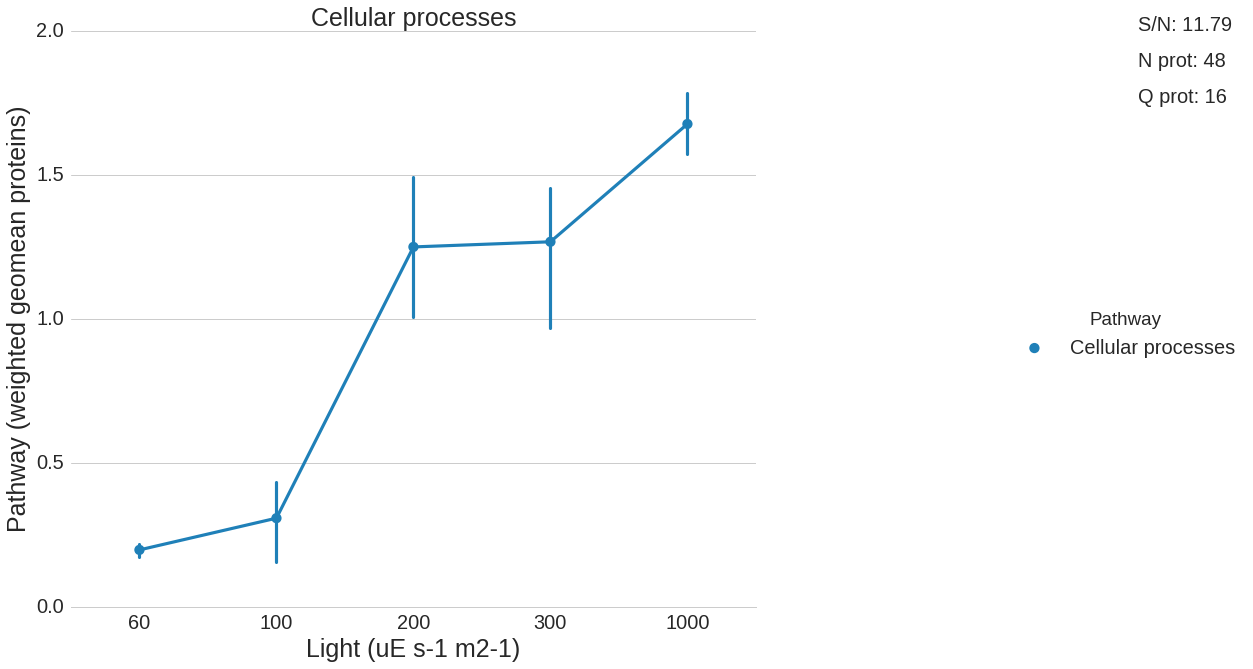

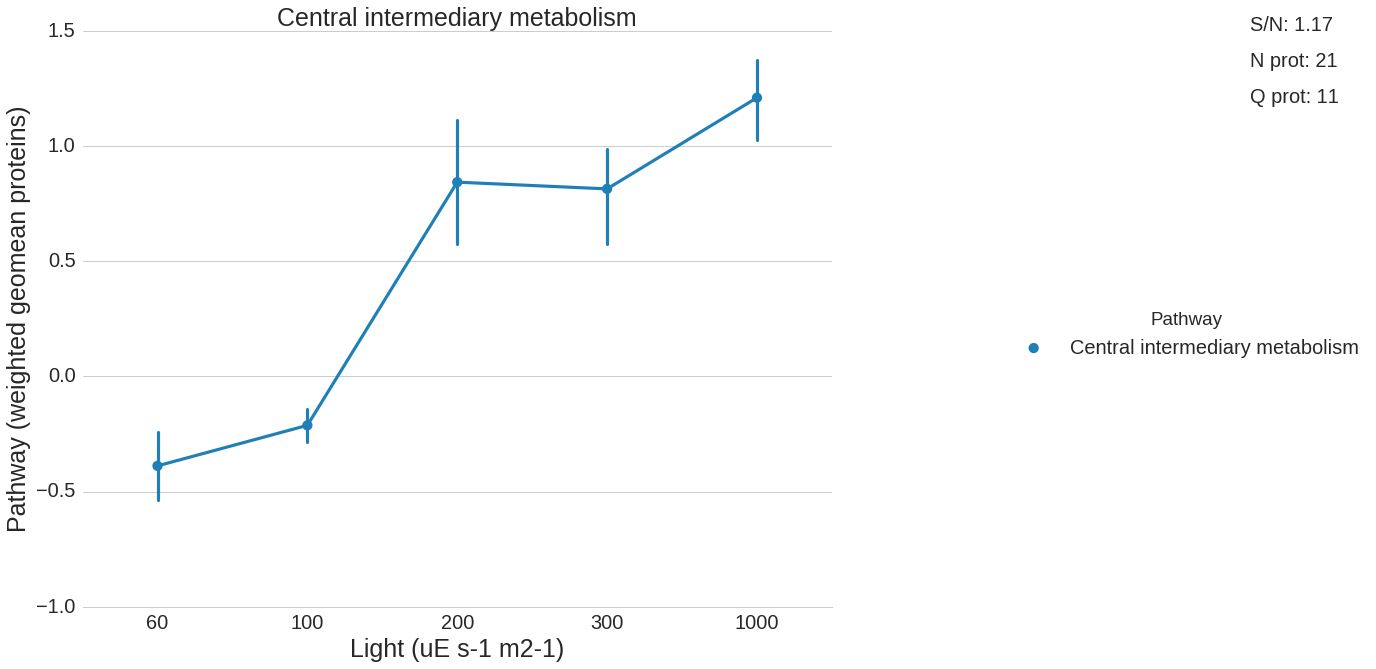

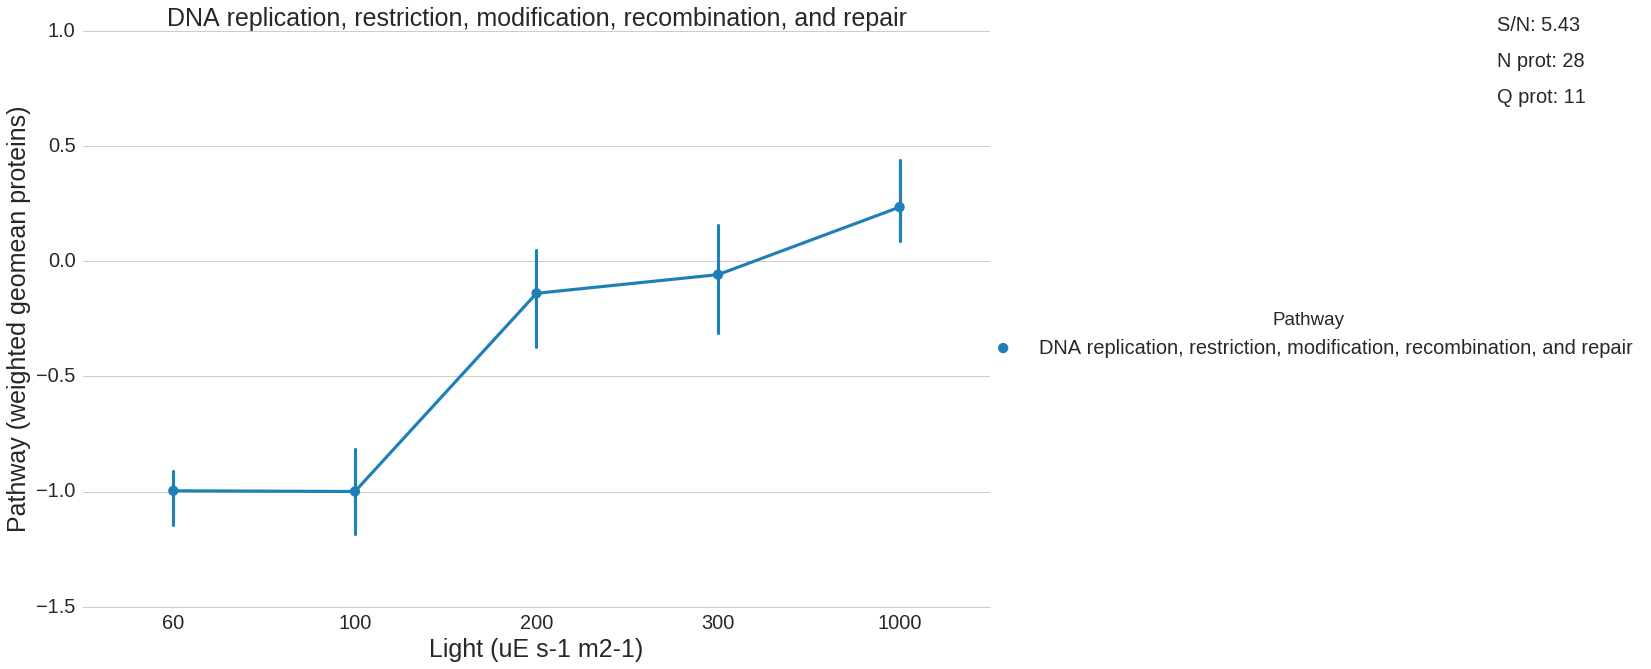

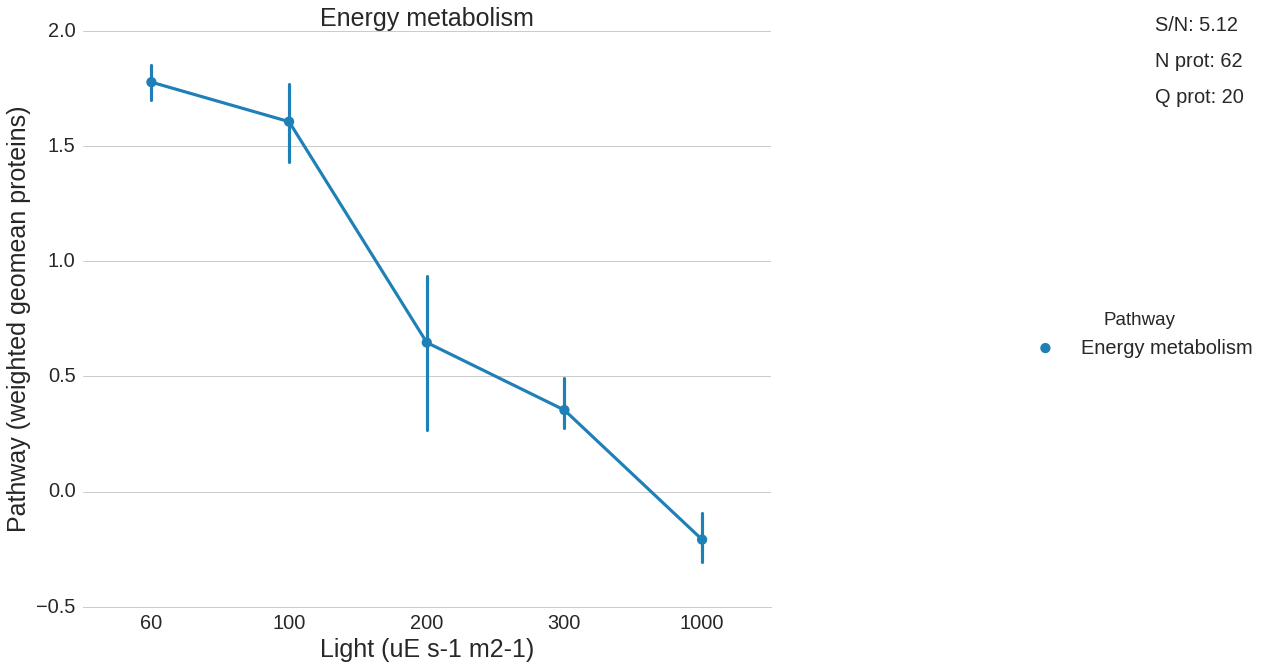

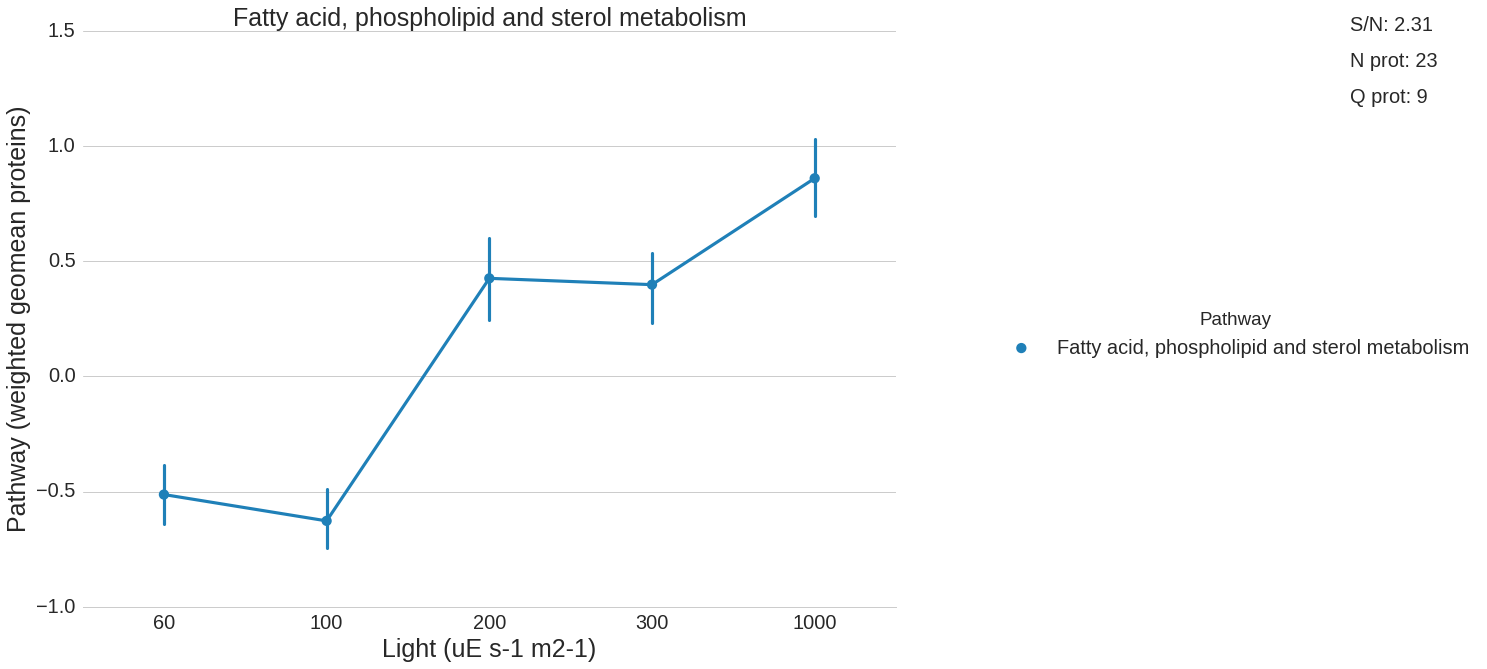

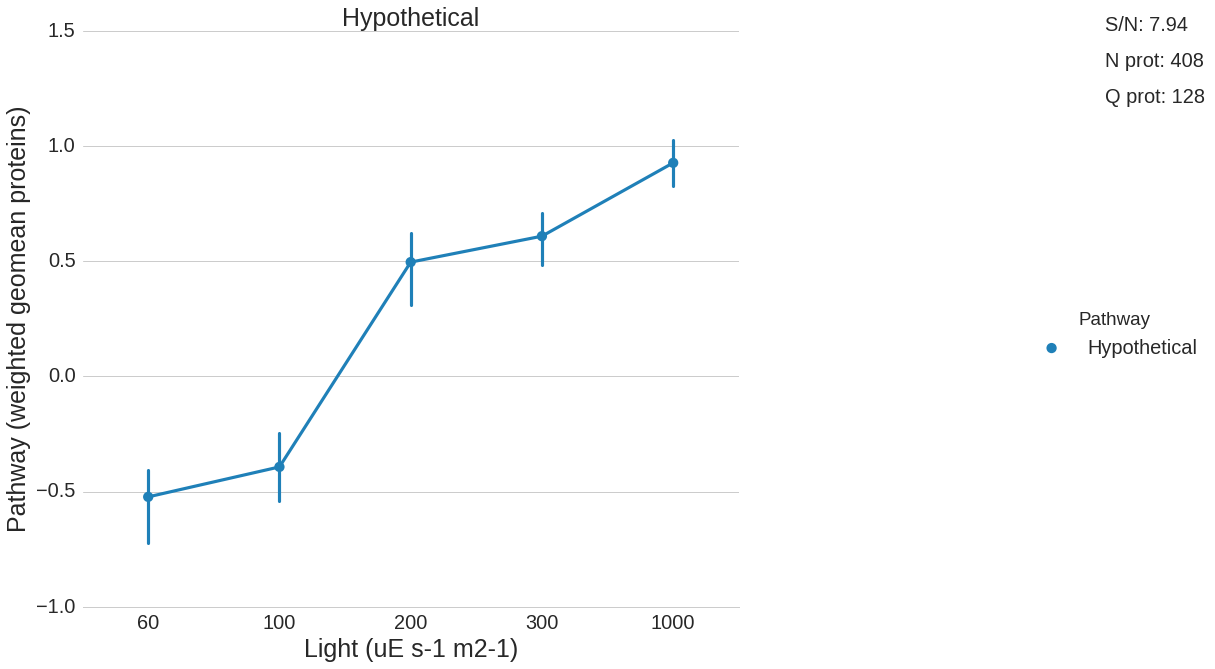

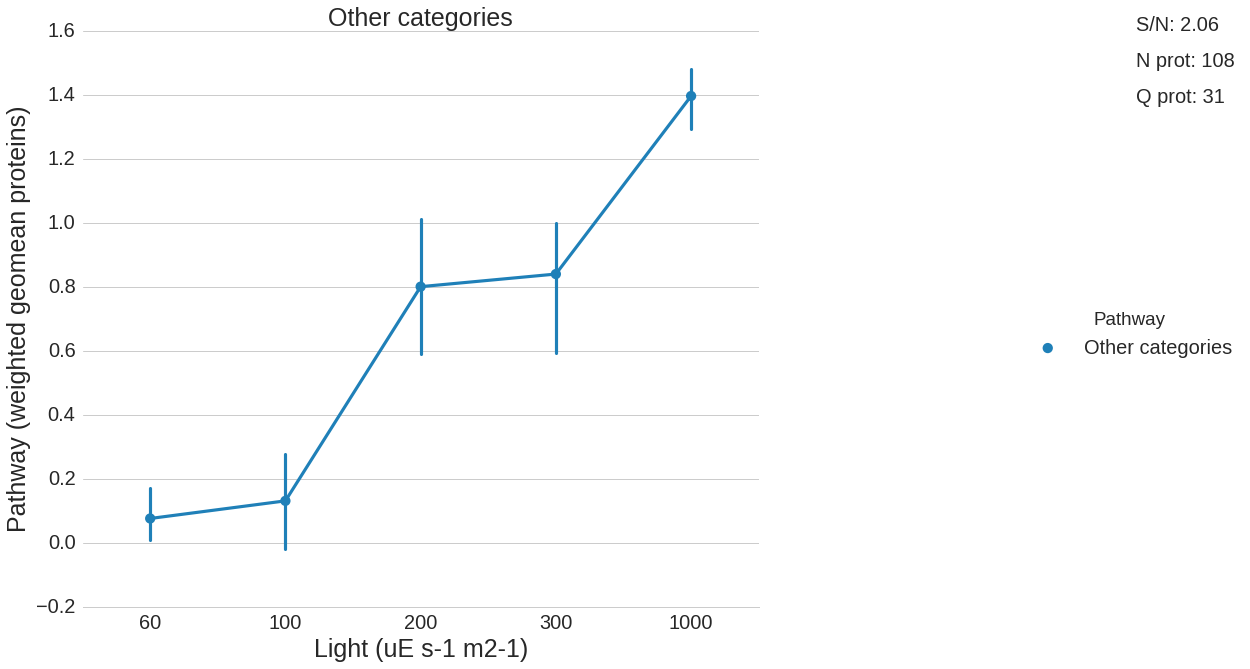

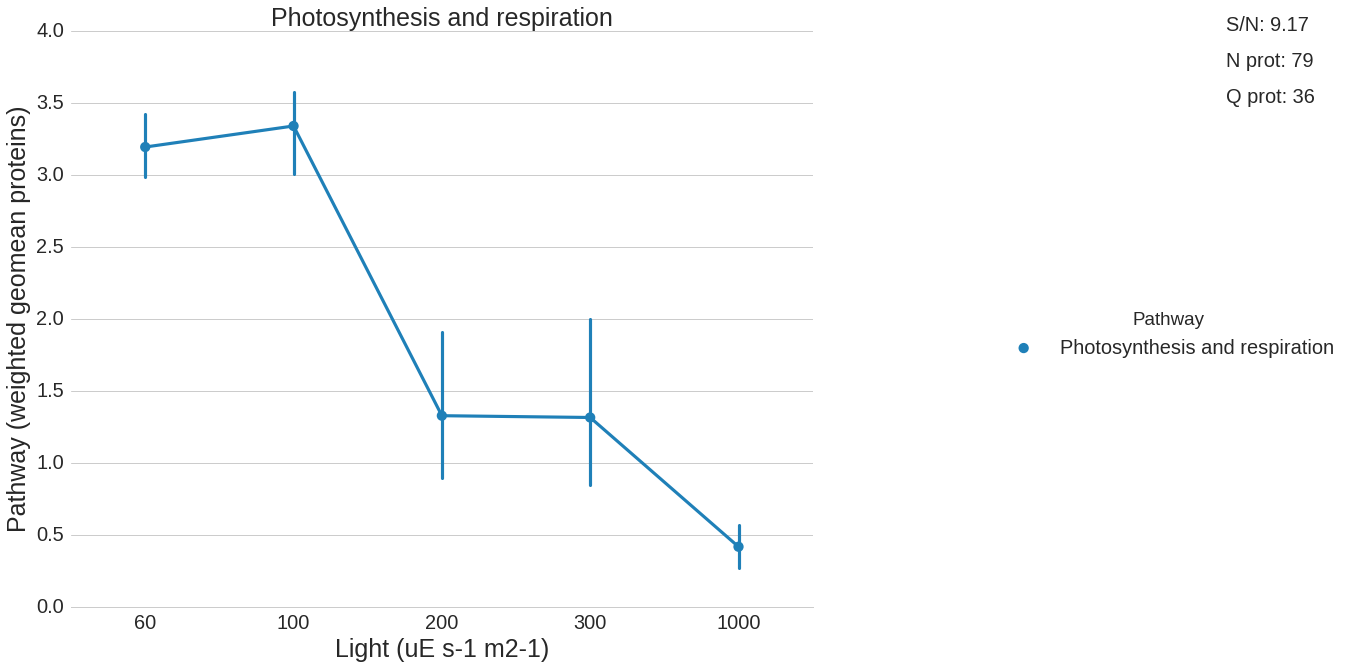

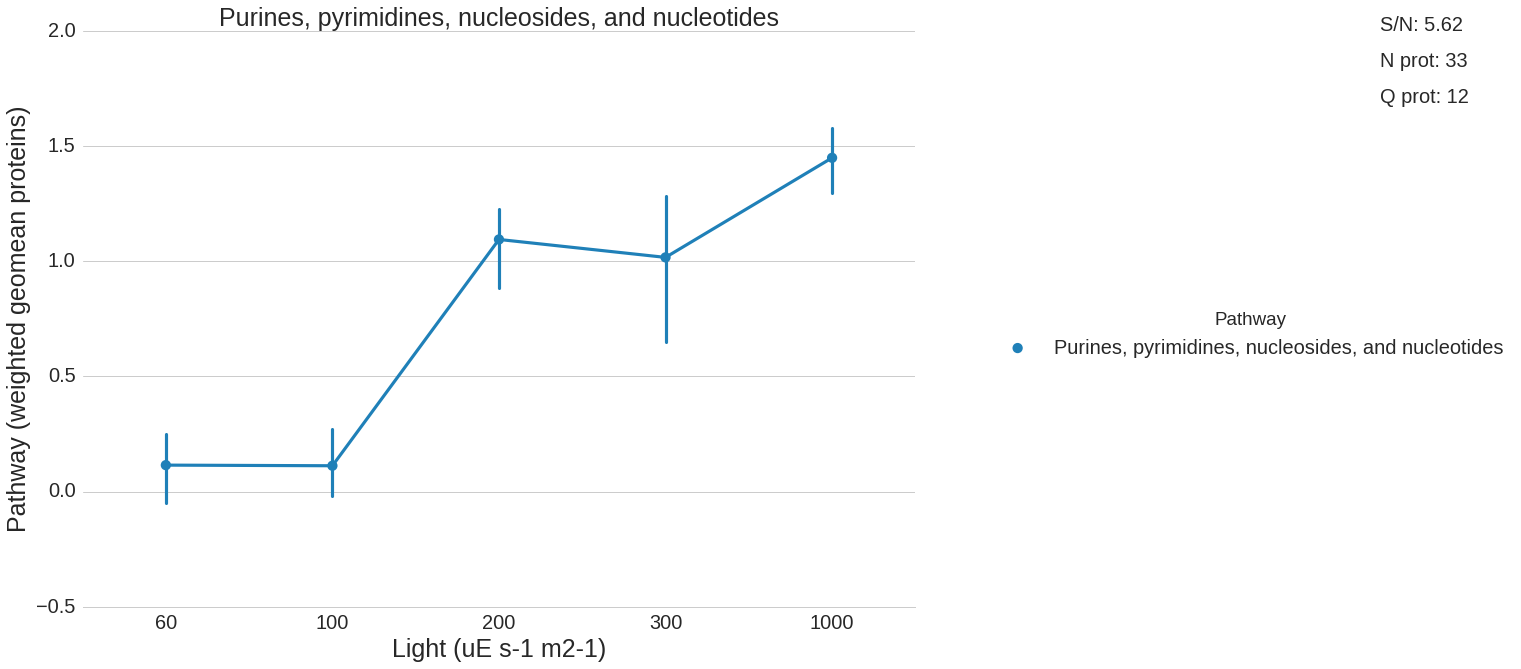

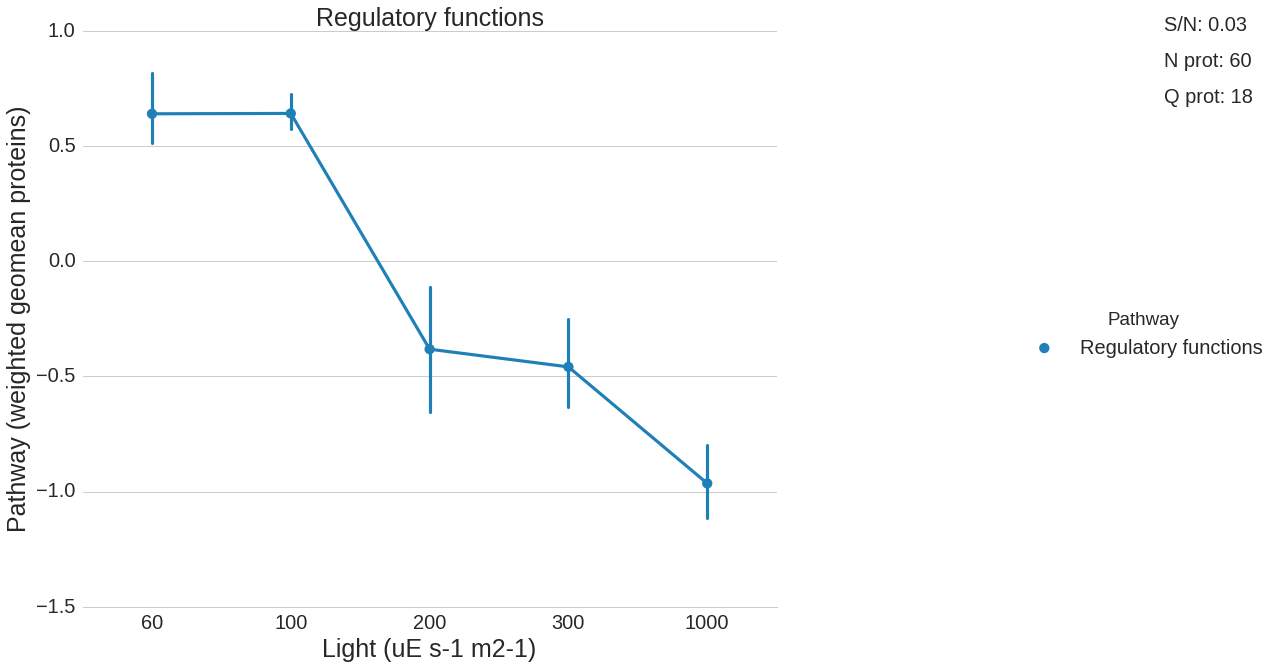

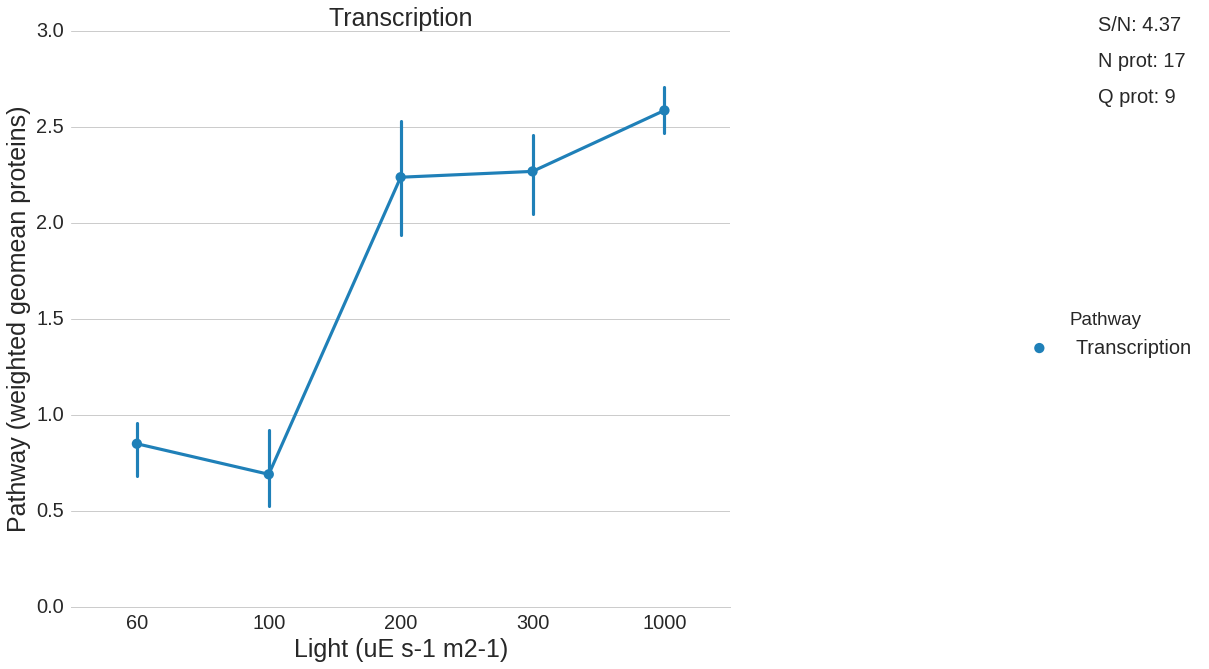

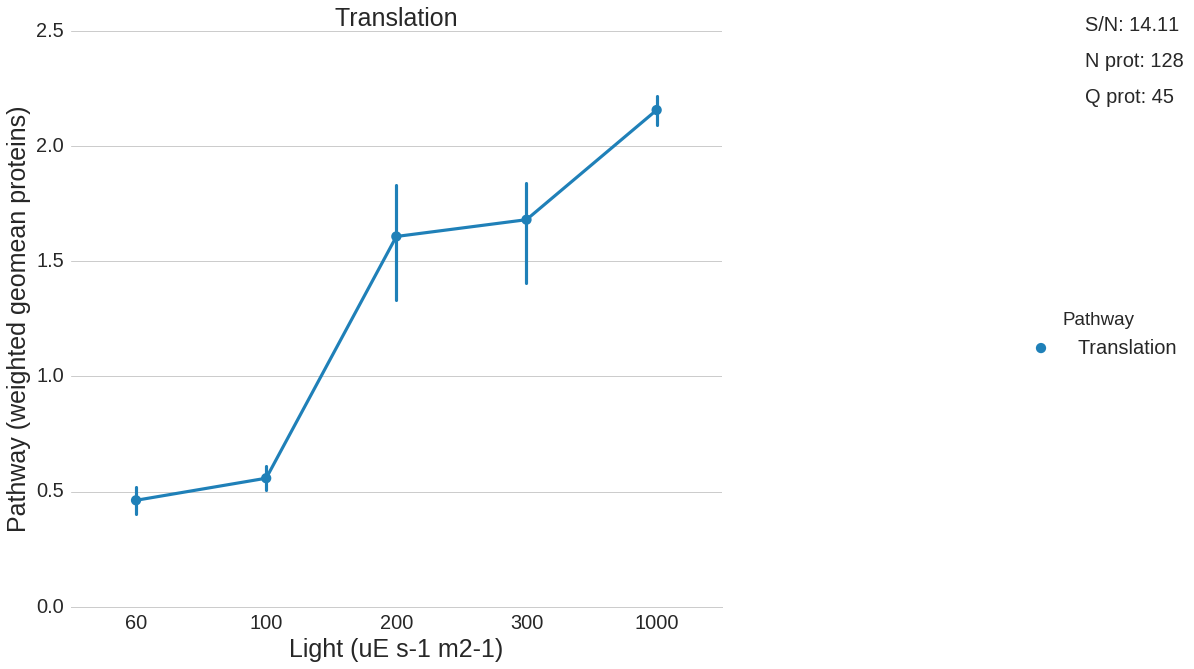

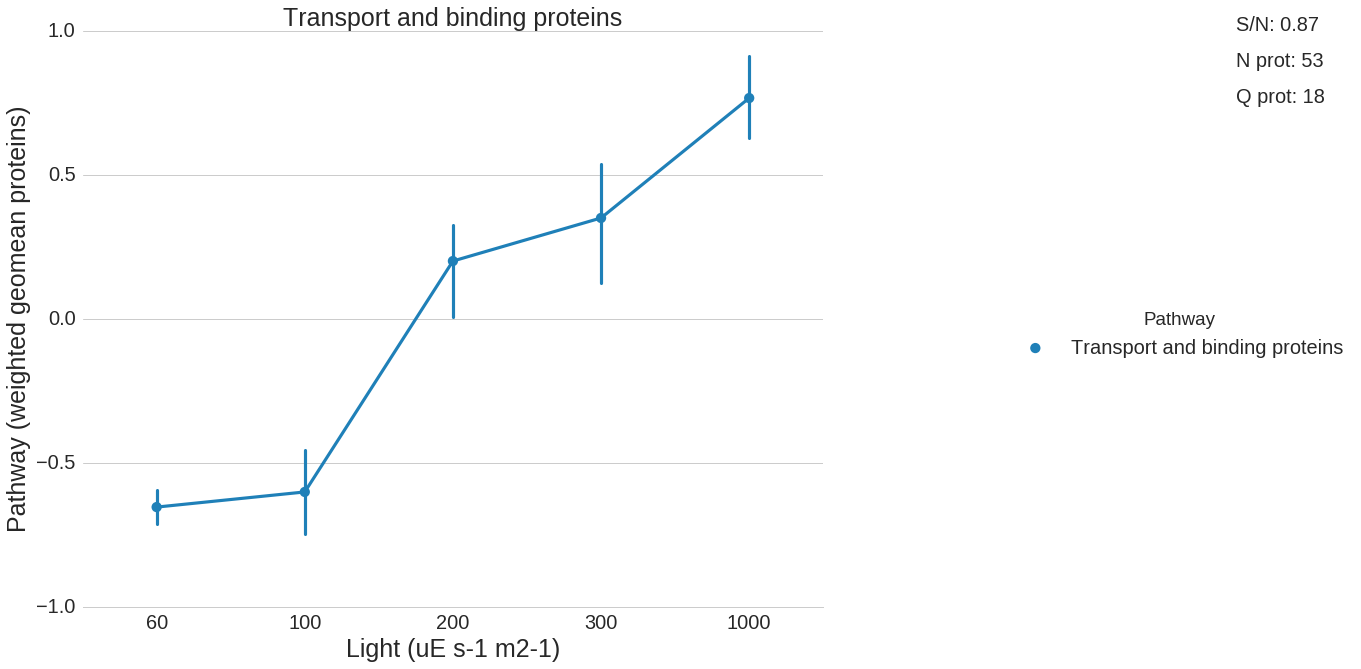

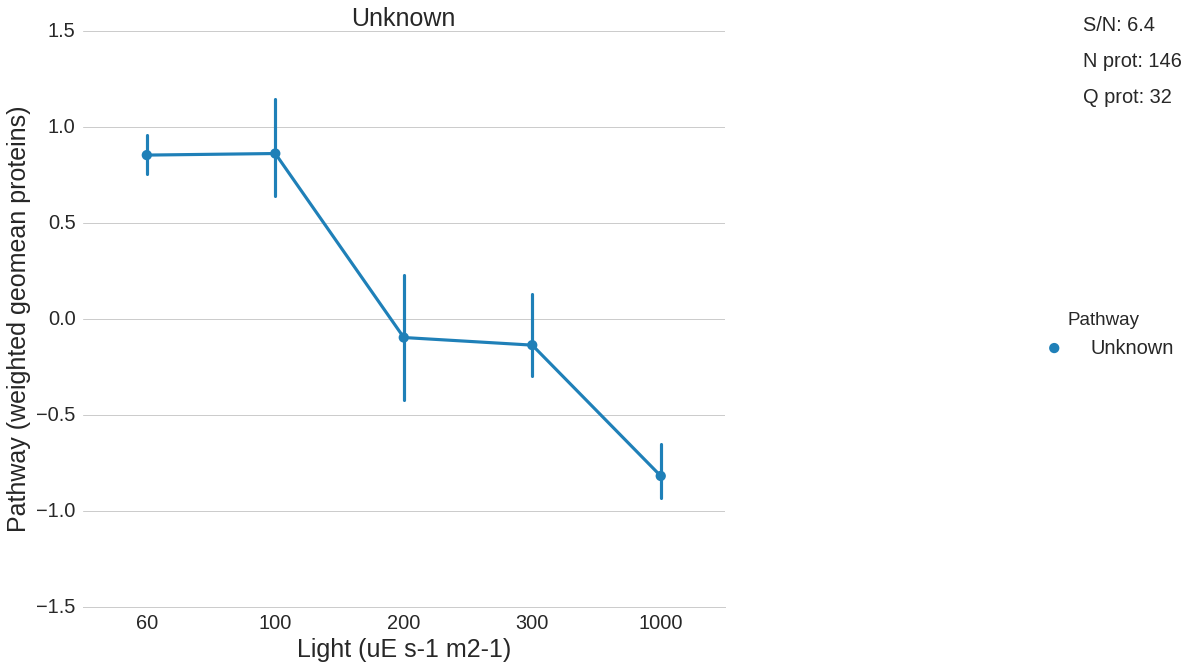

In [9]:
batch_sb_factorplot(pathways_df=data)


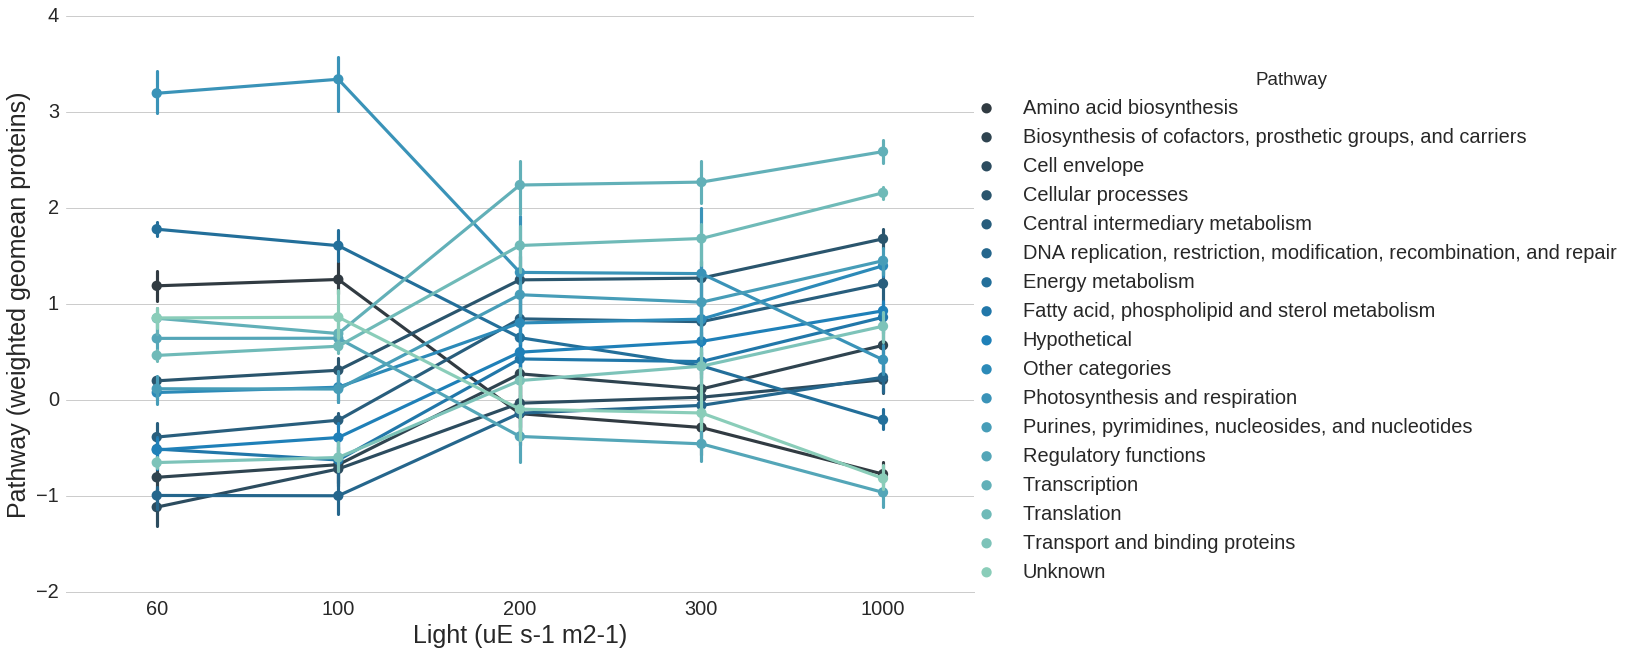

In [10]:
# OR Plot all pathways together using the concatenated sb_data:
sb_dfs = list()
for i in range(len(data)):
	sb_df = pd.DataFrame()
	cols = [c for c in data.columns if "_" in c]
	sb_df['Intensity'] = data.ix[i][cols]
	lights = [l.split("_")[0] for l in sb_df.index]
	sb_df['Light'] = lights
	sb_df['Pathway'] = data.loc[i, 'Pathway']
	sb_dfs.append(sb_df)
sb_data = pd.concat(sb_dfs)
sb_factorplot(data=sb_data)

In [11]:
#Estimate r2 for each pathway 
#(Correlation of GrowthRate(Light) VS Pathway(Intensity from geomean weighted proteins)  )

#light => growth_rate
#60 => 0.0331
#100 => 0.0485
#200 => 0.0639
#300 => 0.0934
#1000 => 0.0961

u = [0.0331, 0.0485, 0.0639, 0.0934, 0.0961]
num_sampl, num_repl = 5,4
samples_r = np.array(samples).reshape(num_sampl,num_repl)


In [12]:
def add_r2(data):
	for i, r in data.iterrows():
		for s in samples_r:
			s_mean_col_name = s[0].split("_")[0] + "_mean"
			data.loc[i, s_mean_col_name] = data.loc[i,s].mean()
		means = [c for c in data.columns if "_mean" in c]
		slope, intercept, r_value, p_value, std_err = stats.linregress(data.loc[i, means].tolist(),u)
		data.loc[i, 'r2'] = r_value**2

In [13]:
#HCL to order columns in corrmat so correlated pathways will be together
def reorder(corrmat):
	D = dist.pdist(corrmat, metric='cos') #Pairwise distances between observations in n-dimensional space.
	D = dist.squareform(D)
	Y = sch.linkage(D, method='complete', metric='cos') #Performs hierarchical/agglomerative clustering.
	Z1 = sch.dendrogram(Y, orientation='left', no_plot=True)
	#reorder columns:
	corrmat = corrmat[Z1['leaves']]
	corrmat = corrmat.reindex(Z1['leaves'])
	return corrmat


In [14]:
def corr_mat(pathways_df, hcl=True, tickLabels=True):

	add_r2(pathways_df)
	means = [c for c in pathways_df.columns if "_mean" in c]
	corrmat = pathways_df[means].T.corr()
	col_ix = corrmat.index
	if hcl:
		corrmat = reorder(corrmat)
		col_ix = corrmat.index
		corrmat.index = pathways_df.ix[corrmat.index].Pathway.tolist()
		corrmat.columns = corrmat.index
	else:
		corrmat.index = pathways_df.Pathway.tolist()
		corrmat.columns = pathways_df.Pathway.tolist()
	# Generate a mask for the upper triangle
	mask = np.zeros_like(corrmat, dtype=np.bool)
	mask[np.triu_indices_from(mask)] = True
	# Generate a custom diverging colormap
	cmap = sb.diverging_palette(220, 10, as_cmap=True)
	# Set up the matplotlib figure
	f, ax = plt.subplots(figsize=(22, 16))
	h = sb.heatmap(corrmat, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)#, vmax=.8, square=True)
	if tickLabels:
		h.set_yticklabels(h.get_yticklabels(), rotation=0, fontsize=11)
		h.set_xticklabels(h.get_xticklabels(), rotation=90, fontsize=11)
	else:
		h.set_yticklabels(col_ix+1, rotation=0, fontsize=12)
		h.set_xticklabels(col_ix+1, rotation=90, fontsize=12)
		y=np.linspace(0.9,0.4,len(pathways_df))
		for k, v in dict(zip(col_ix+1, corrmat.index)).iteritems():
			plt.text(0.85, y[k-1], "%s: %s"%(k,v), fontsize=11, transform=plt.gcf().transFigure)
	plt.subplots_adjust(bottom=0.38) #for ipython matplotlib, not needed for notebook
	plt.show()


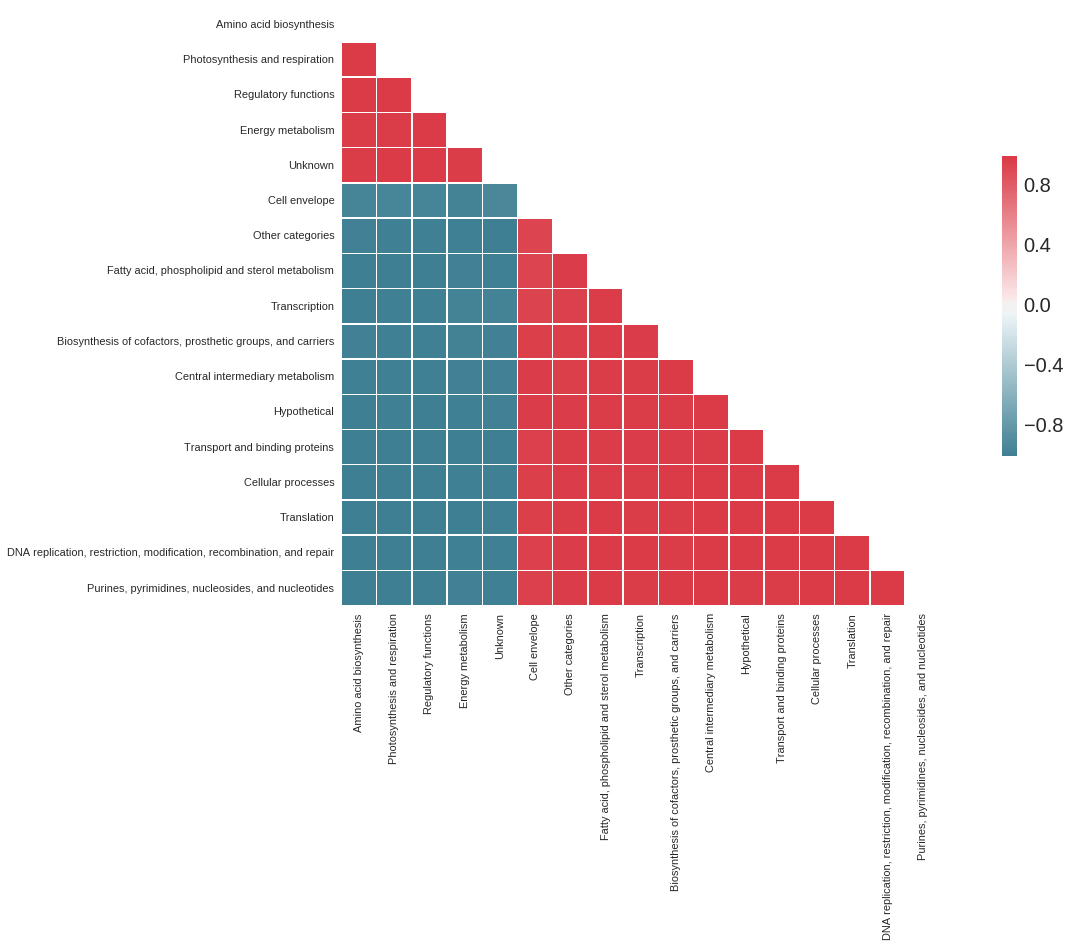

In [15]:
data = pd.read_csv("/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways.csv", sep="\t")
corr_mat(pathways_df=data, hcl=True, tickLabels=True)
#corr_mat(pathways_df=data, hcl=True, tickLabels=False)
#corr_mat(pathways_df=data, hcl=False, tickLabels=True)
#corr_mat(pathways_df=data, hcl=False, tickLabels=False)

## 2nd Category Level Annotations

In [16]:
pg = pathway_grouping(df, pathways_file, category_level='second') 
print("Number of pathways: %d" % len(pg.keys()))

Number of pathways: 68


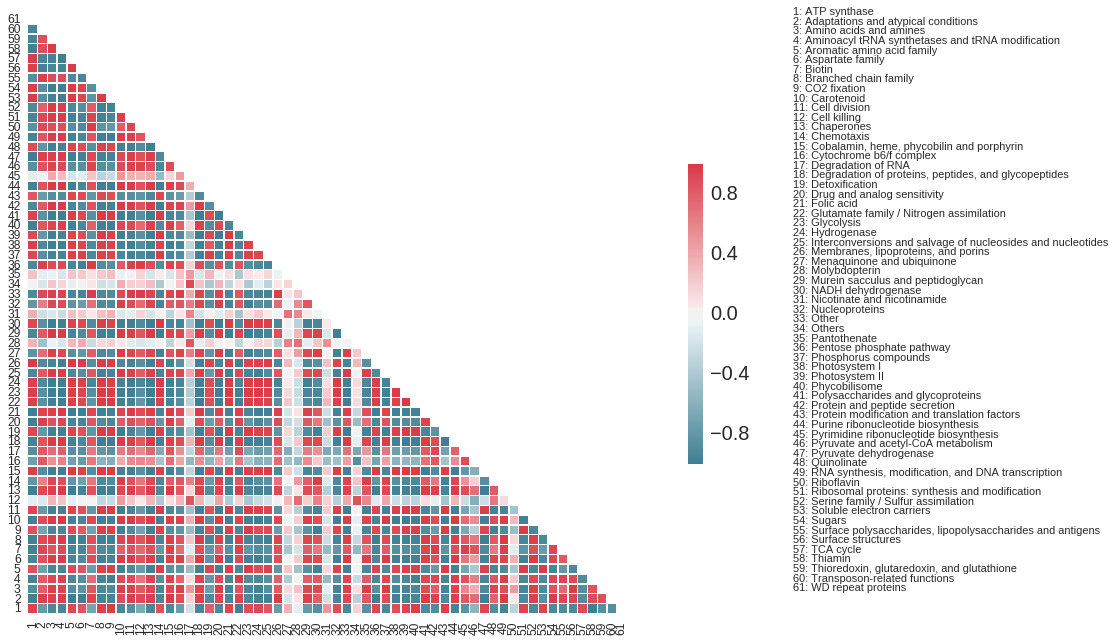

In [17]:
data = pd.read_csv("/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways_second_category.csv", sep="\t")
corr_mat(pathways_df=data, hcl=False, tickLabels=False)

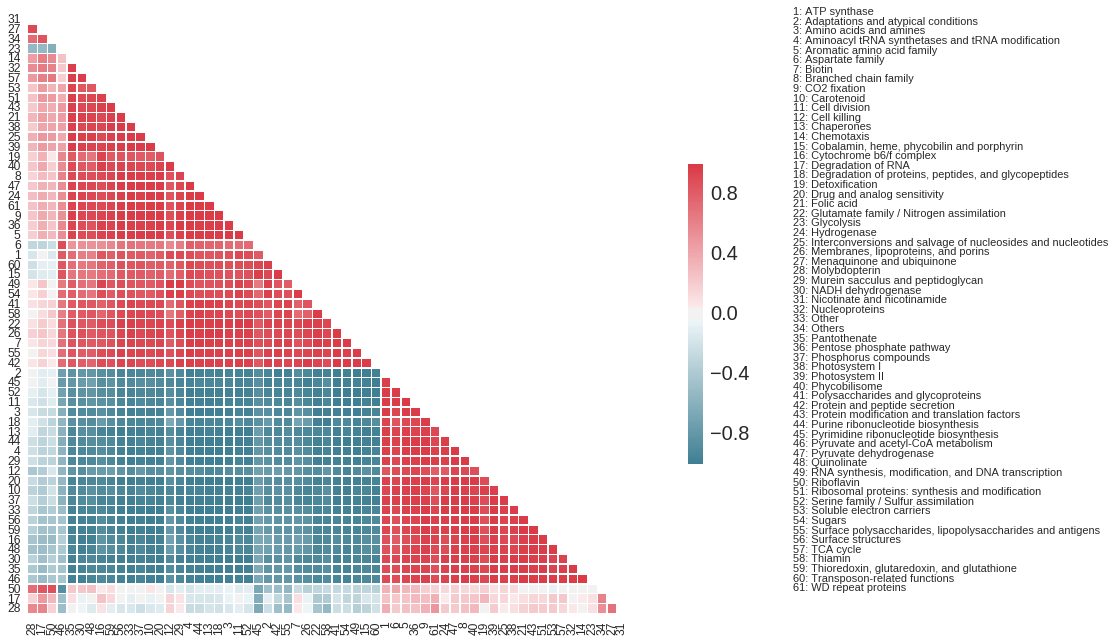

In [21]:
corr_mat(pathways_df=data, hcl=True, tickLabels=False)

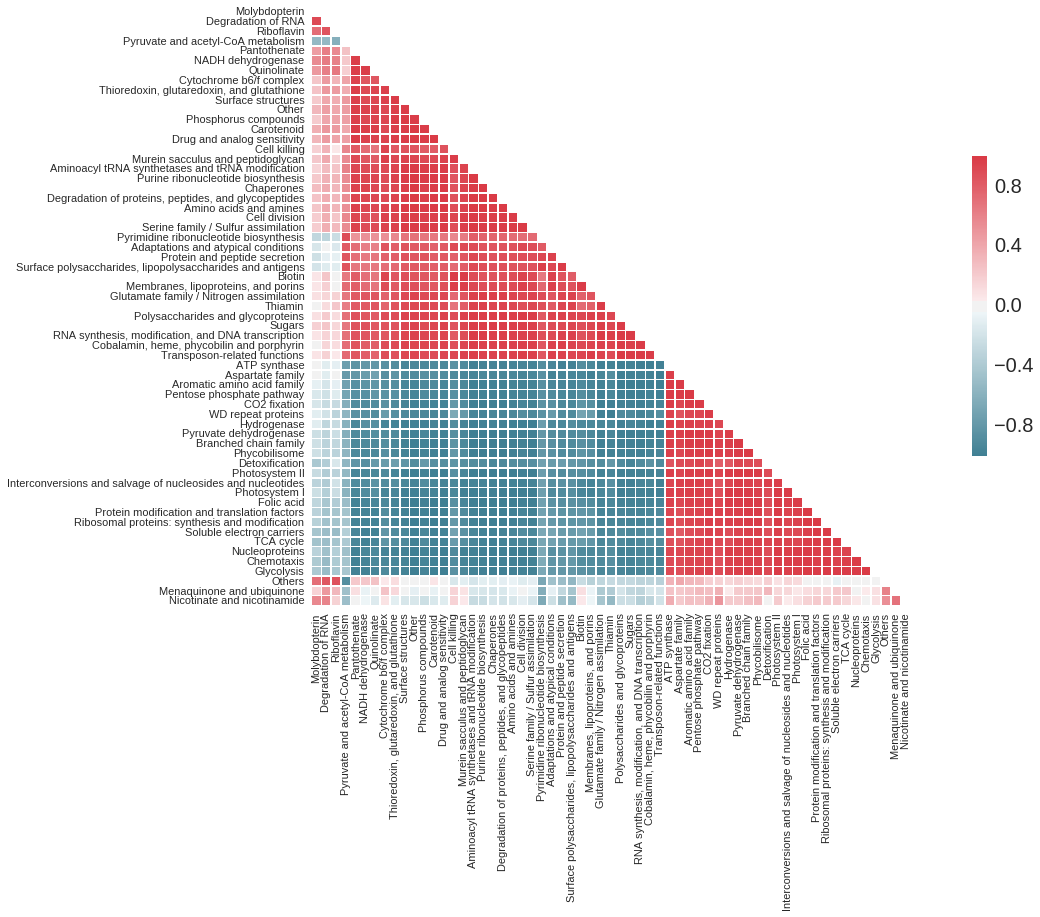

In [22]:
corr_mat(pathways_df=data, hcl=True, tickLabels=True)

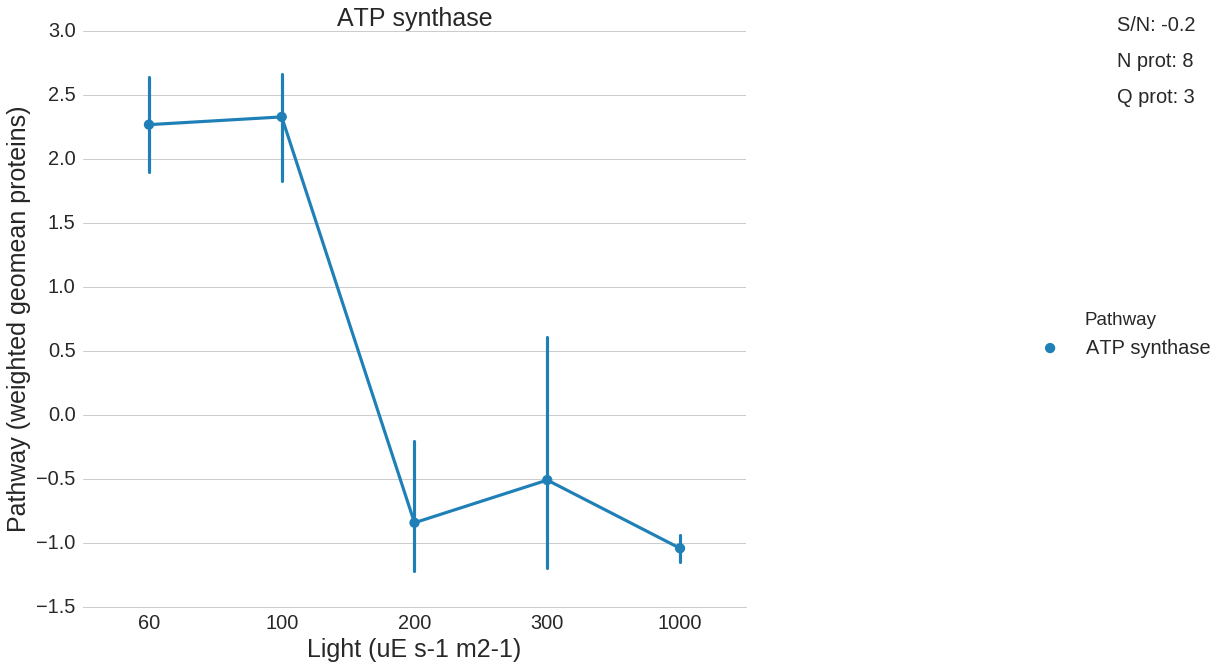

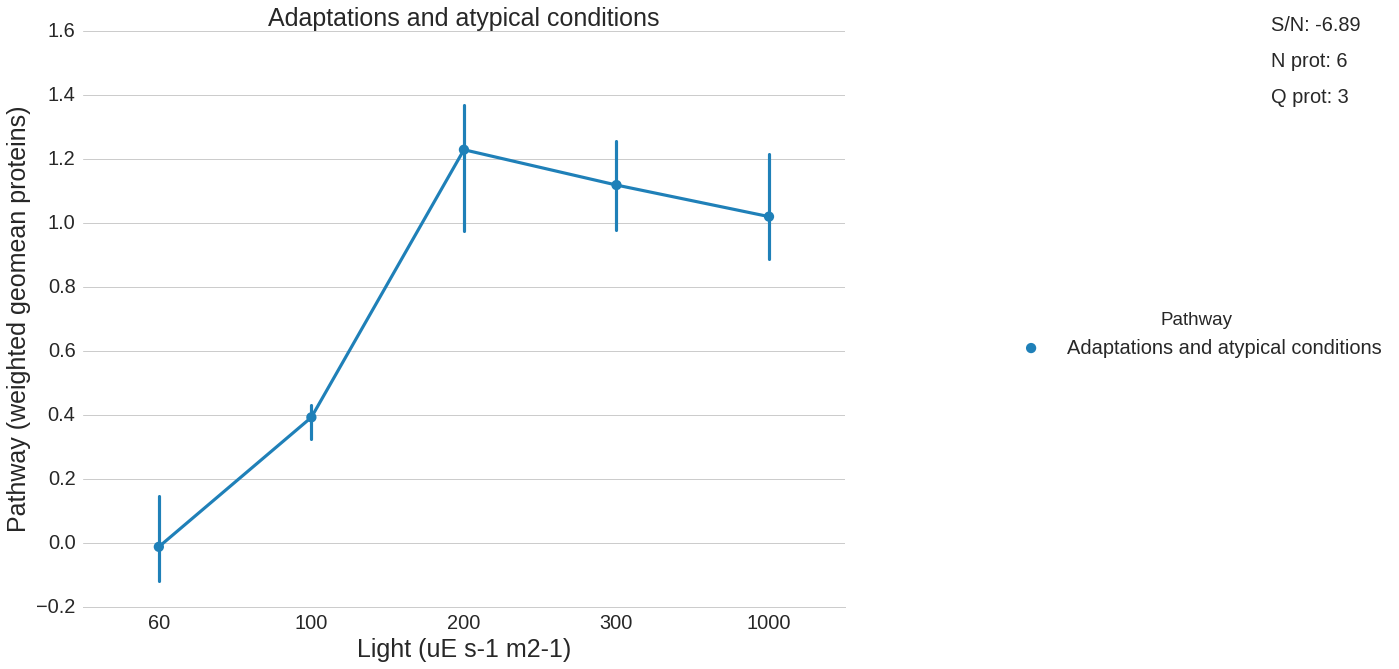

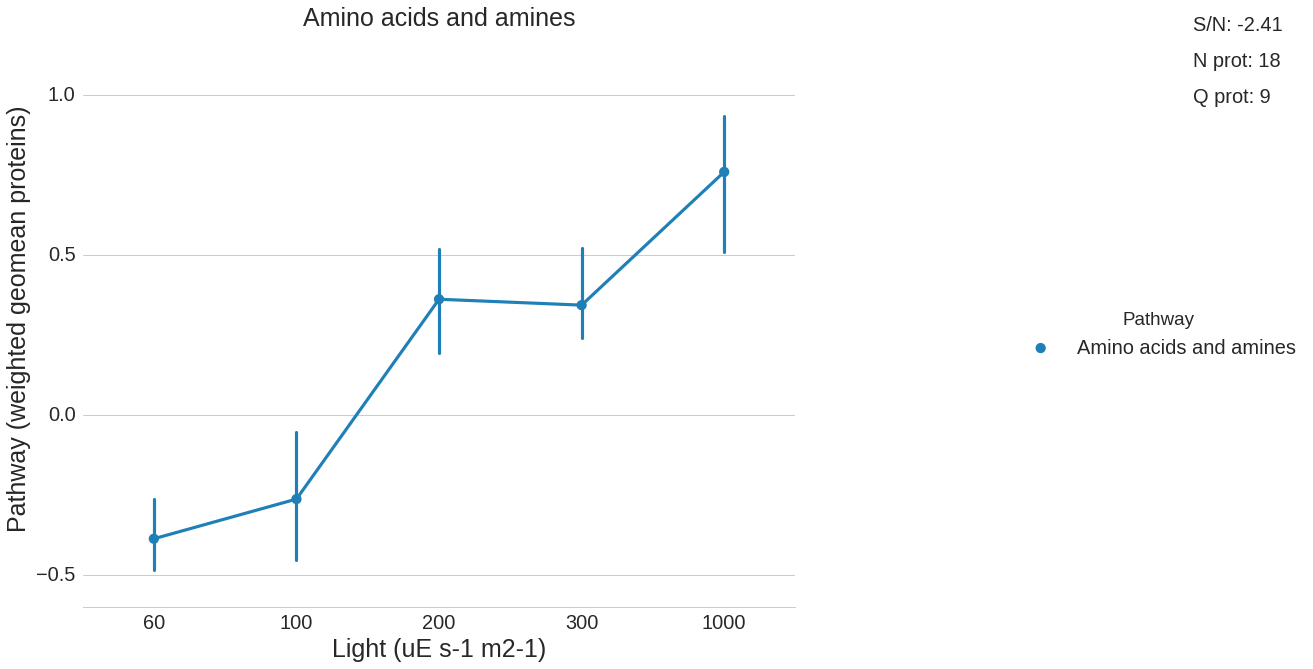

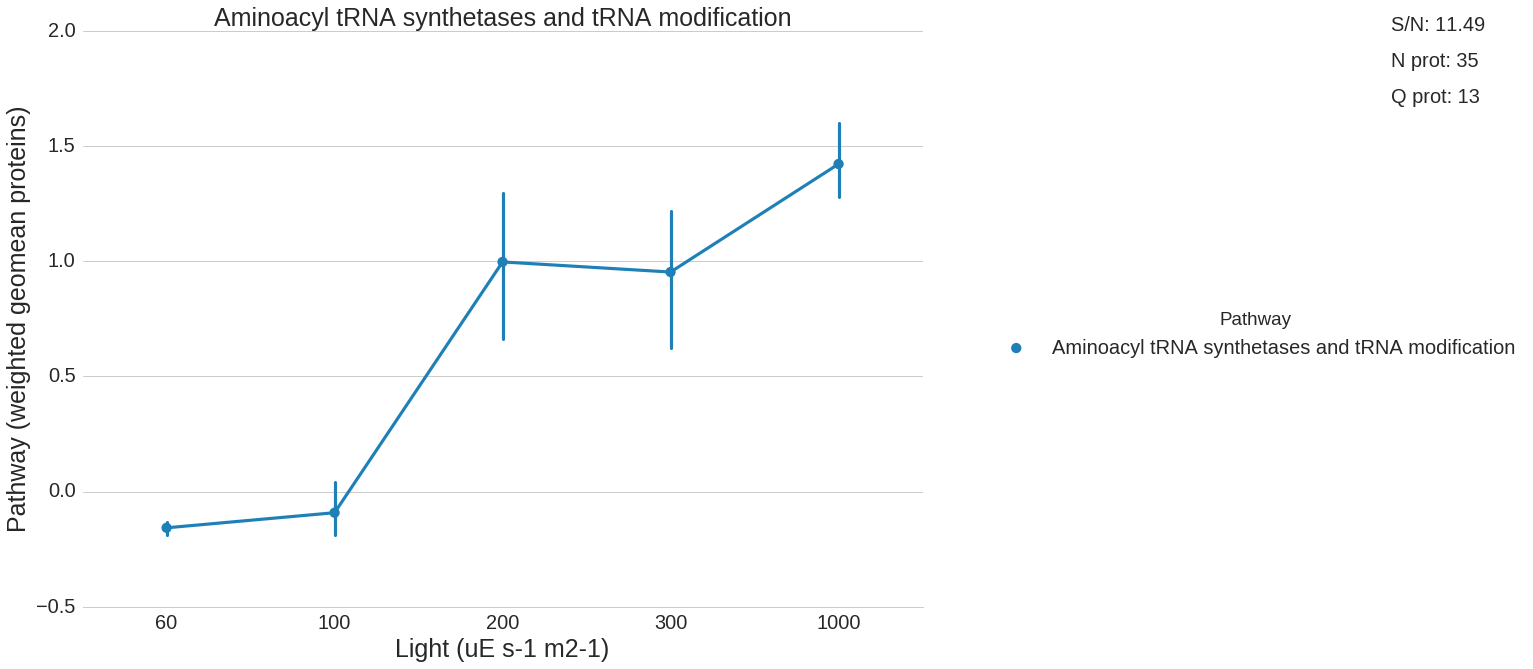

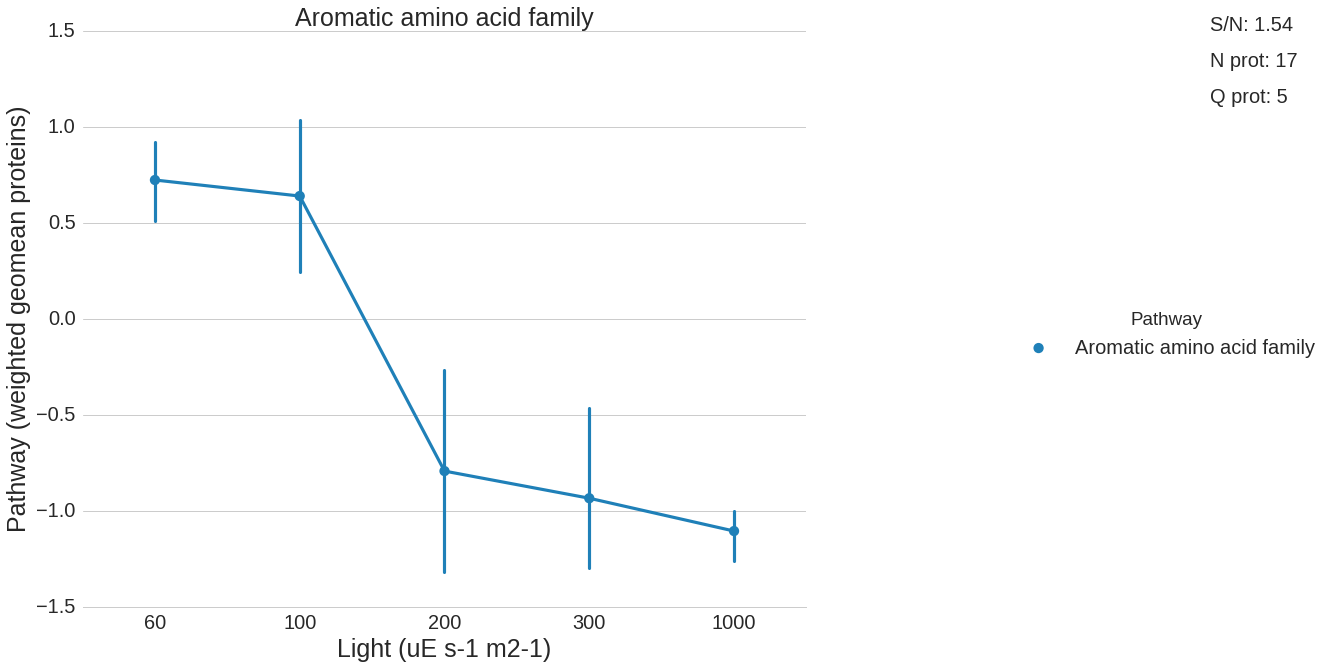

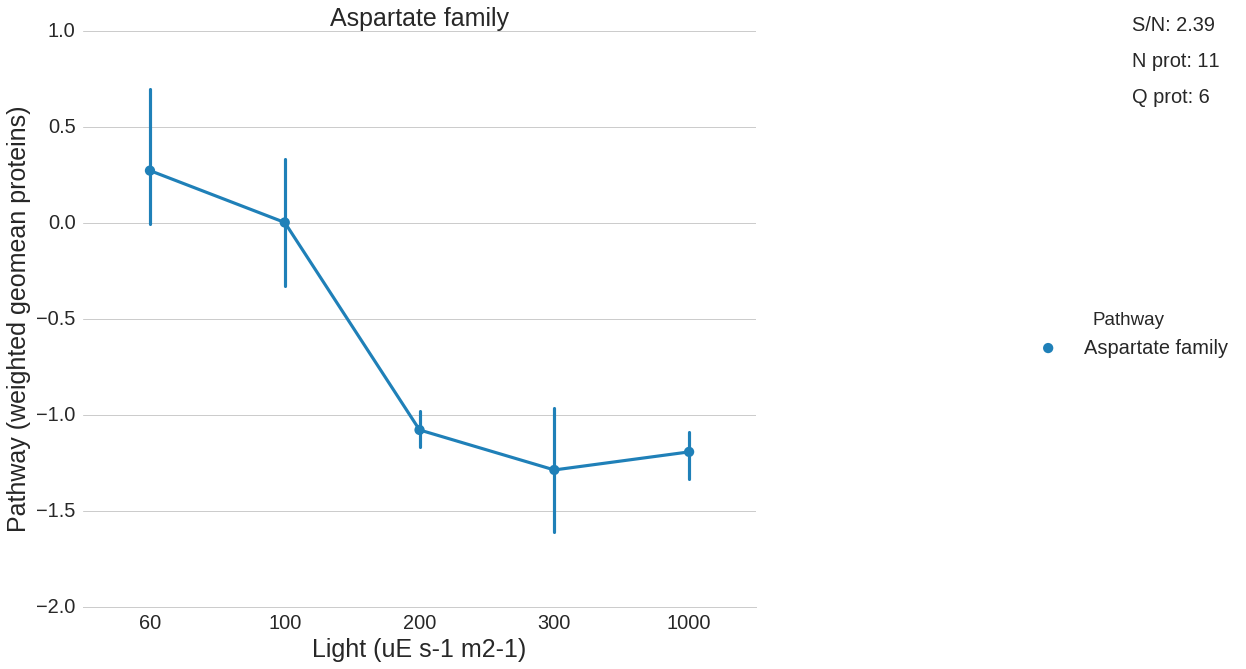

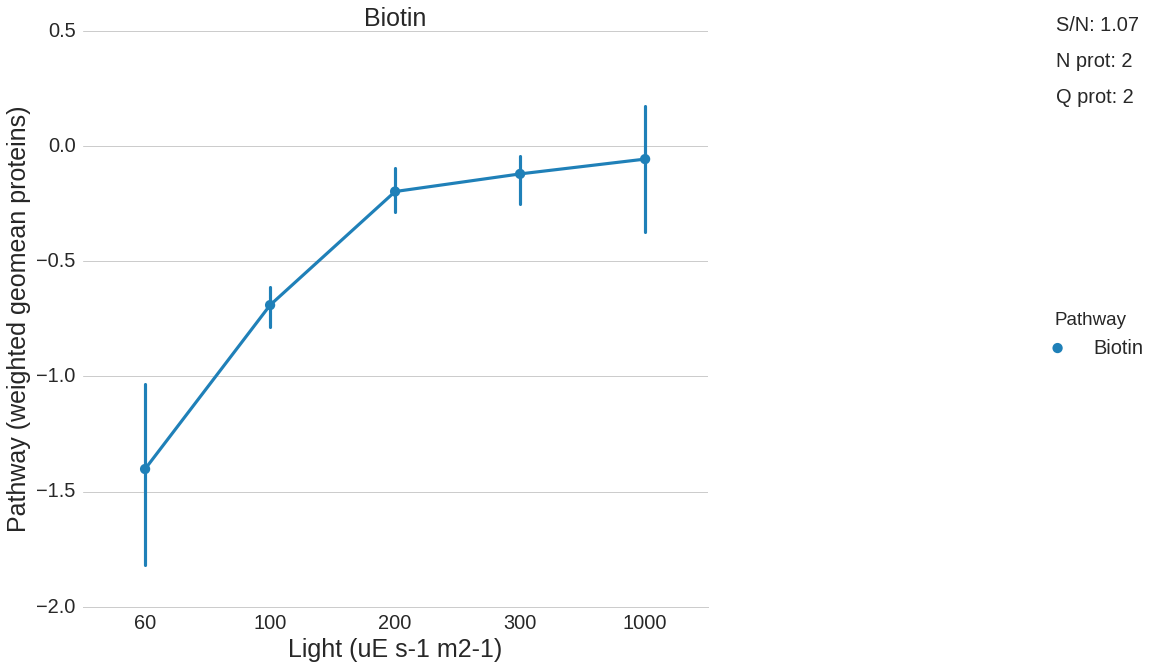

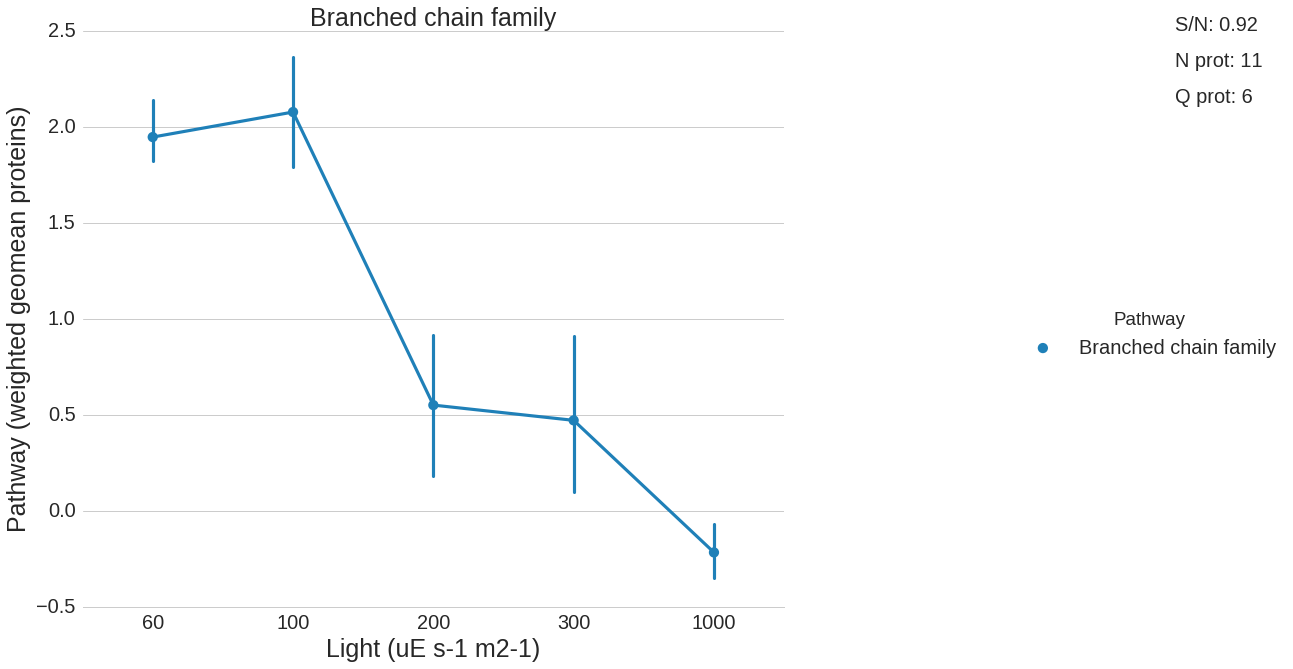

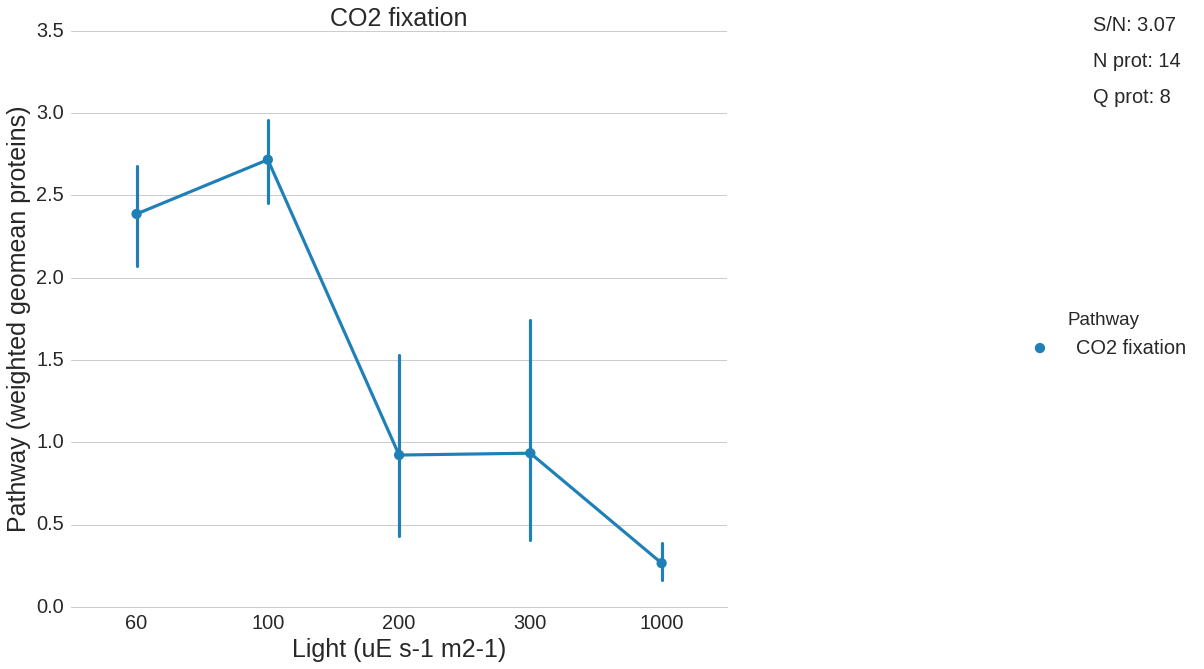

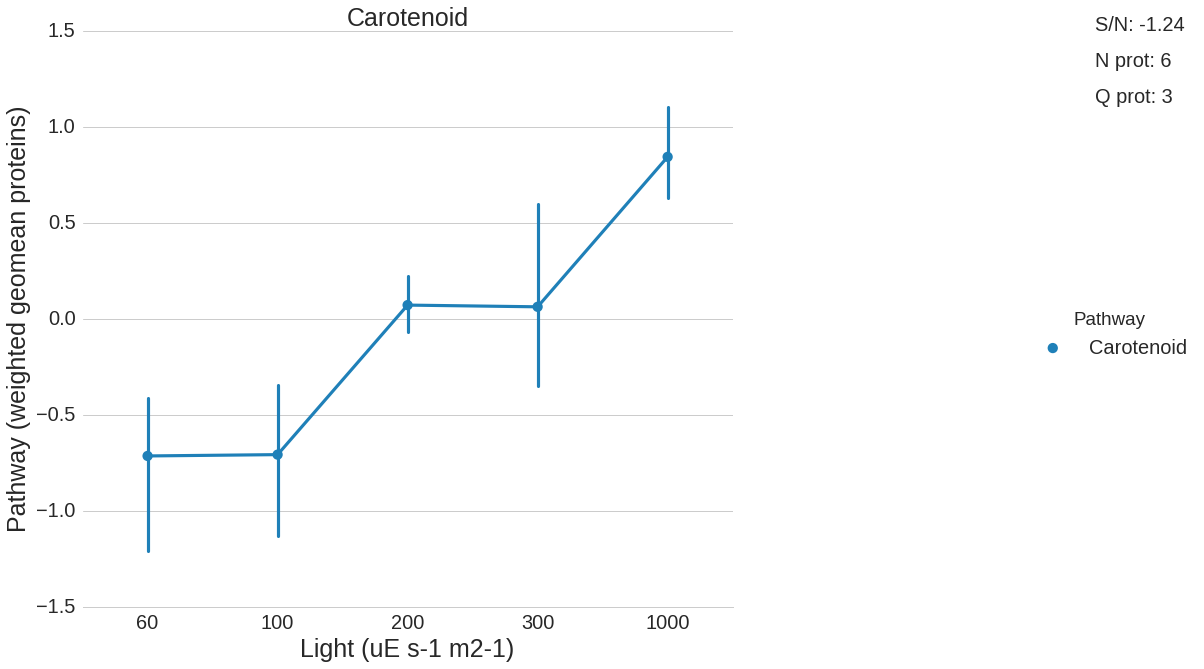

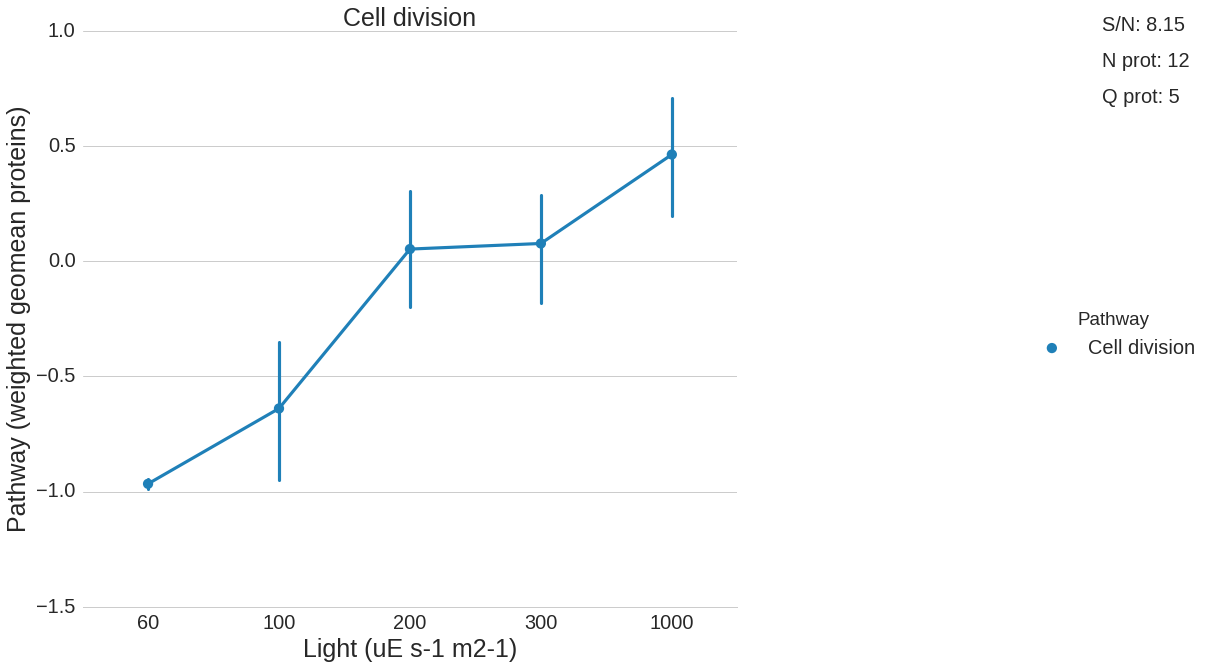

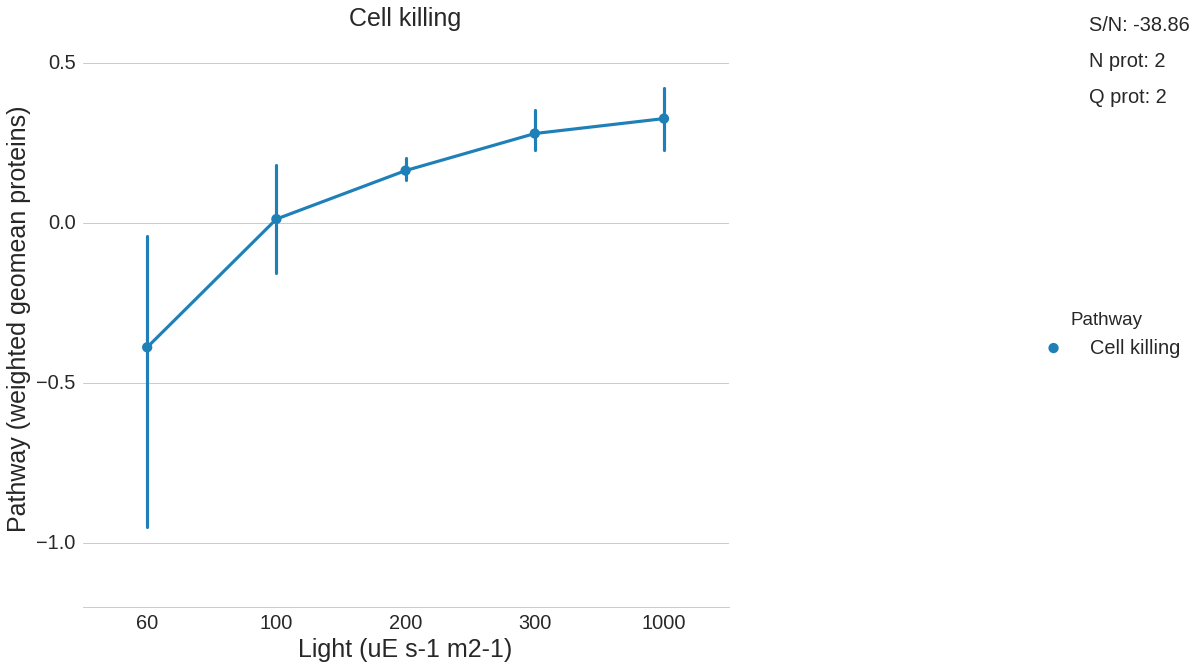

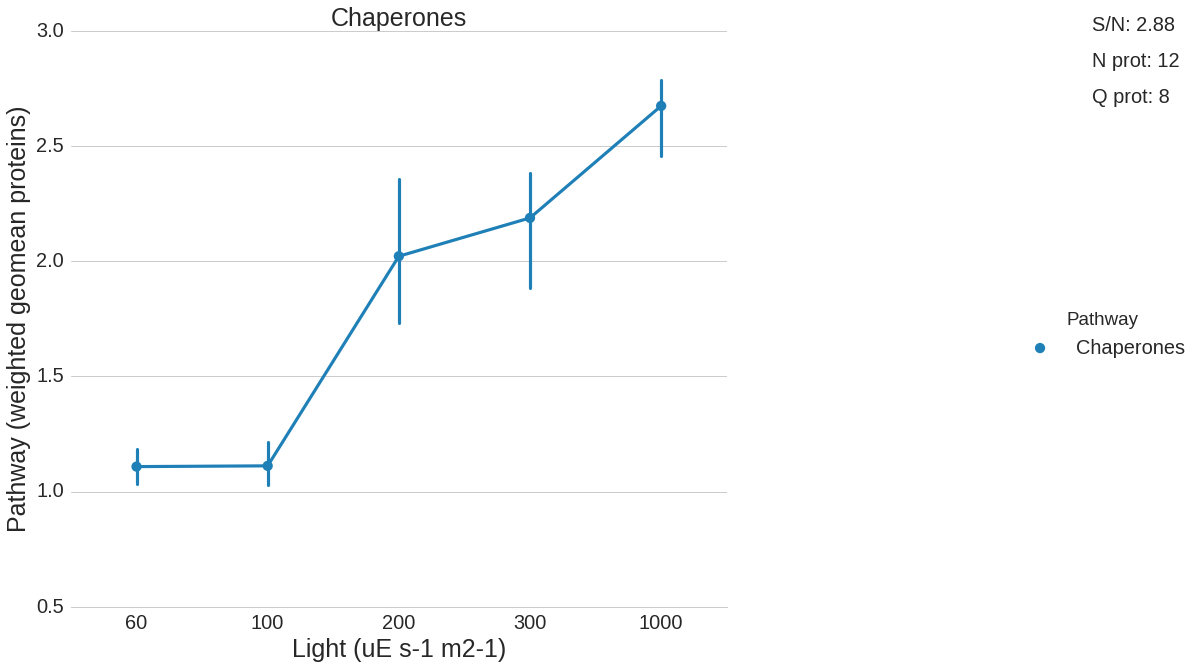

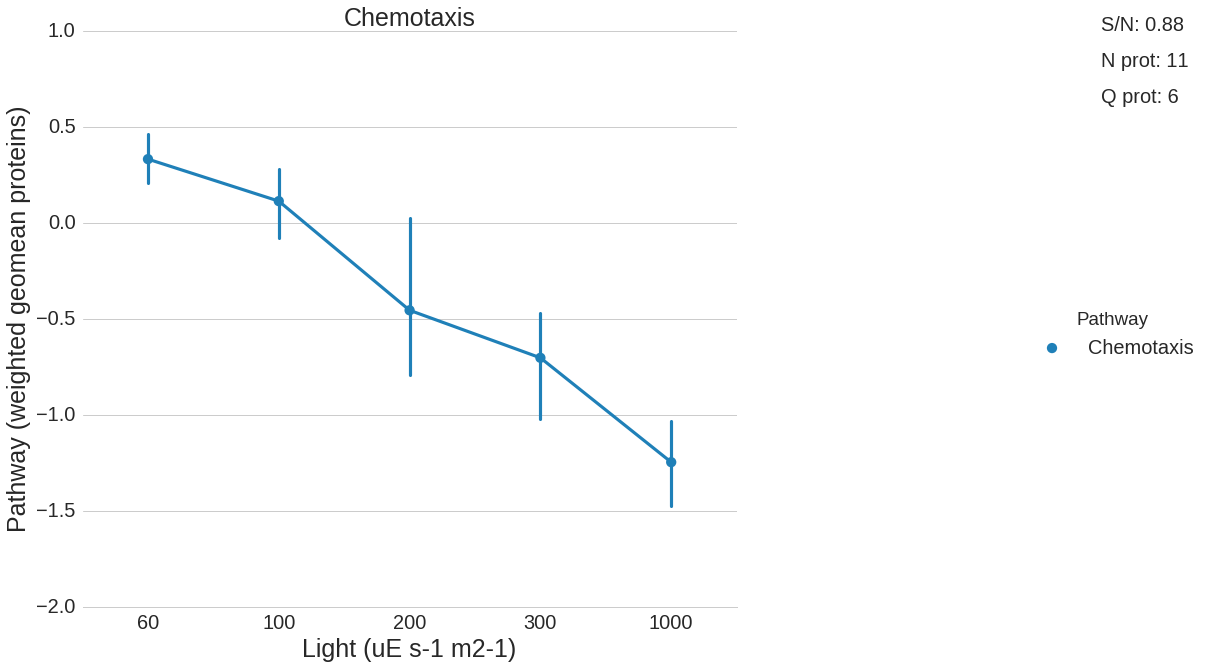

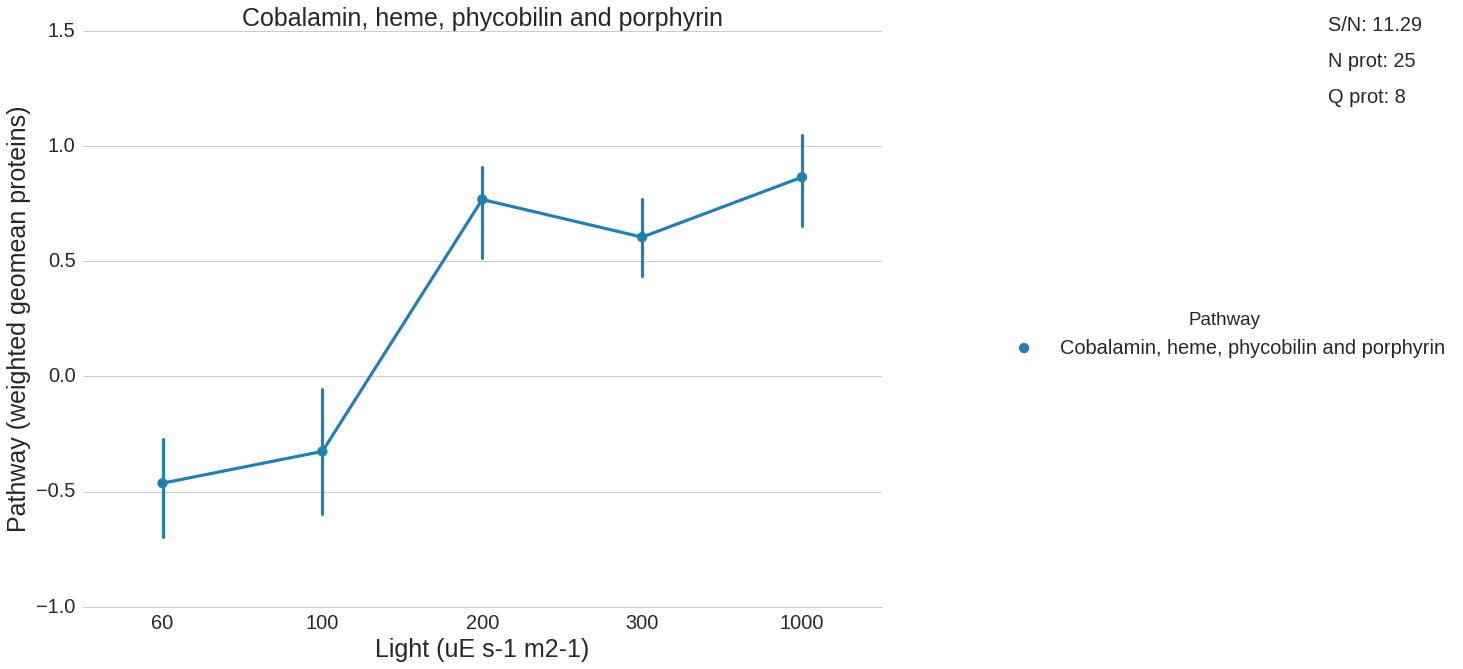

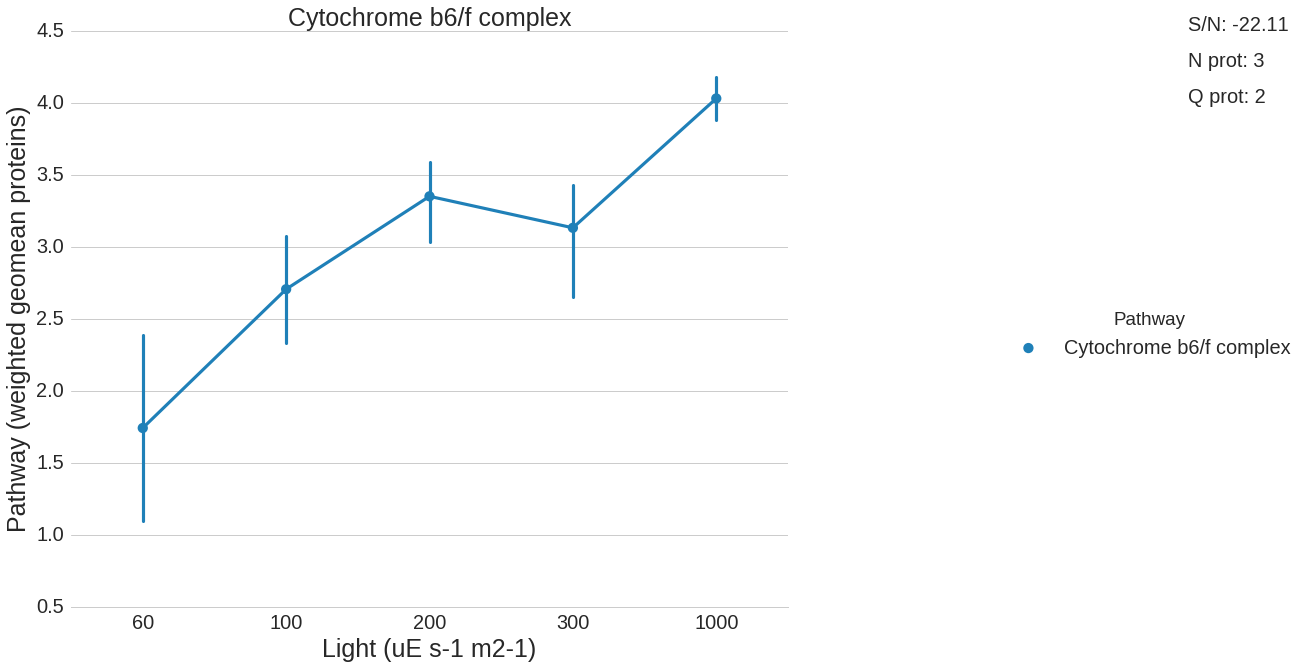

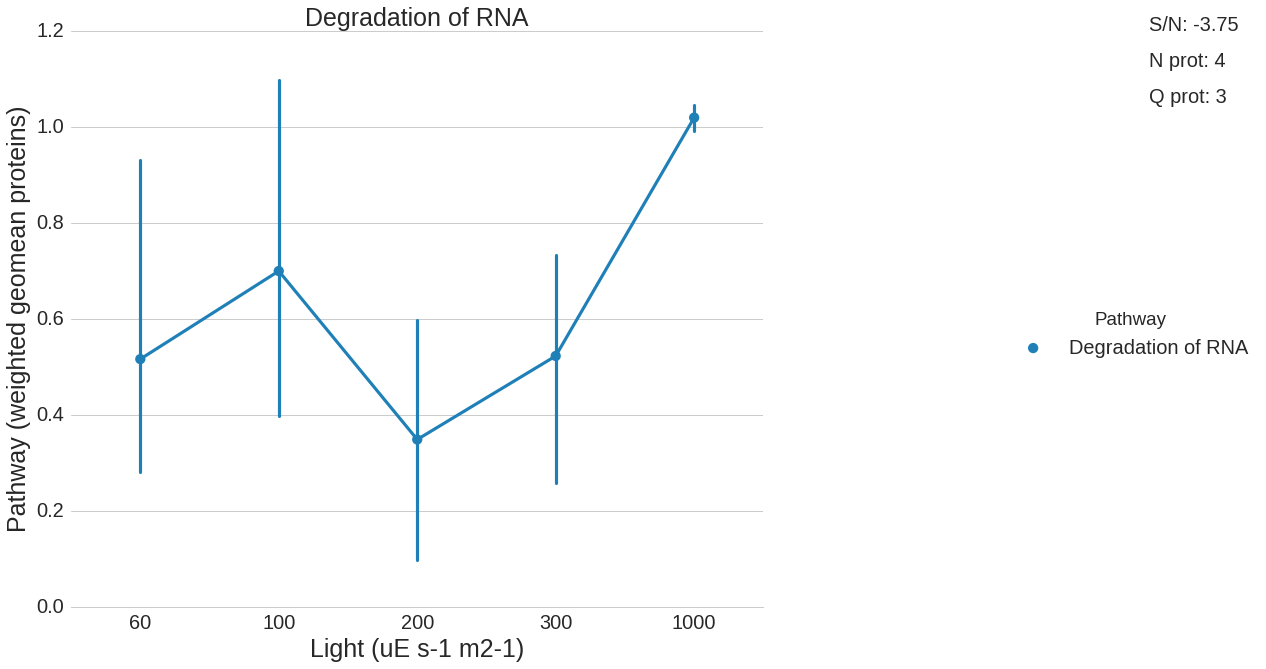

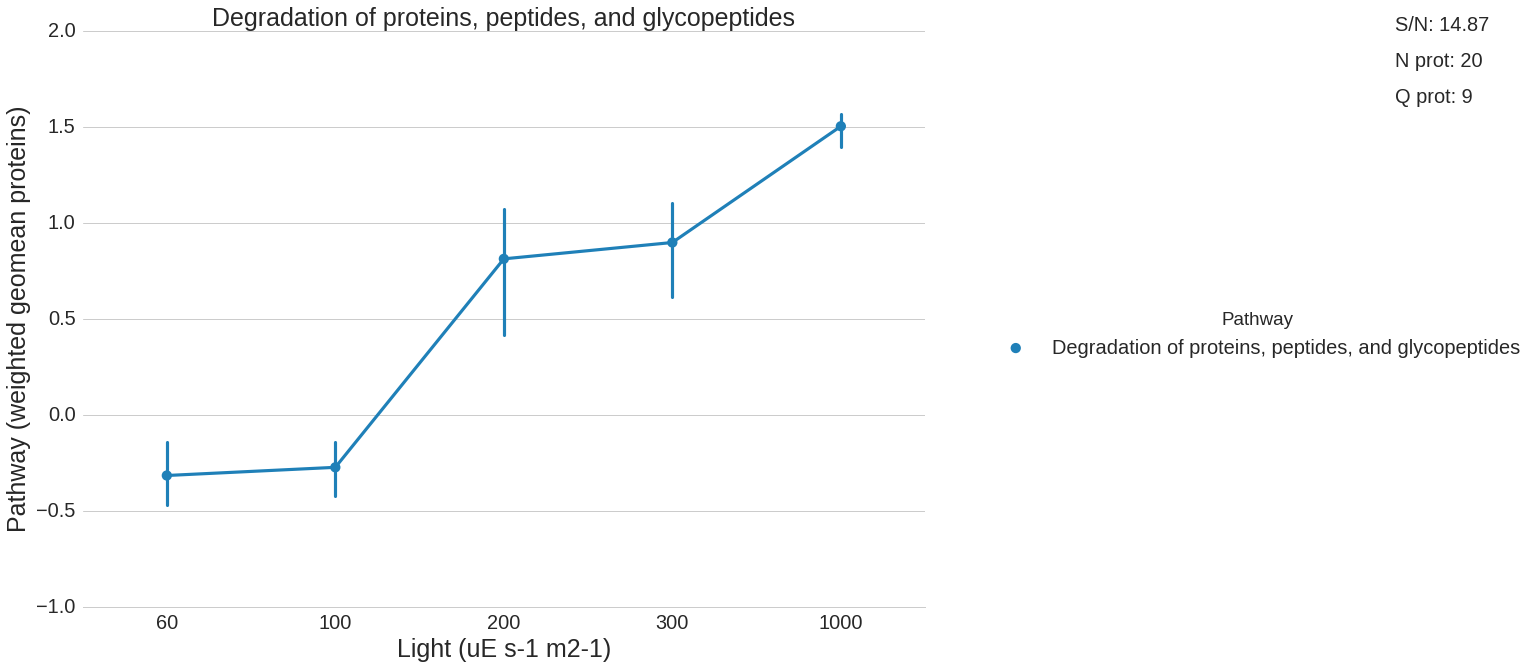

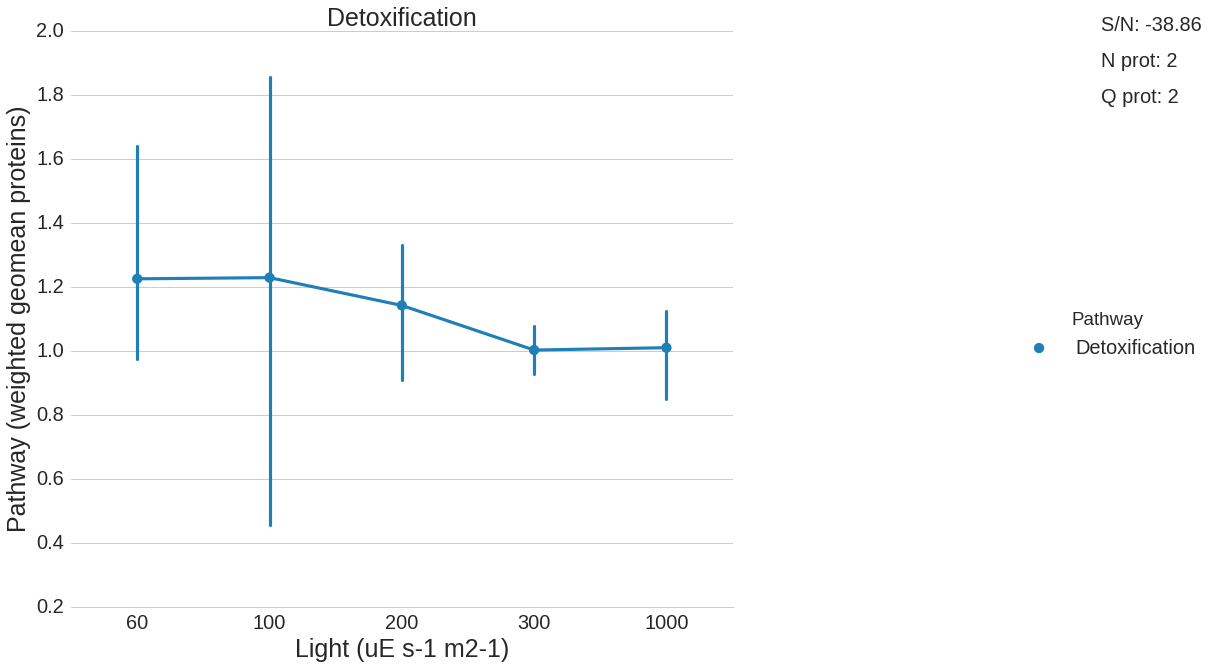

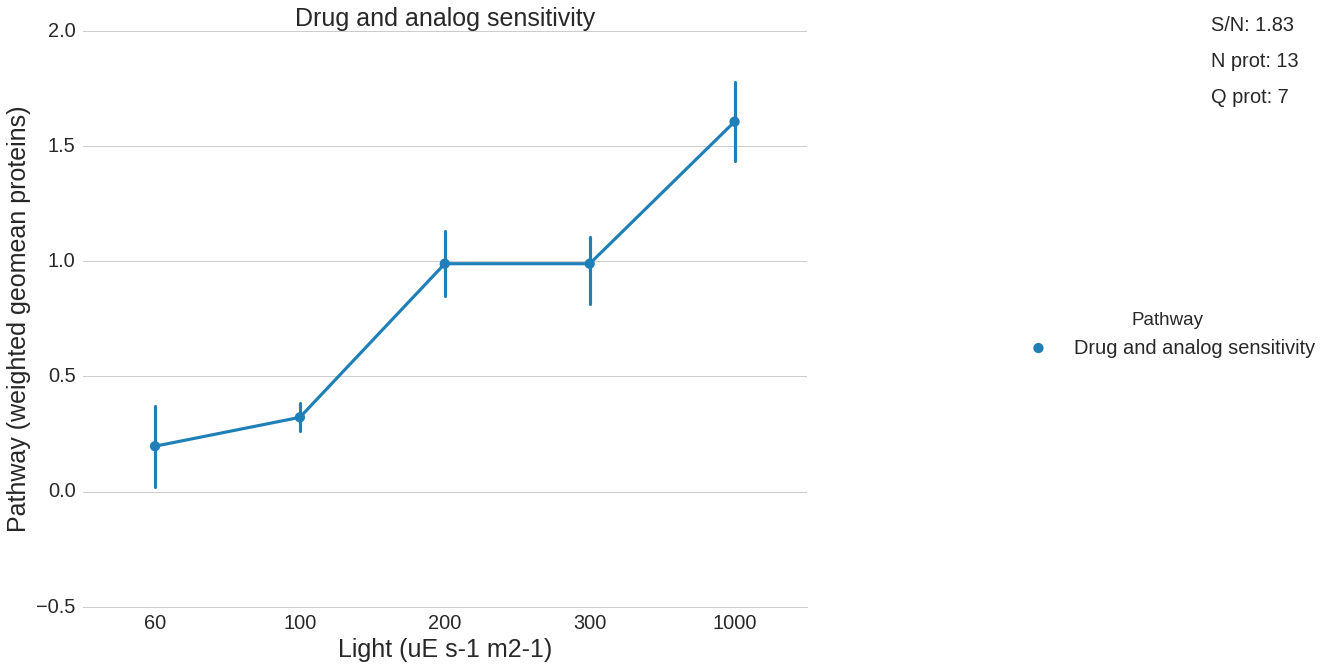

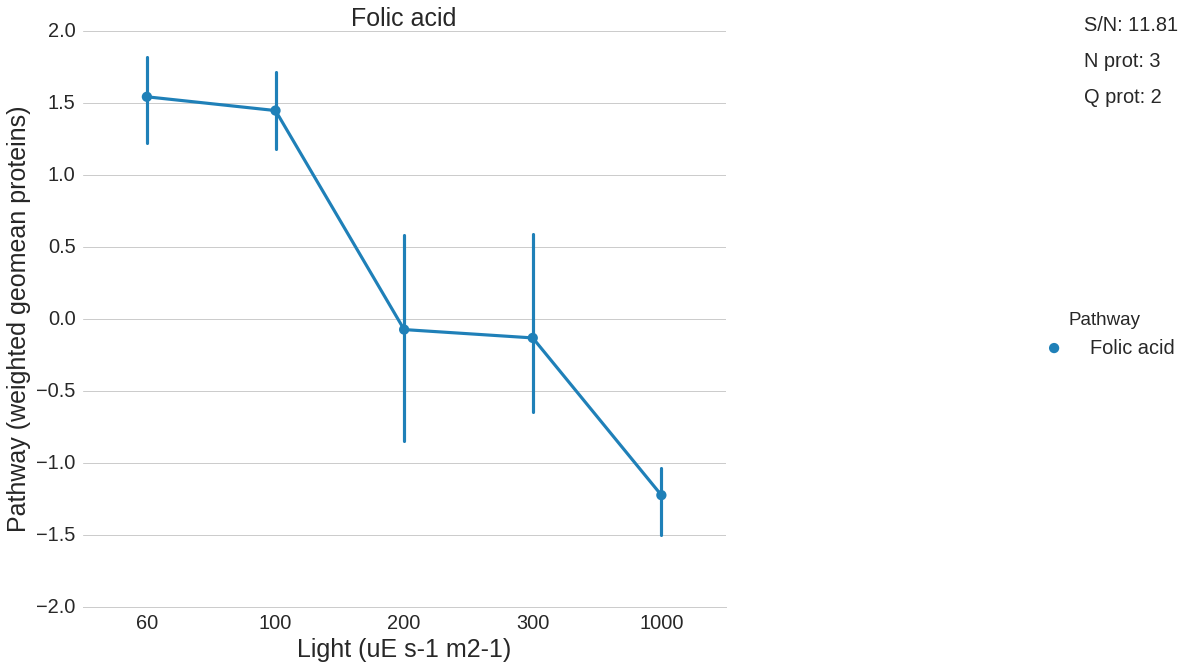

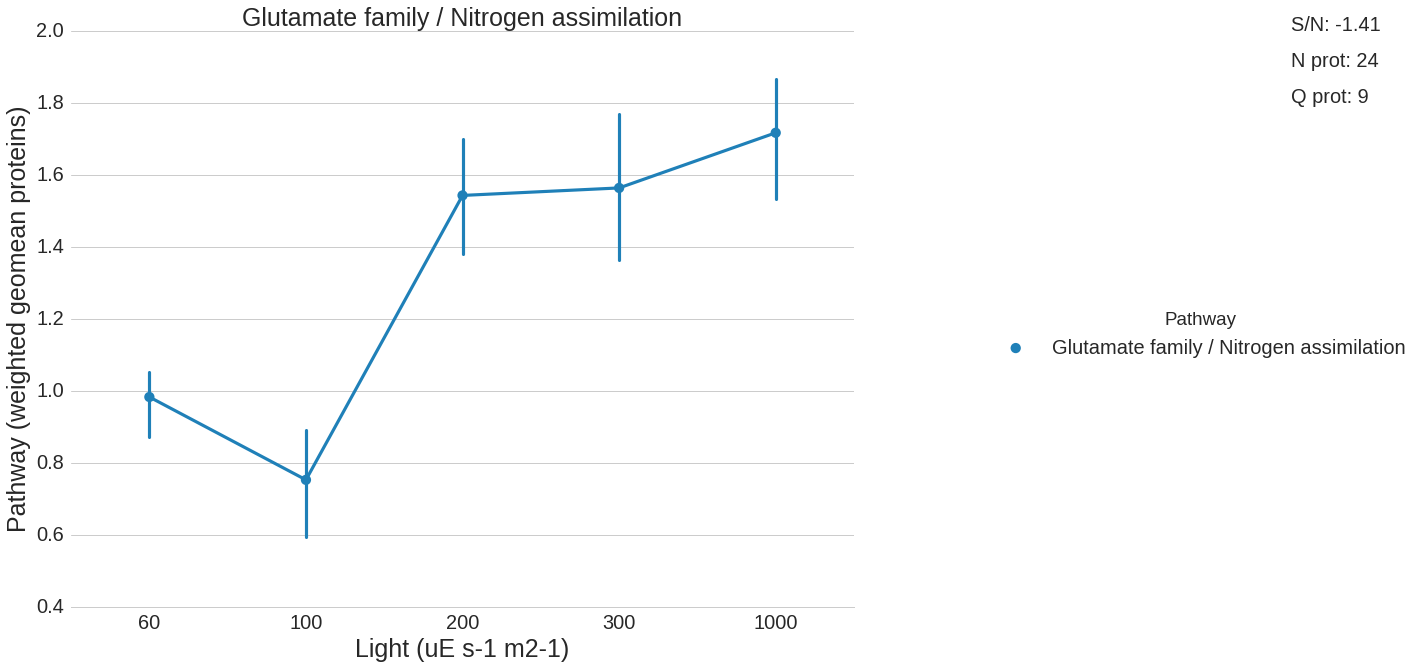

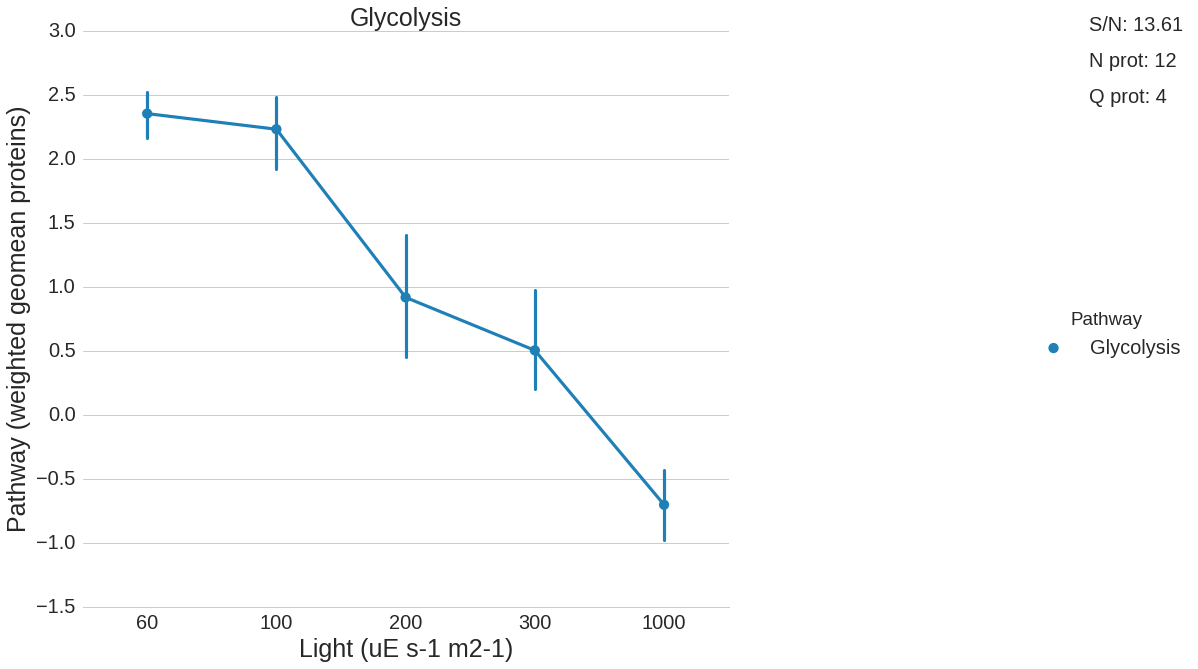

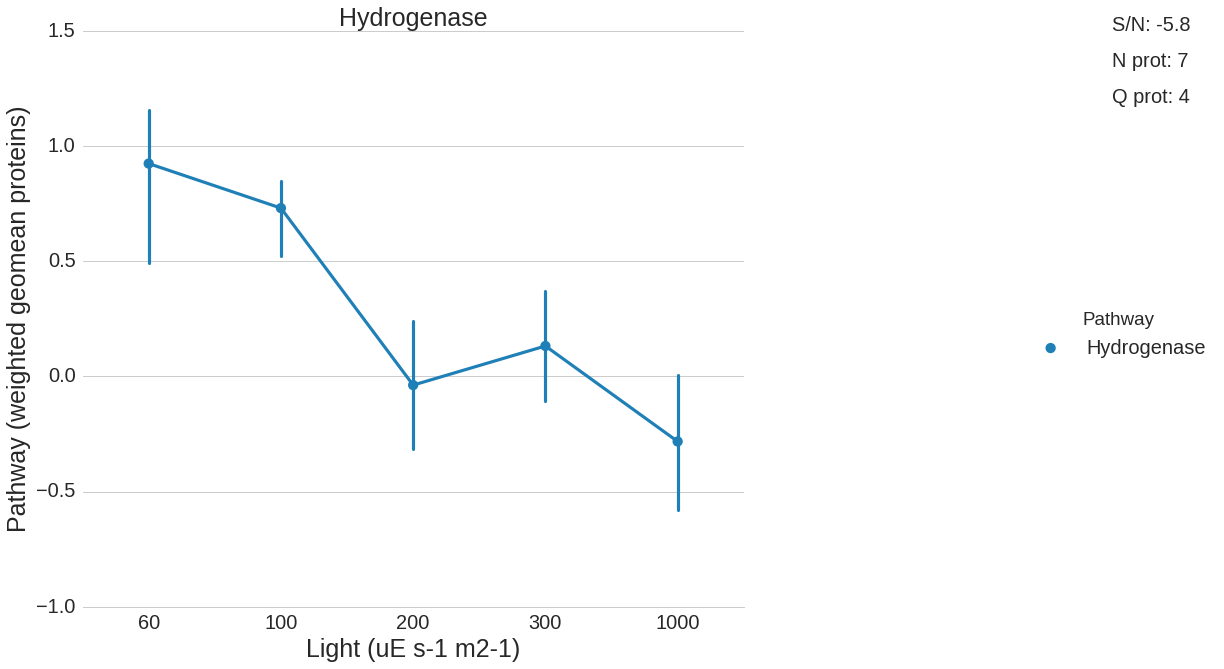

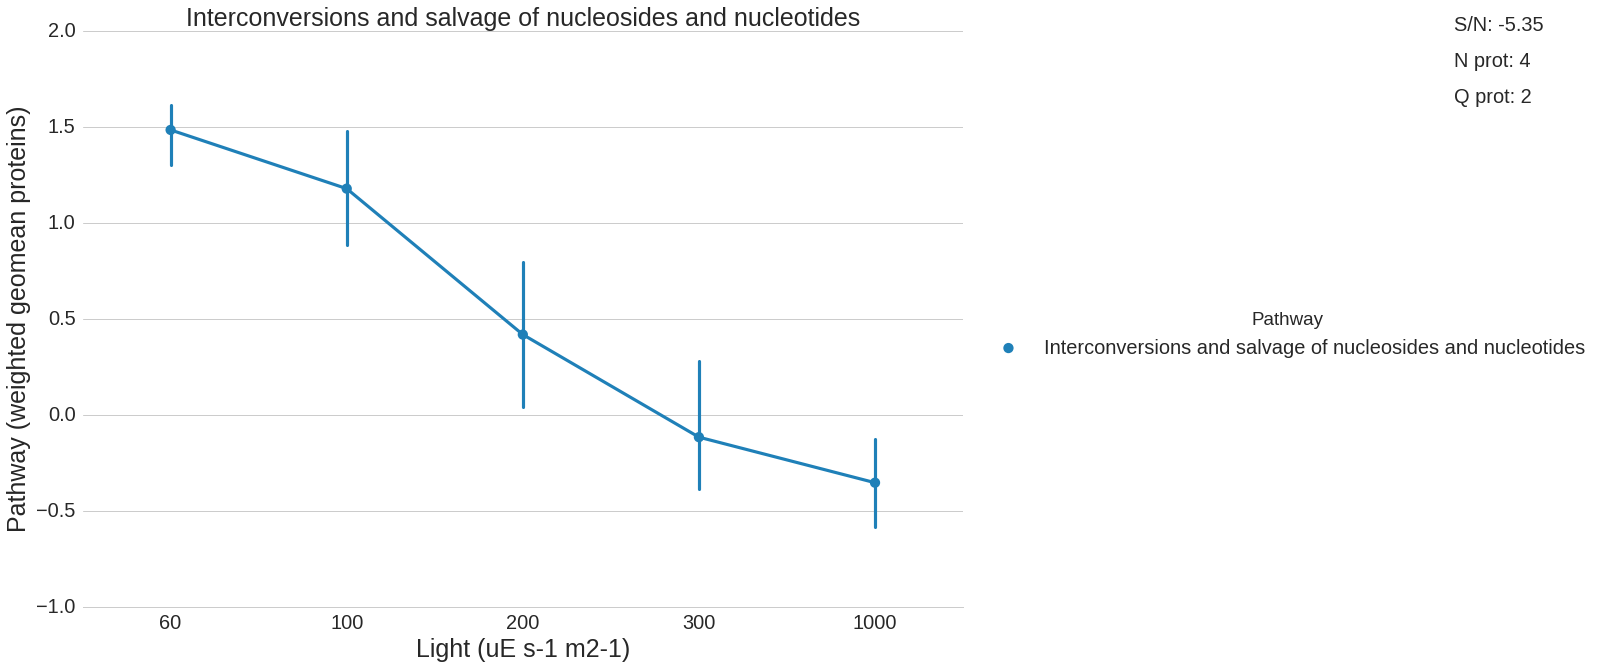

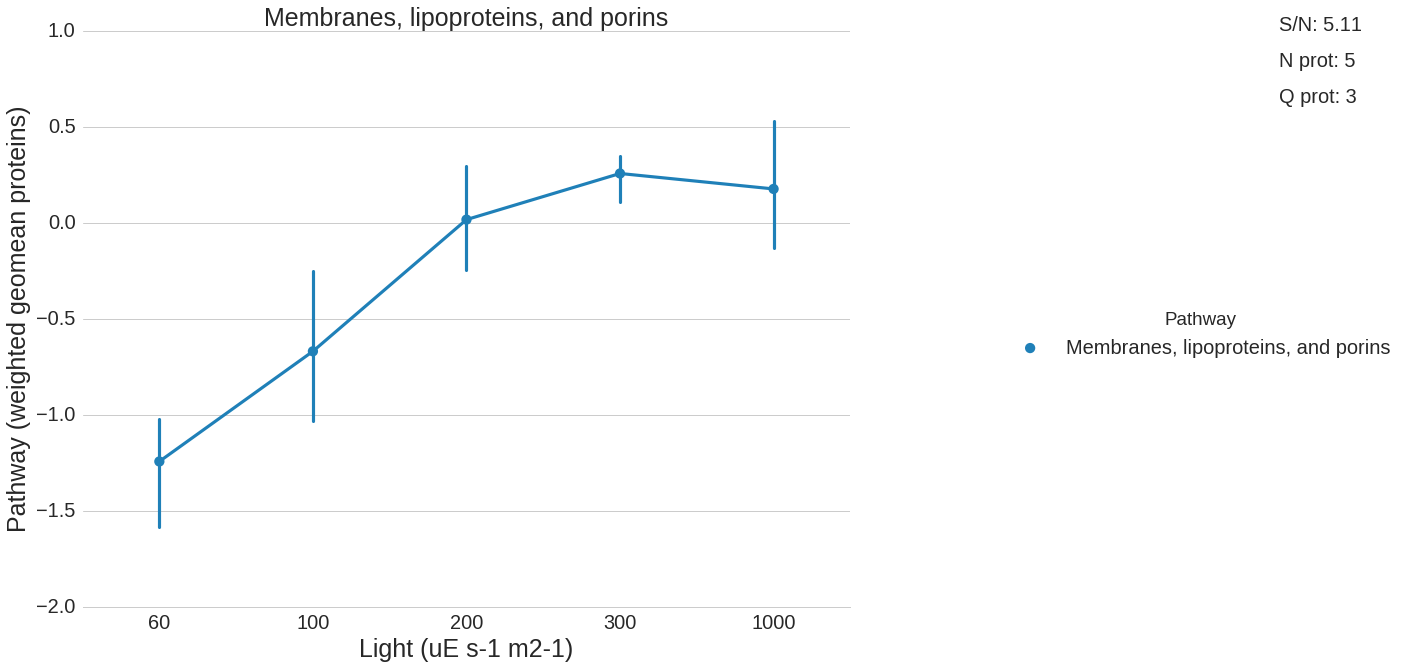

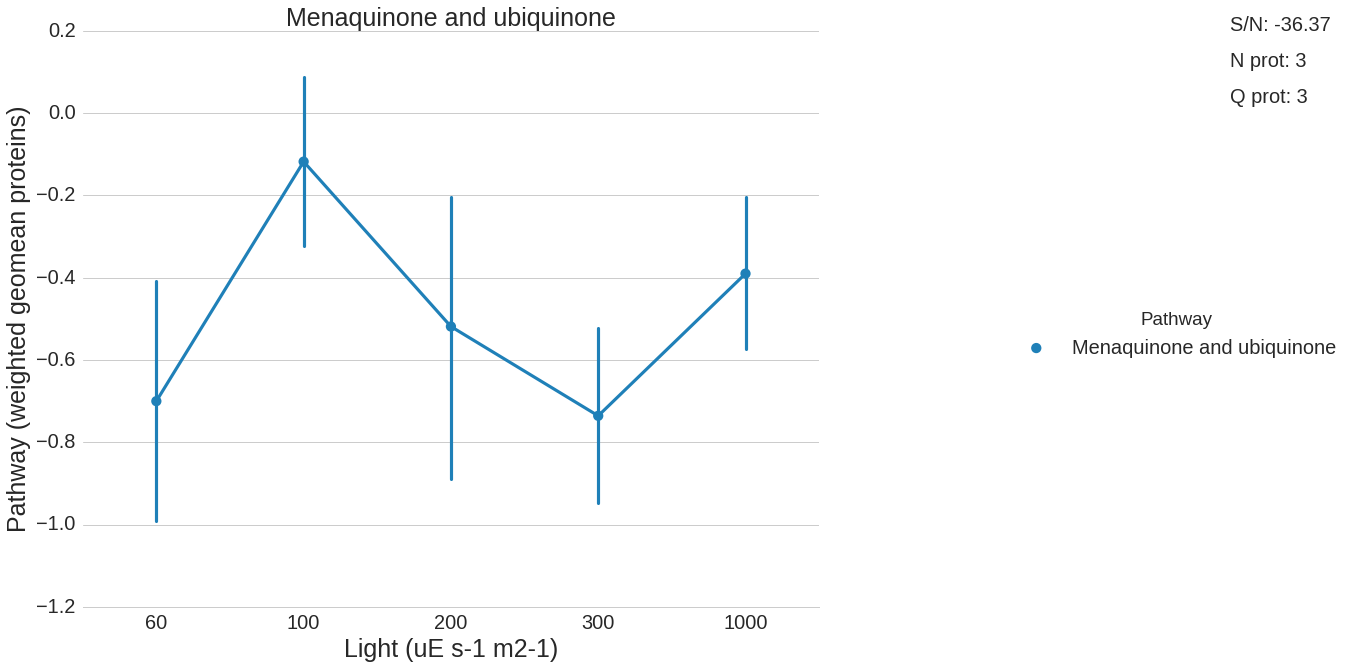

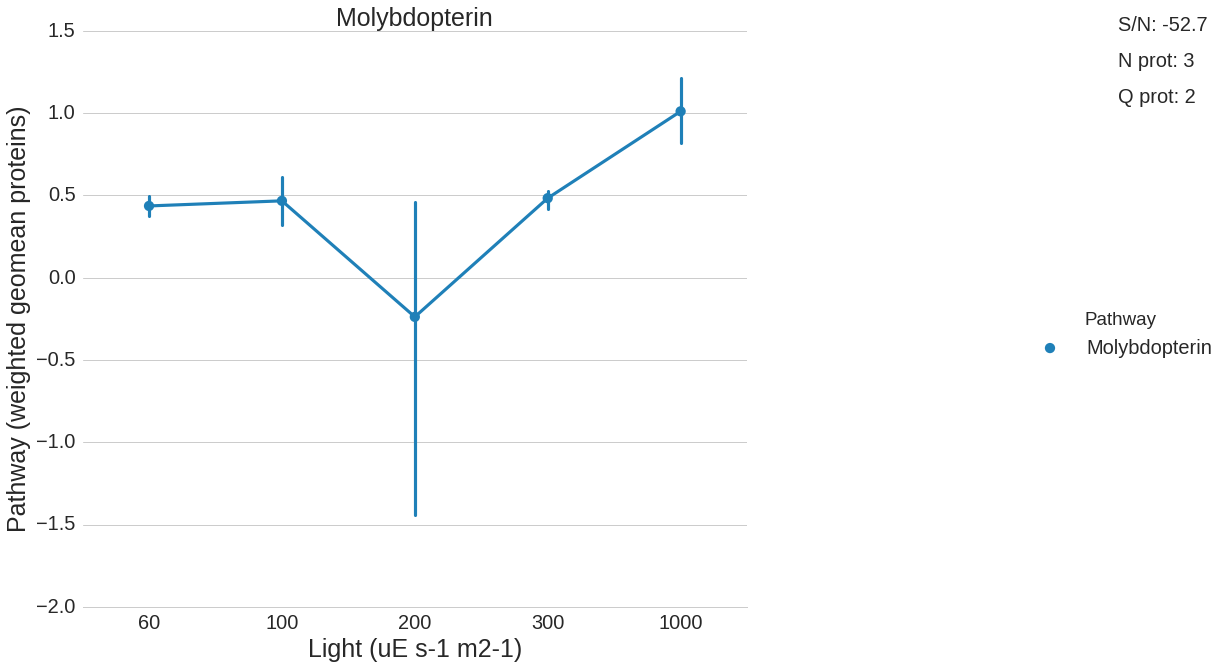

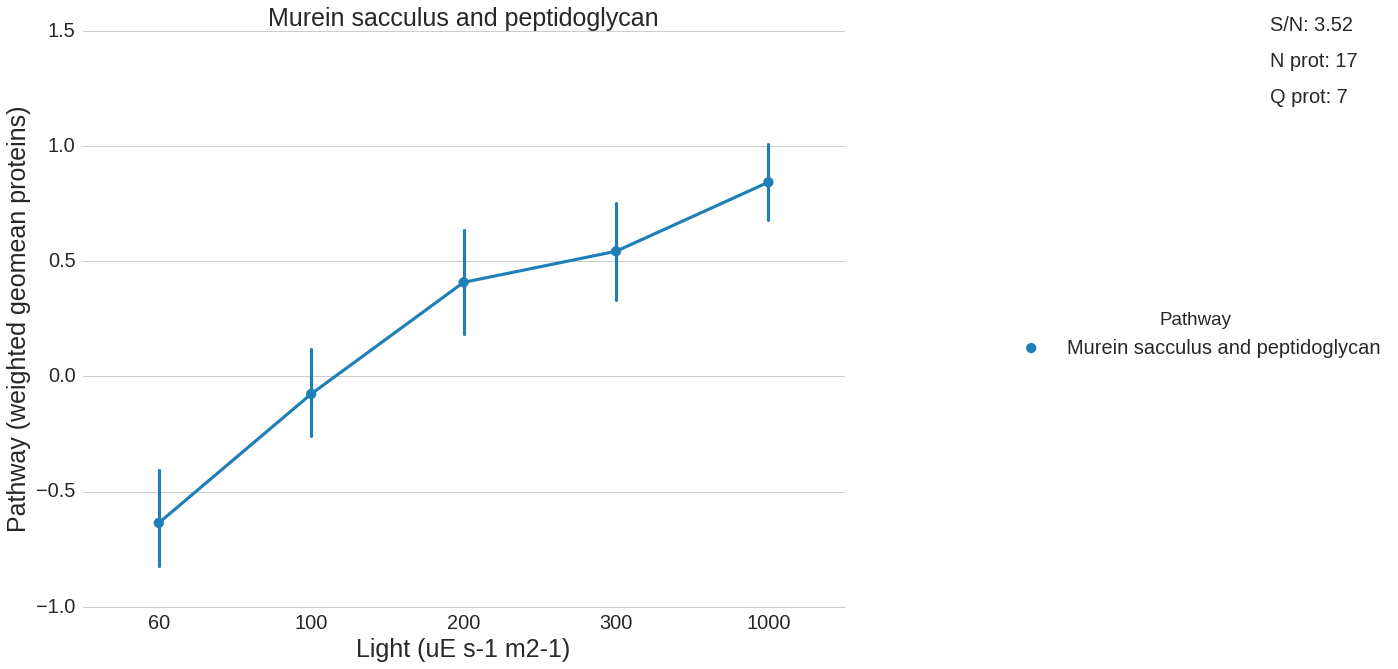

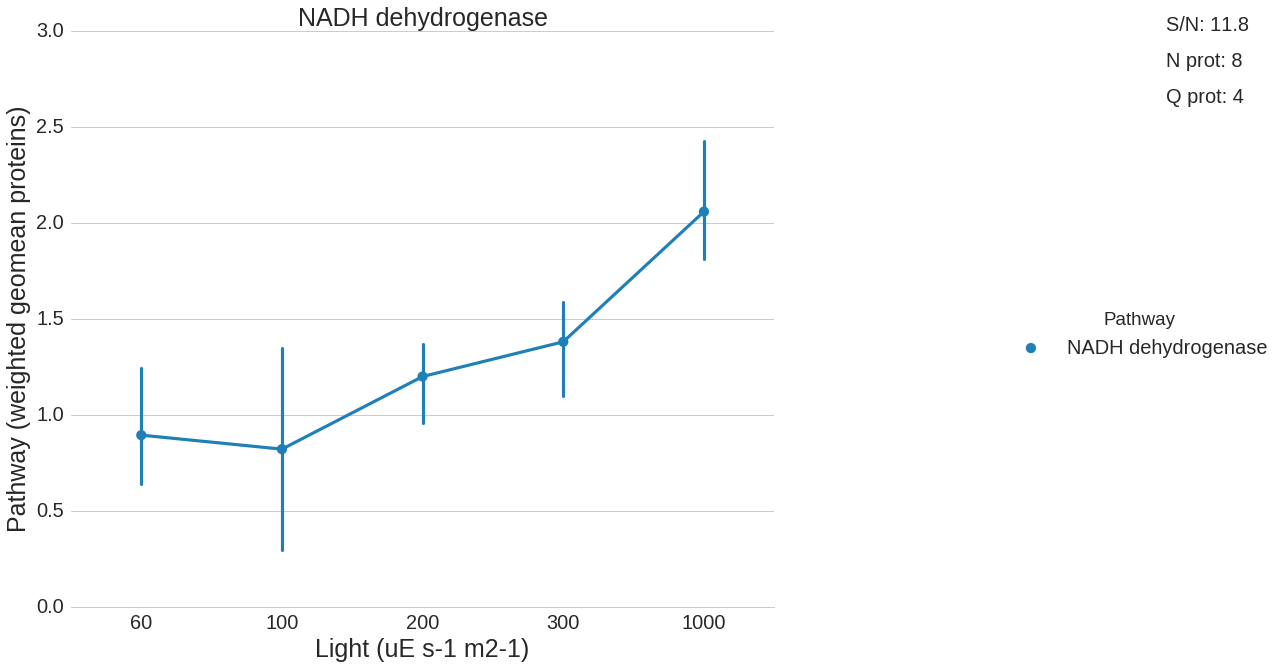

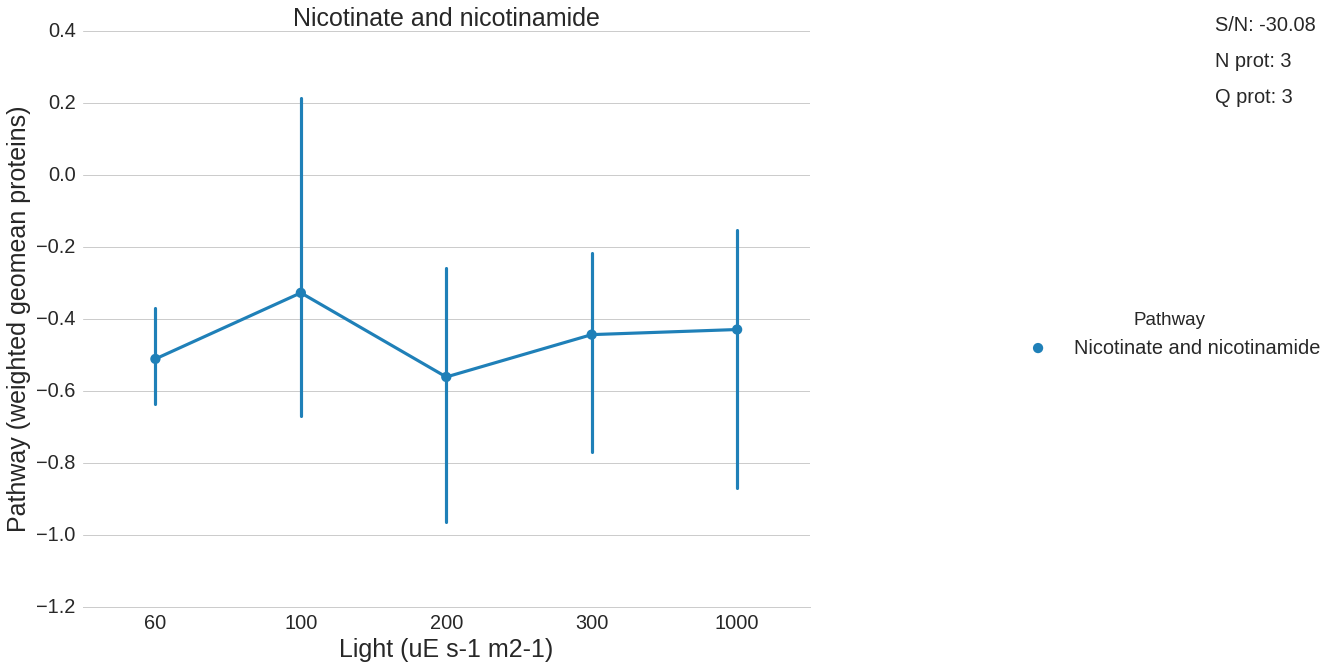

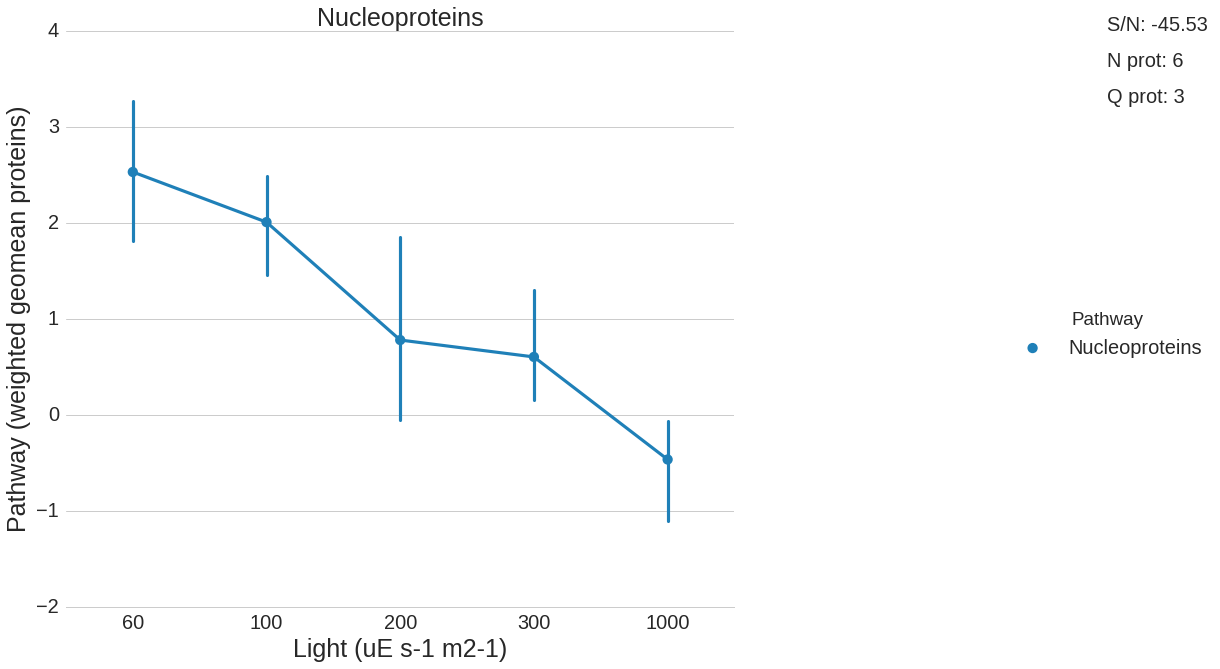

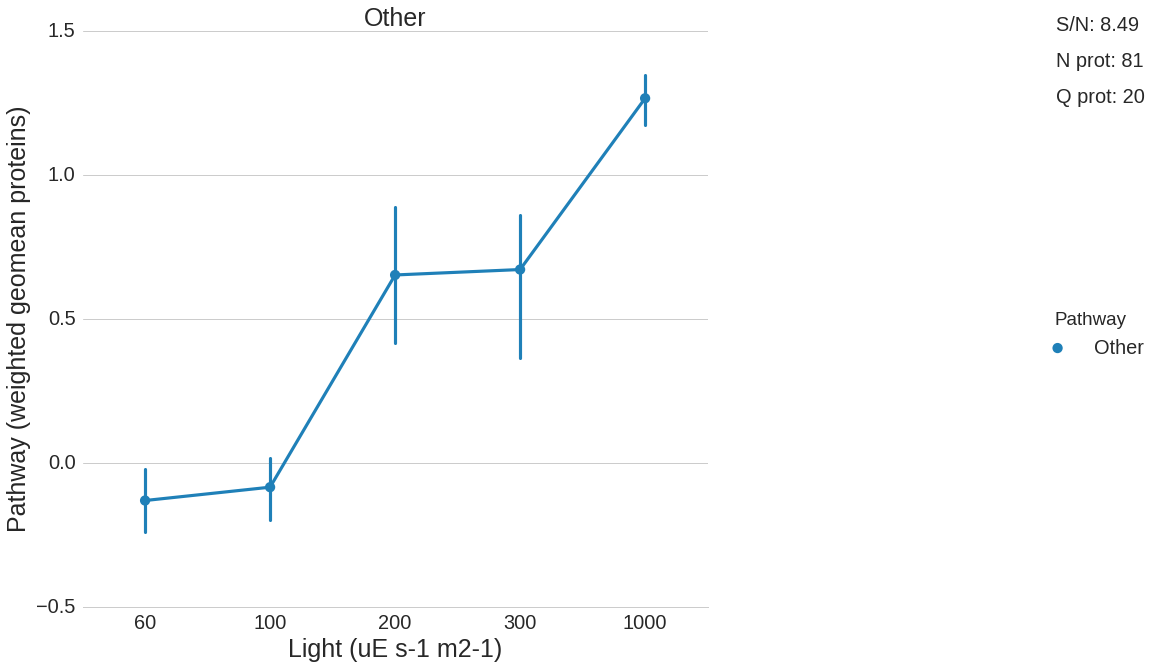

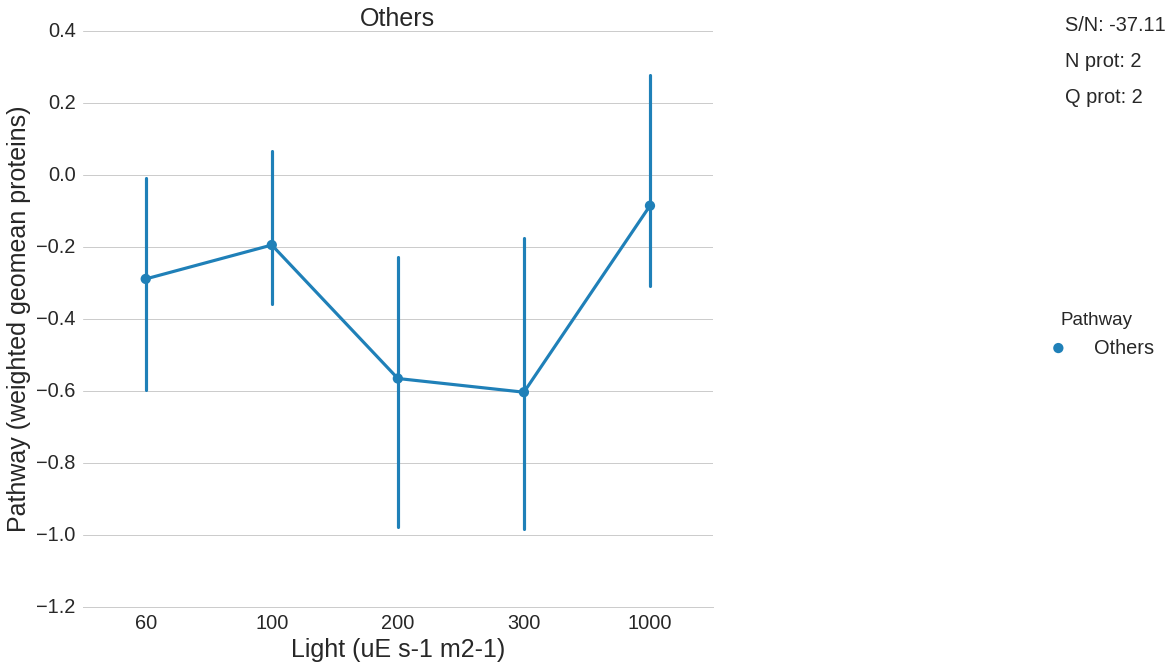

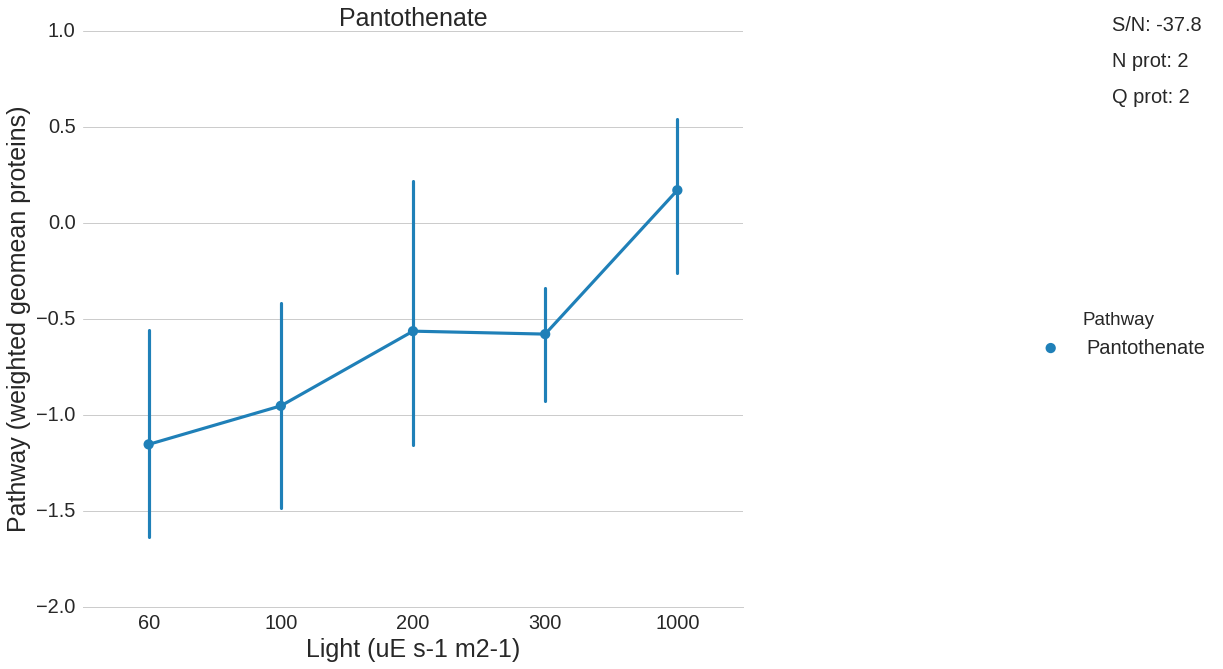

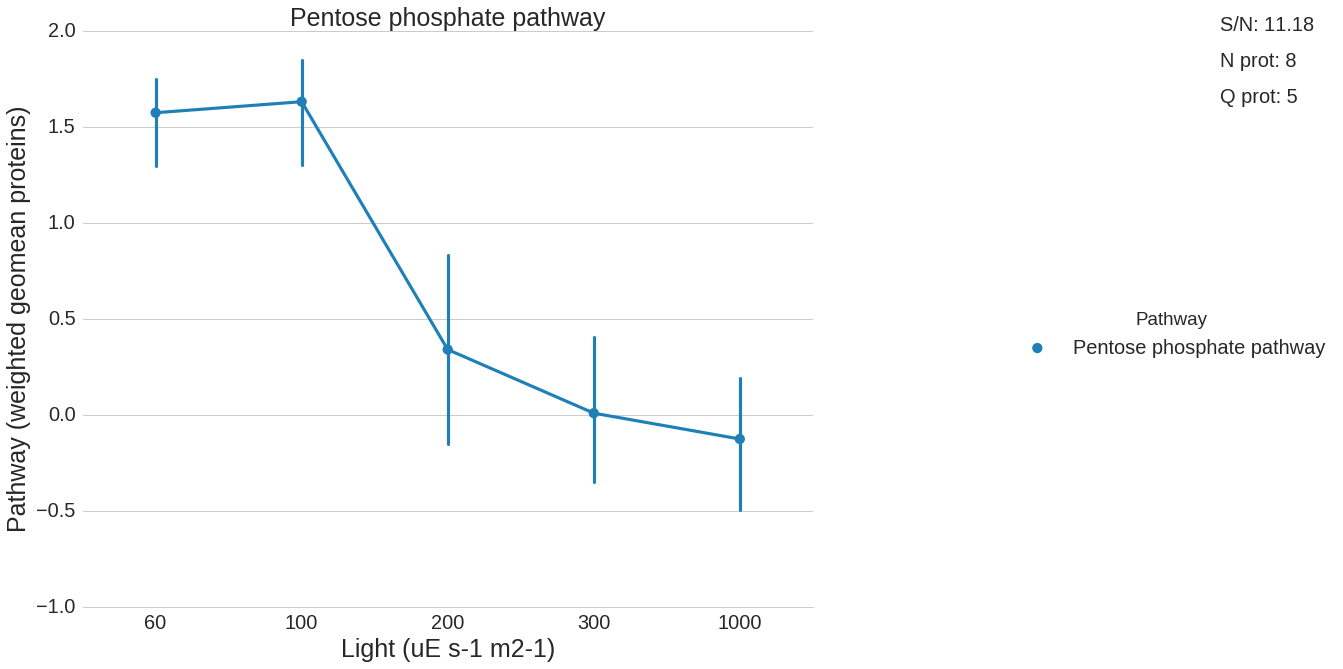

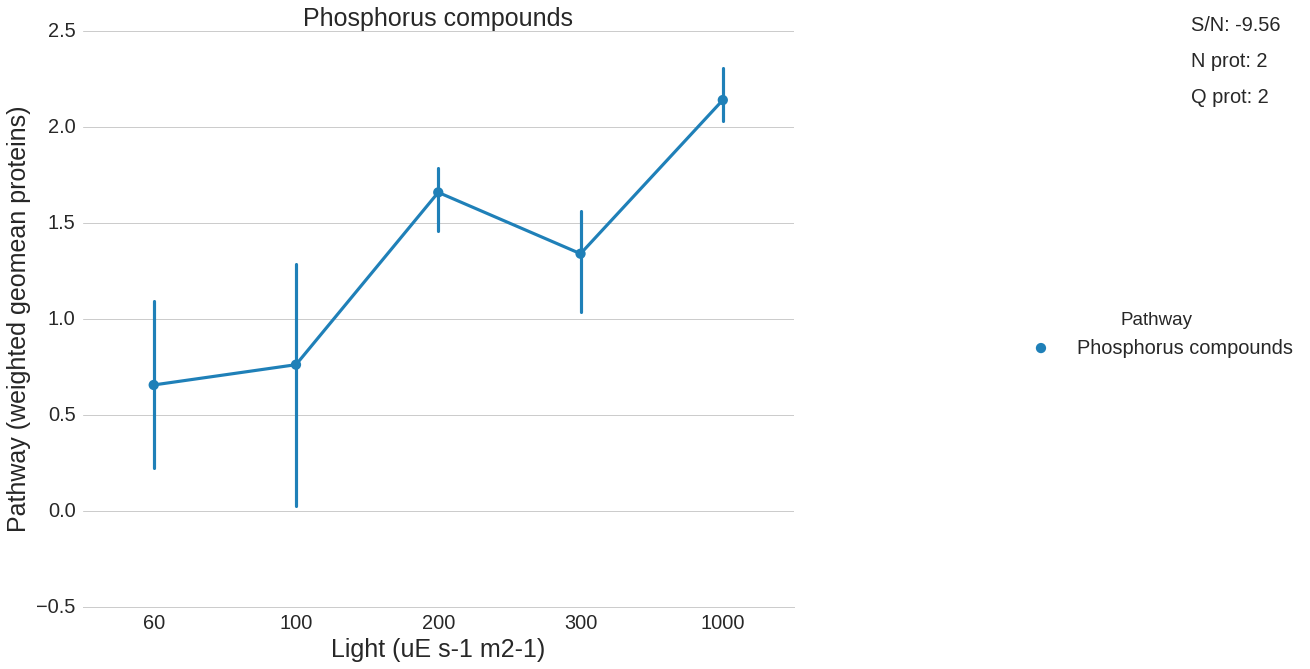

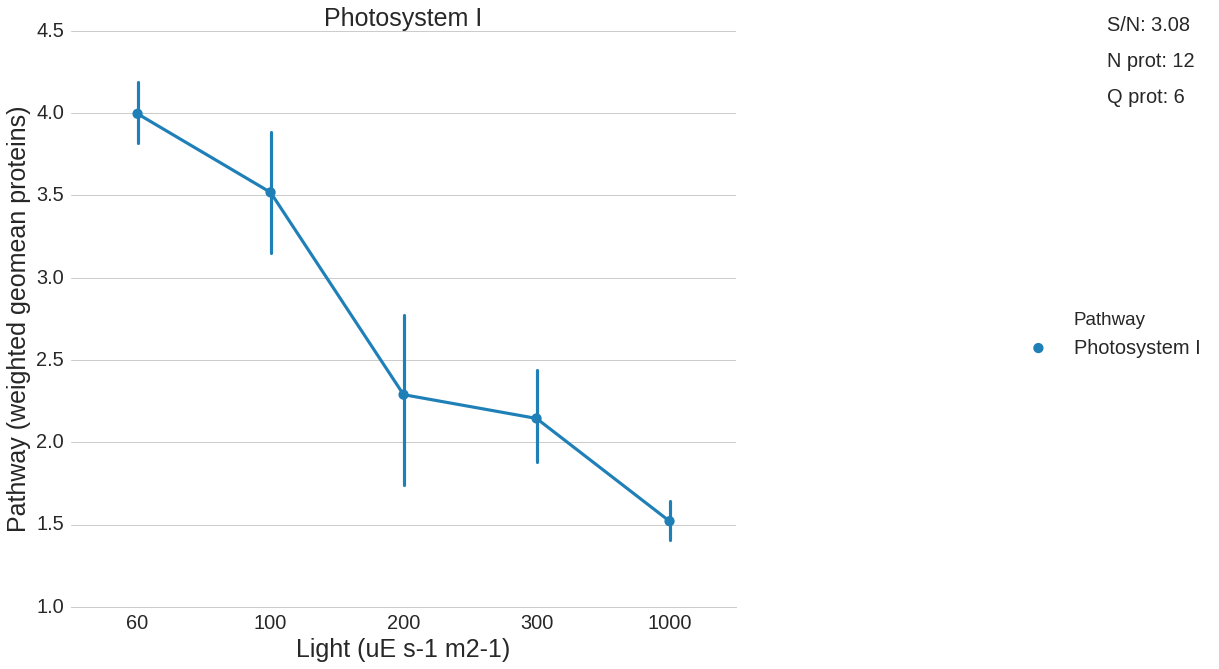

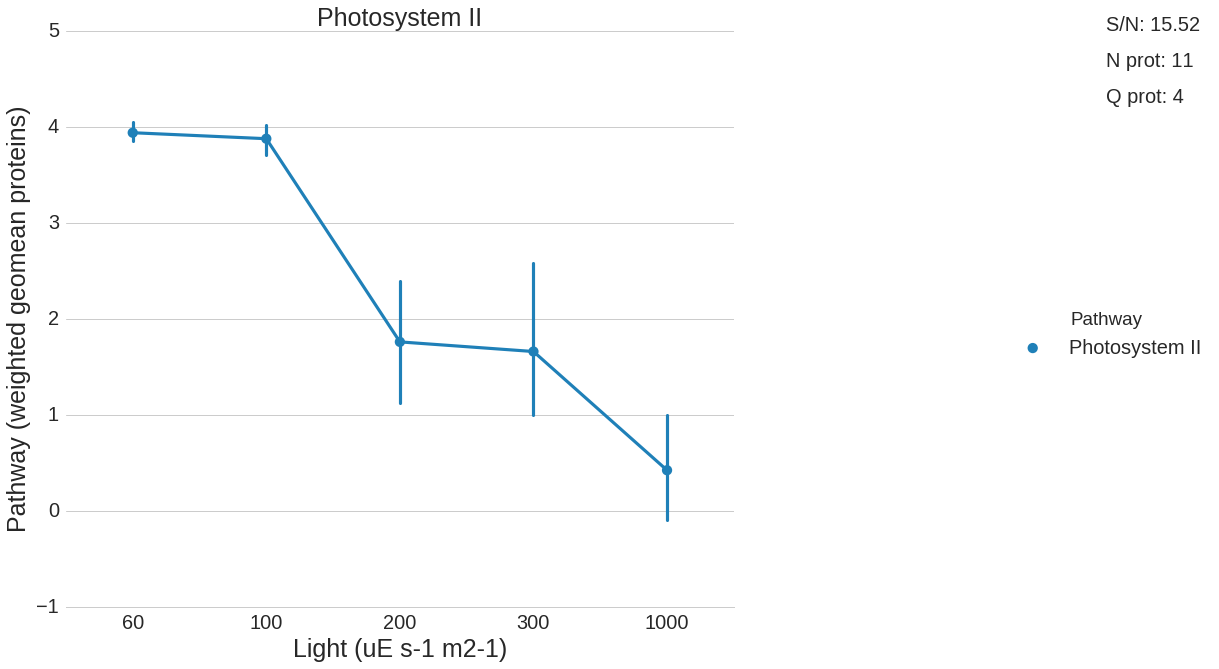

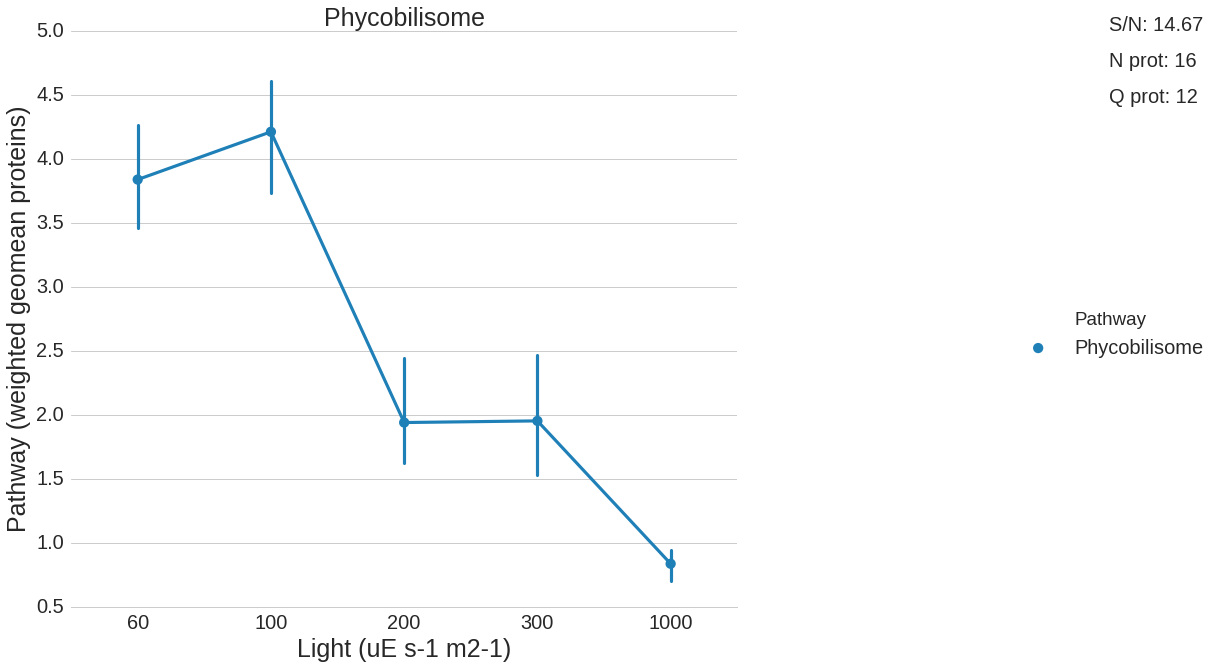

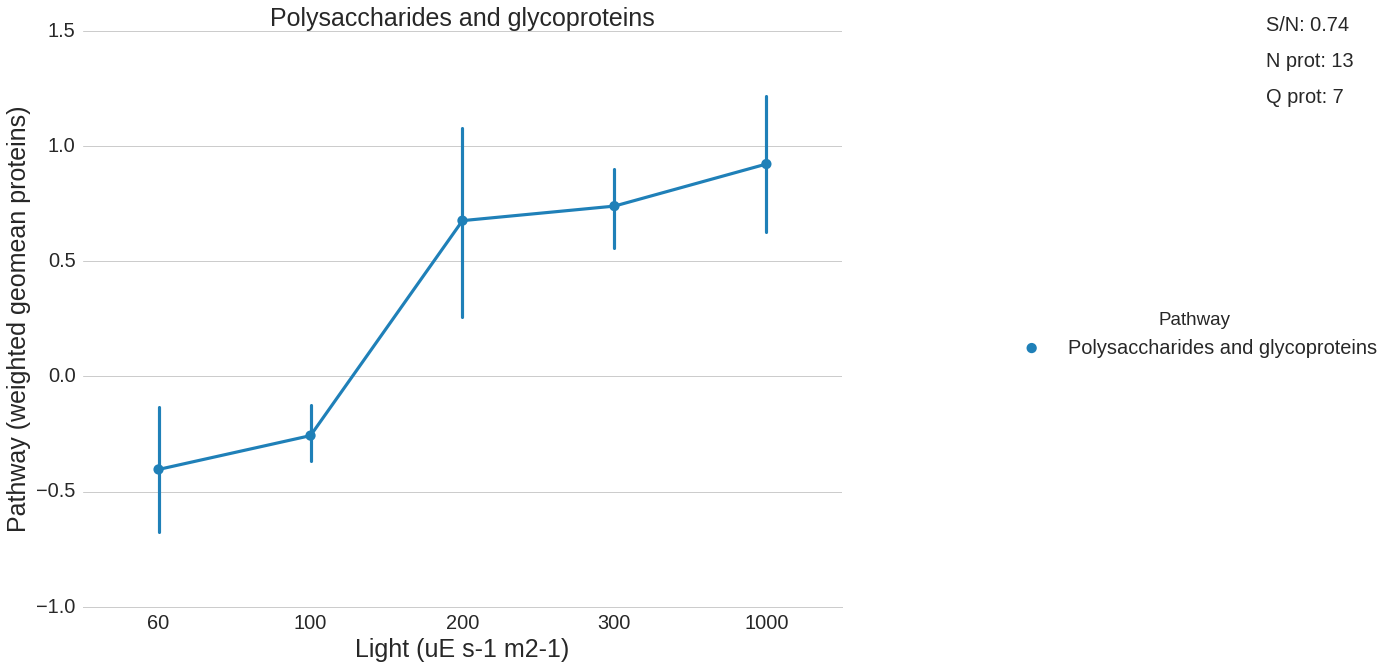

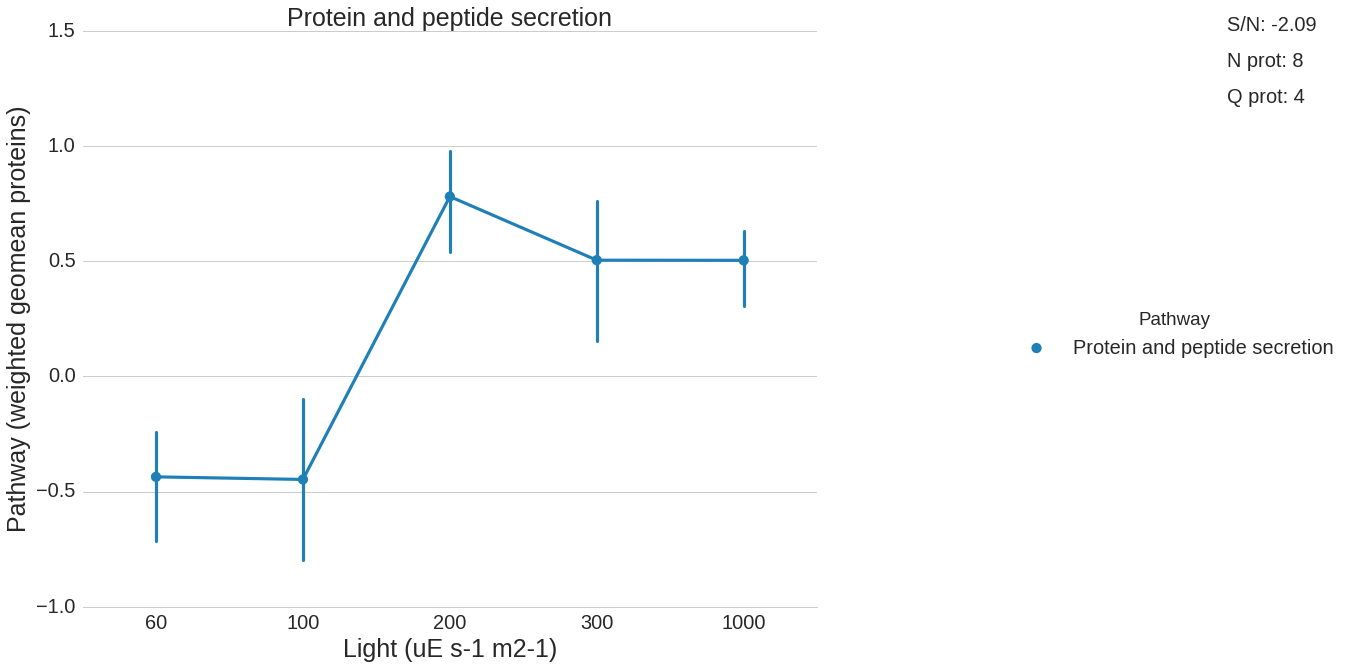

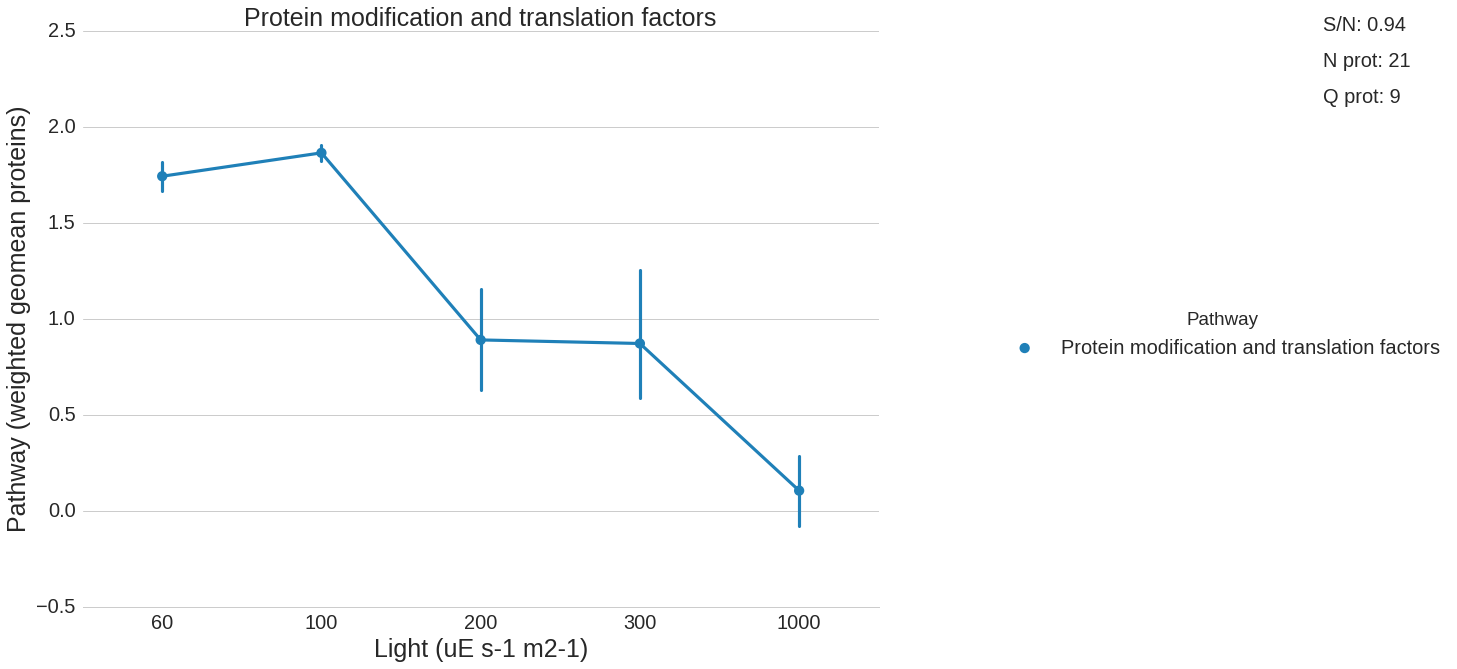

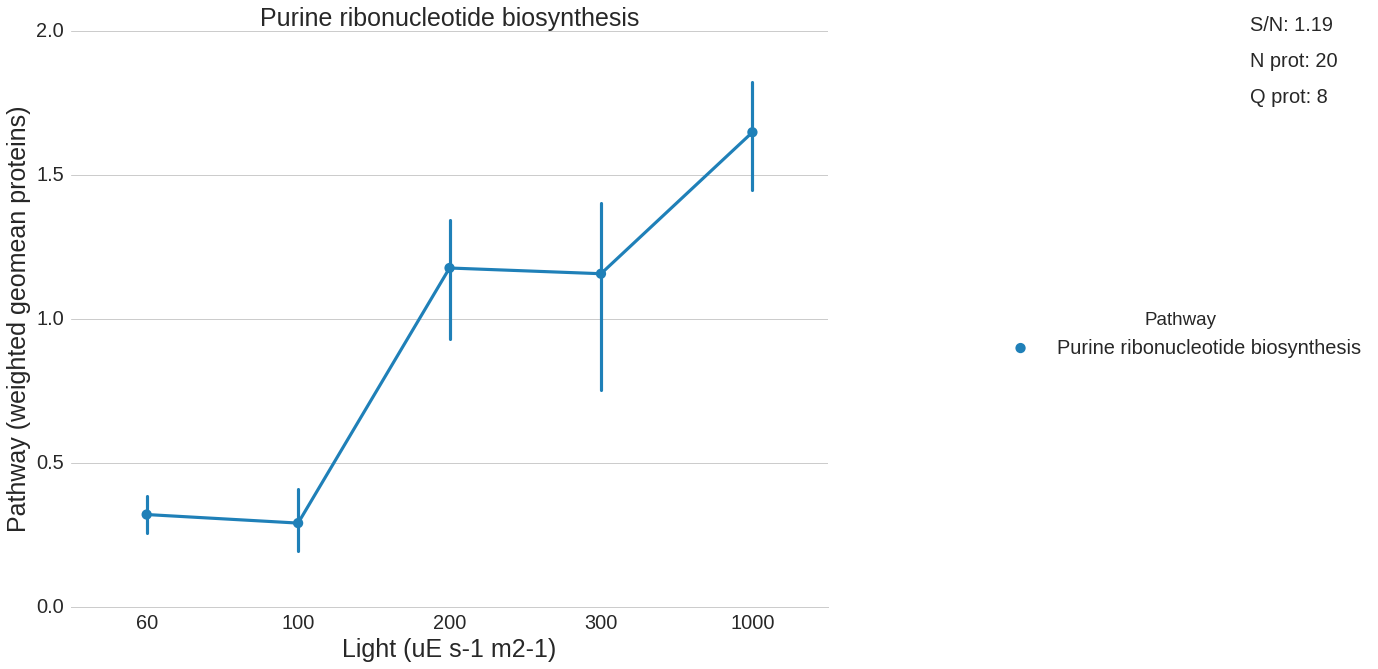

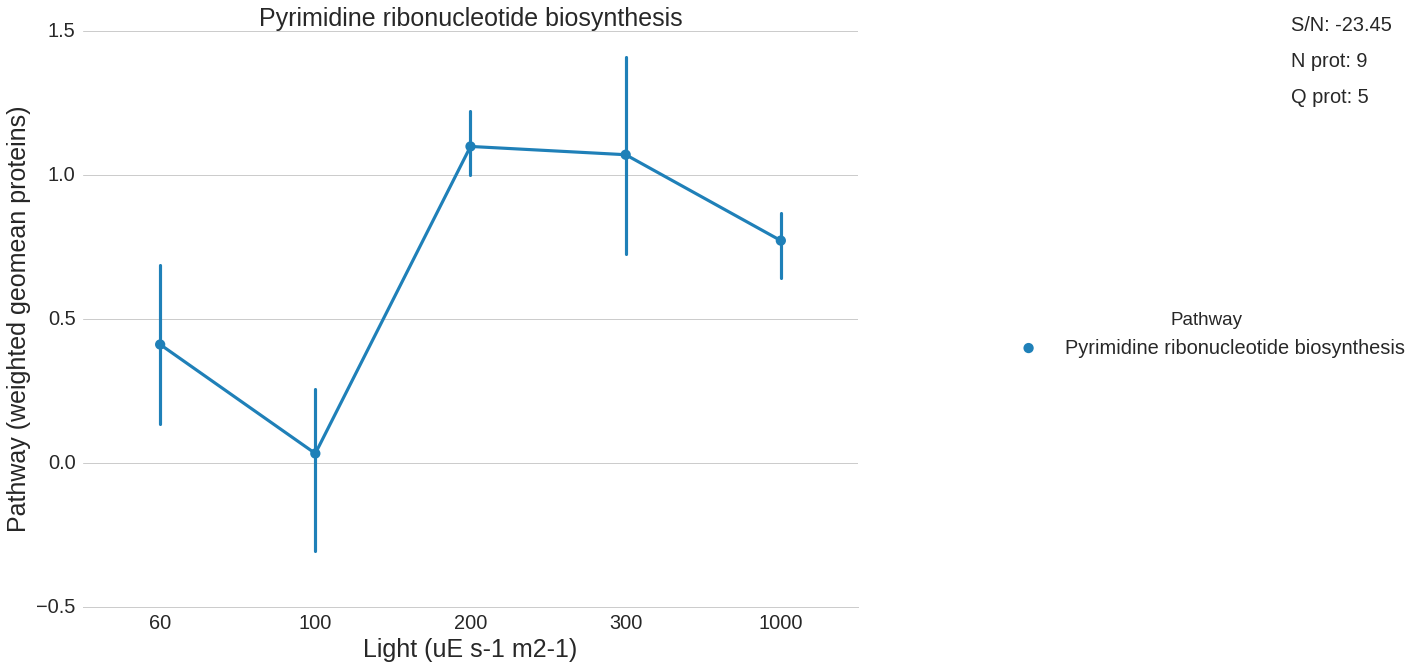

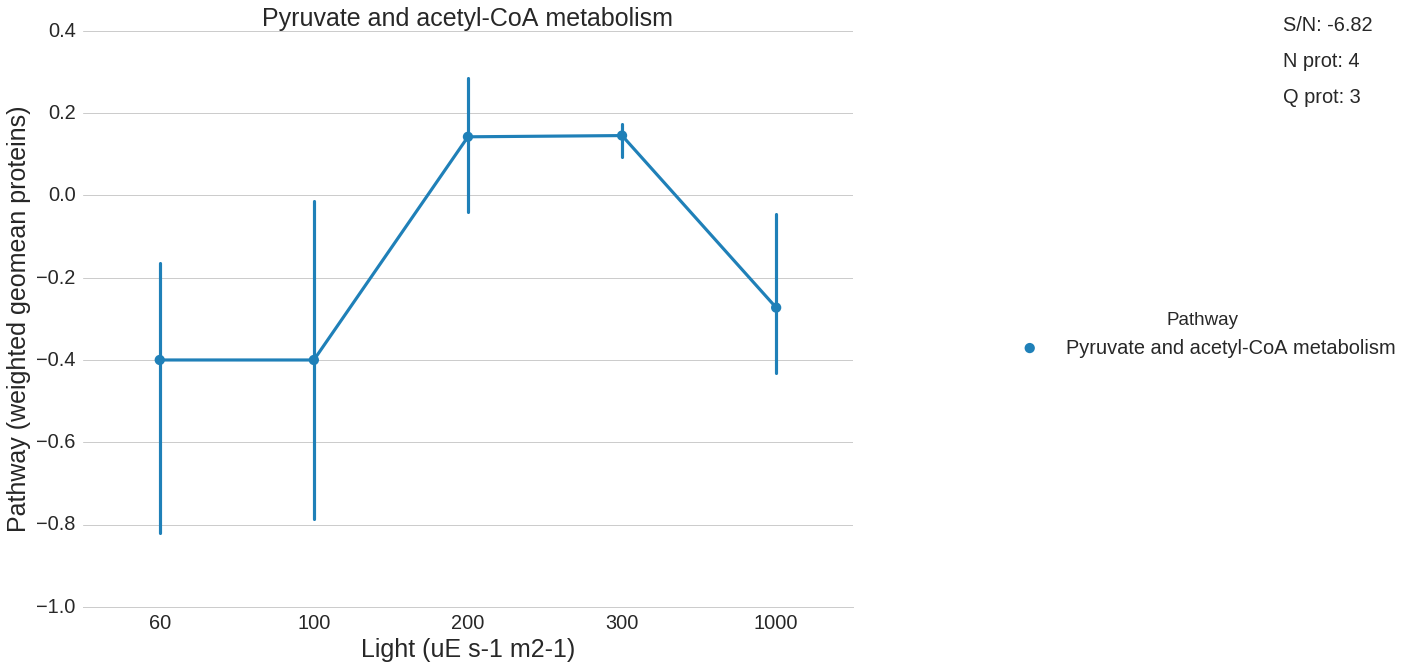

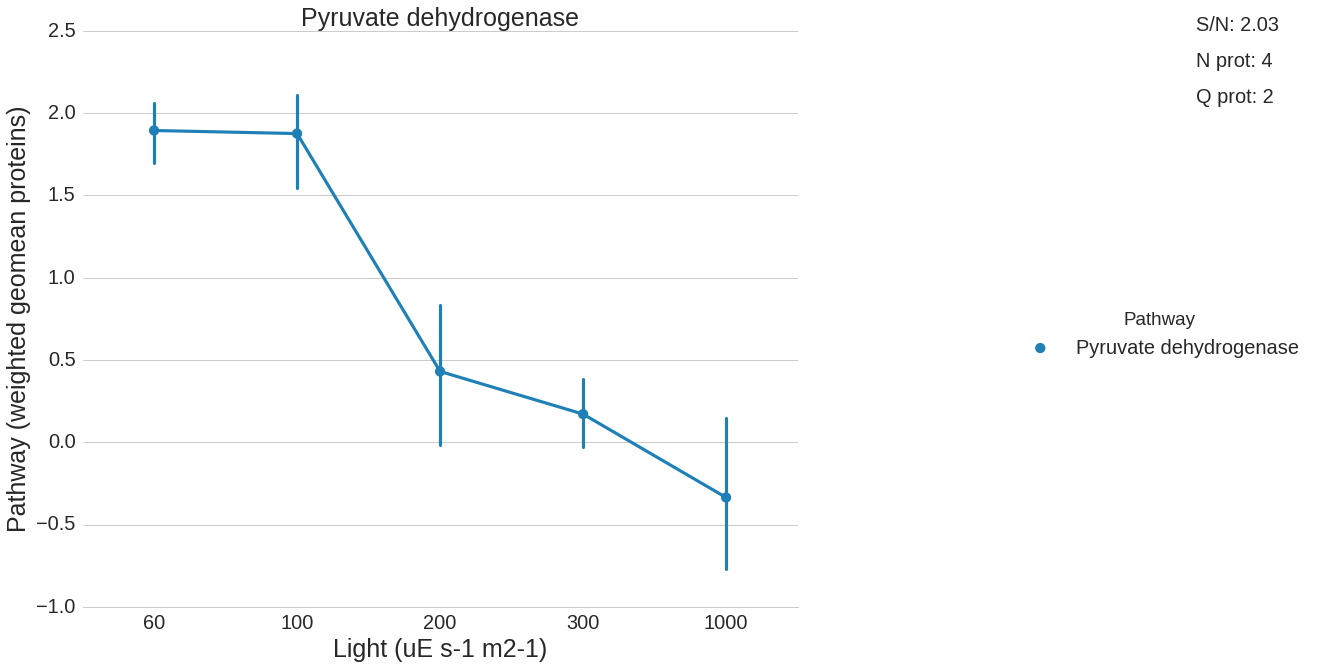

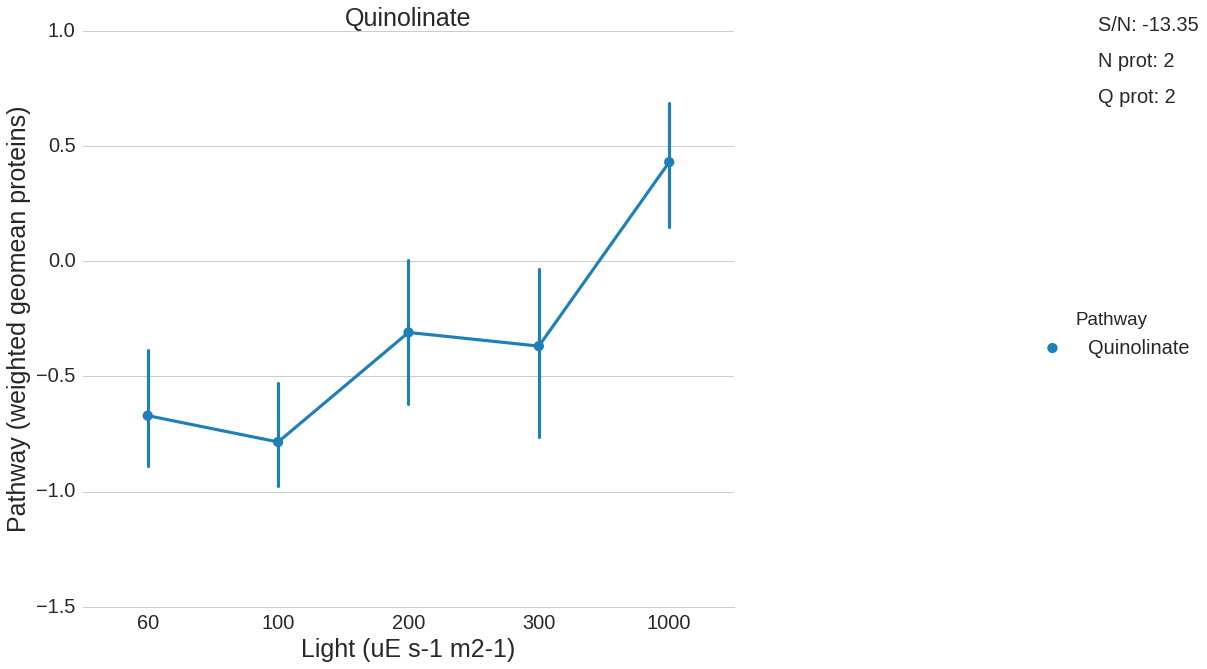

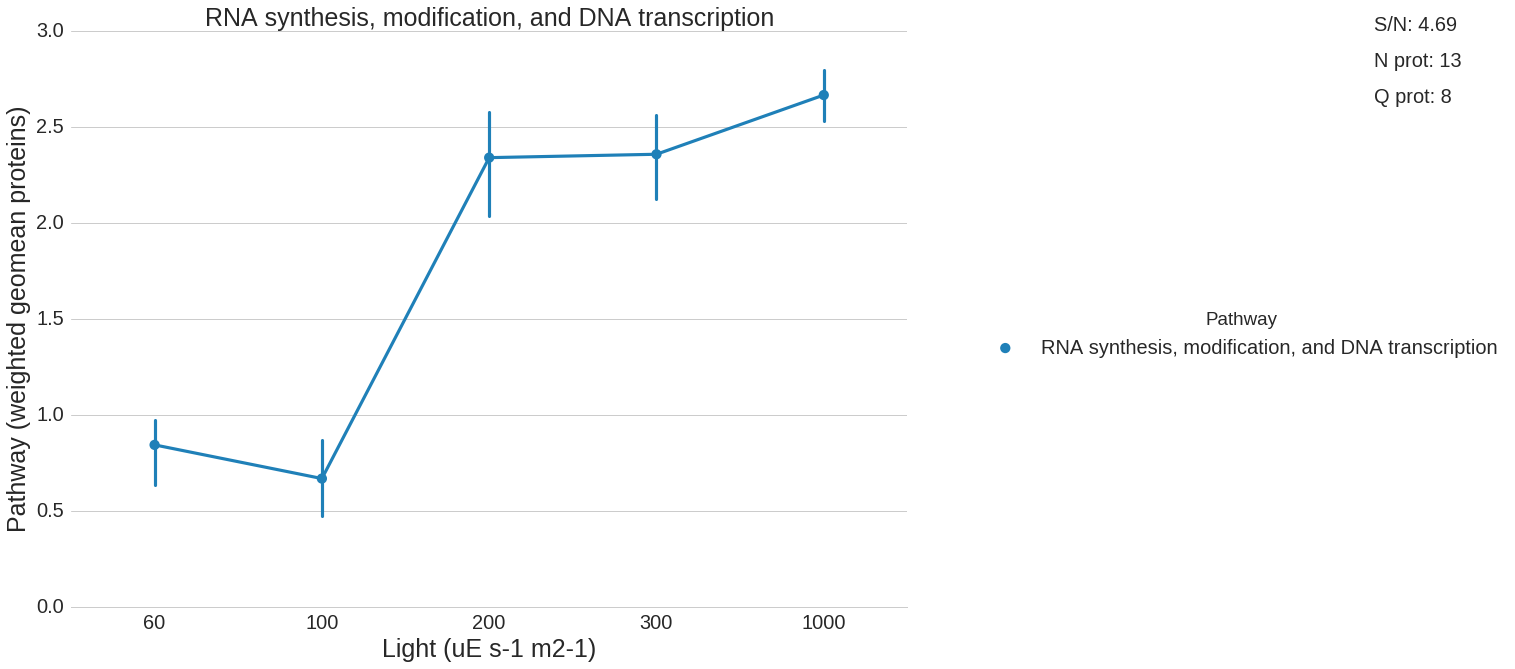

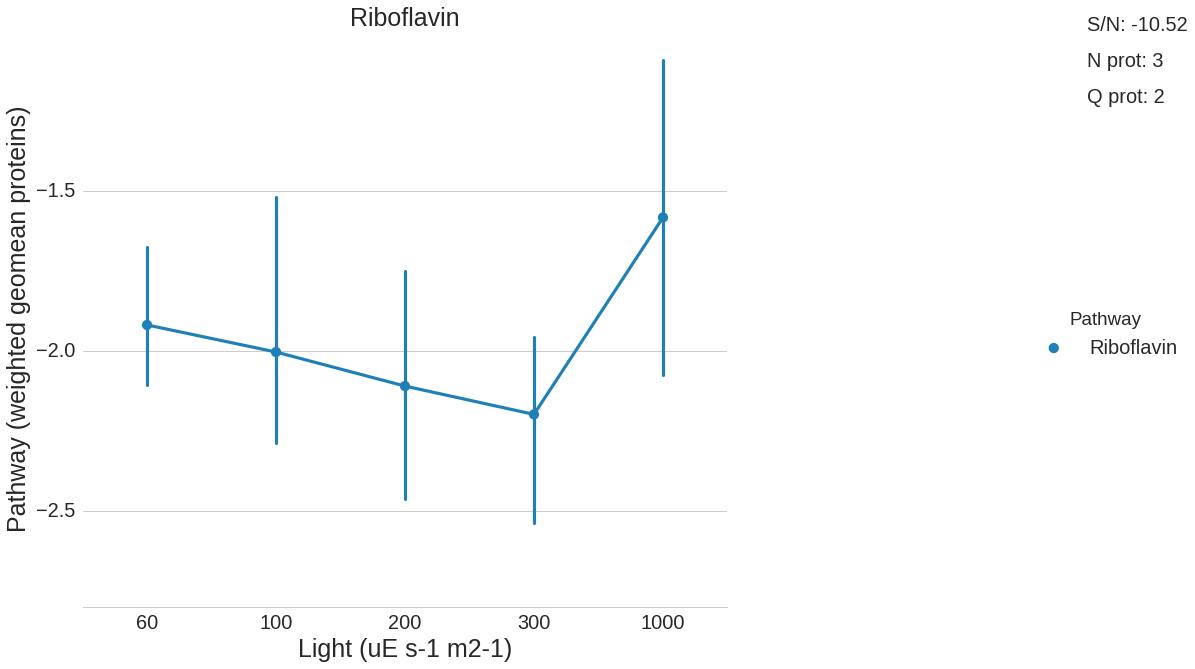

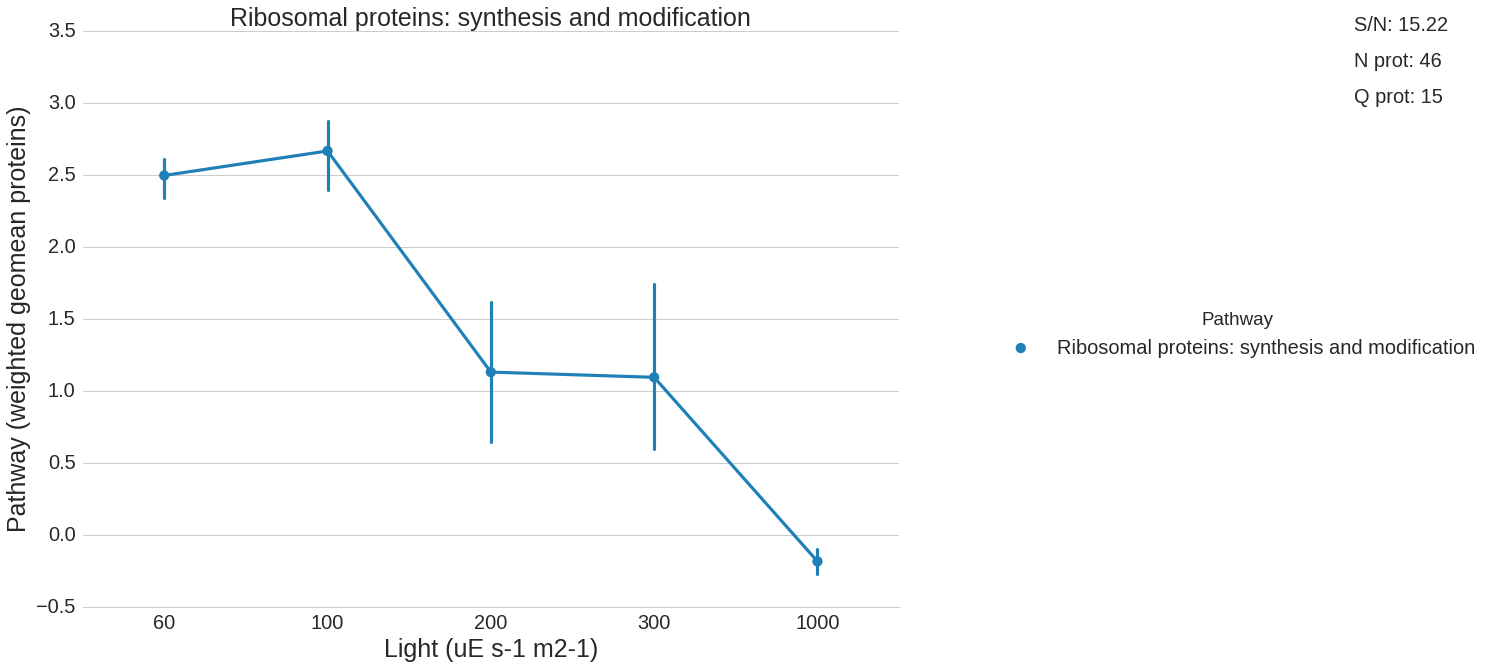

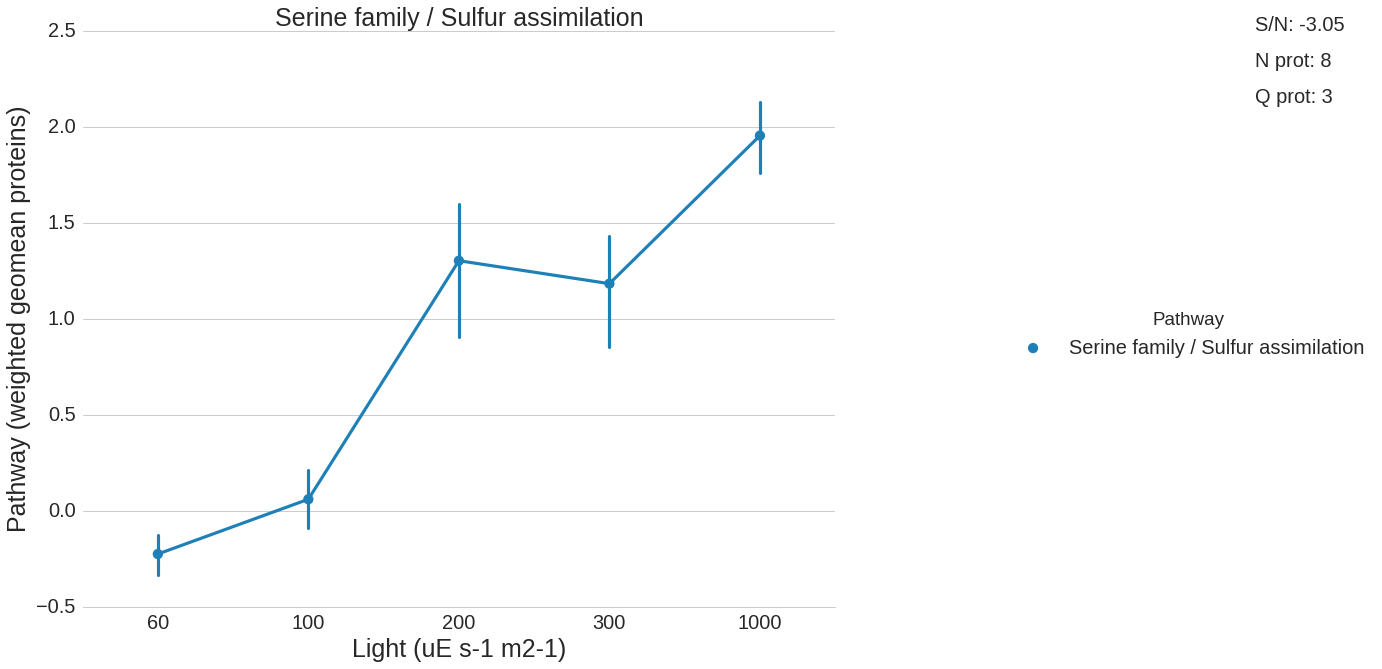

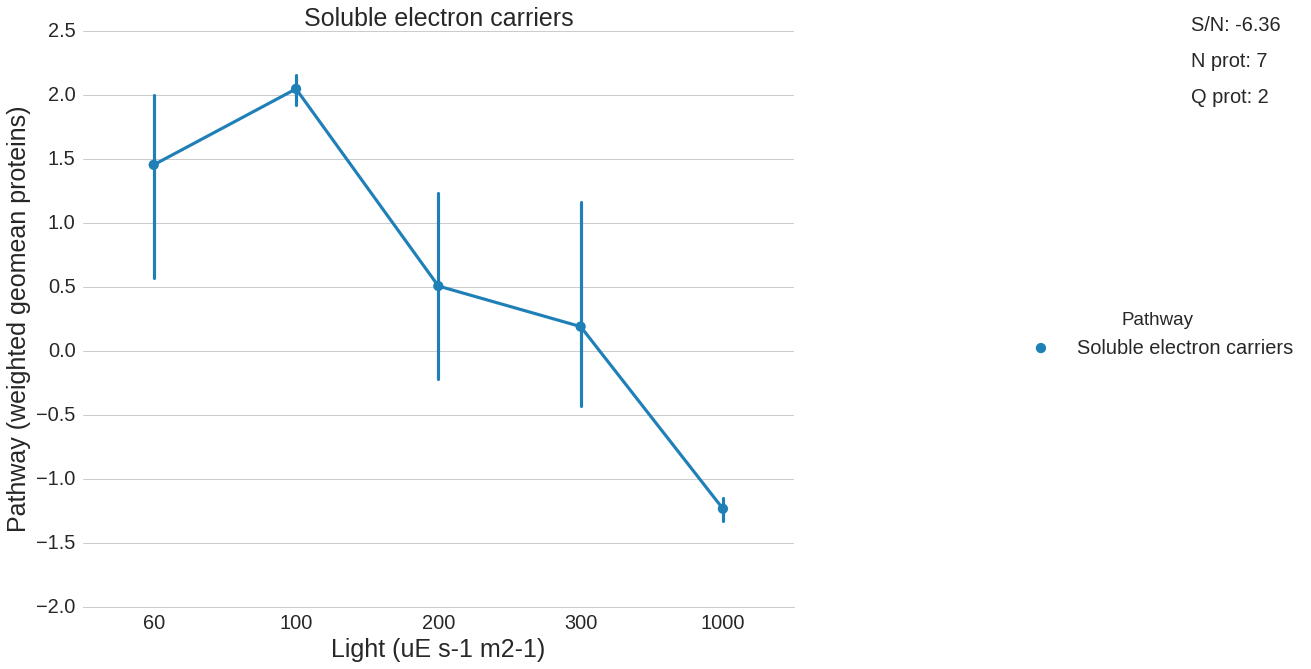

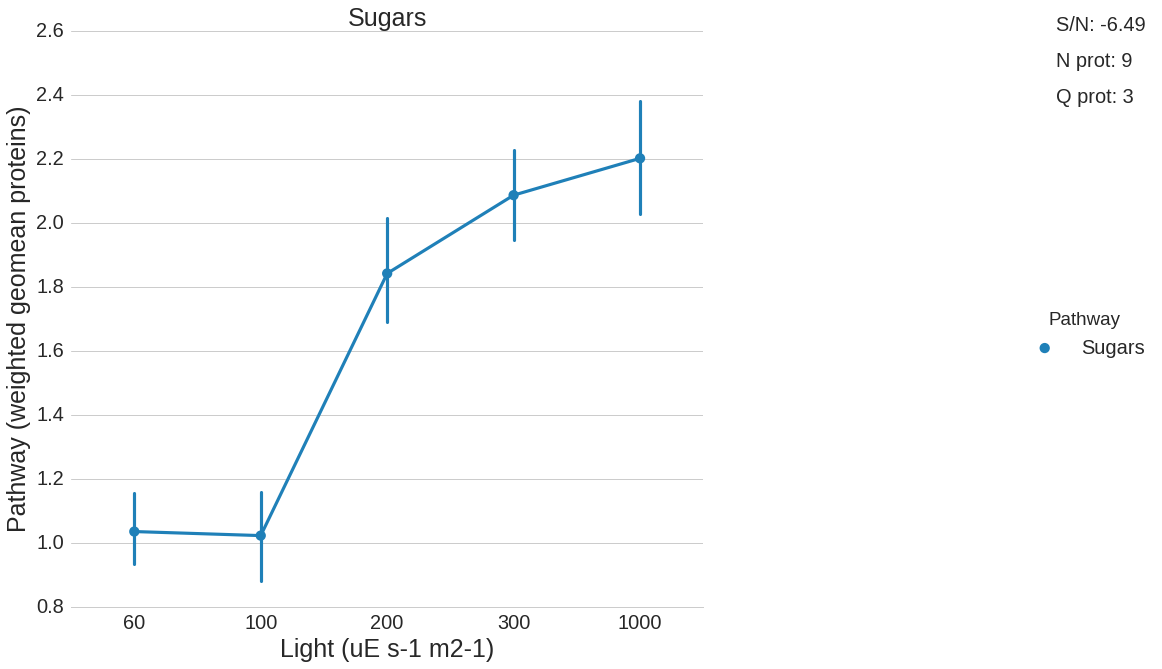

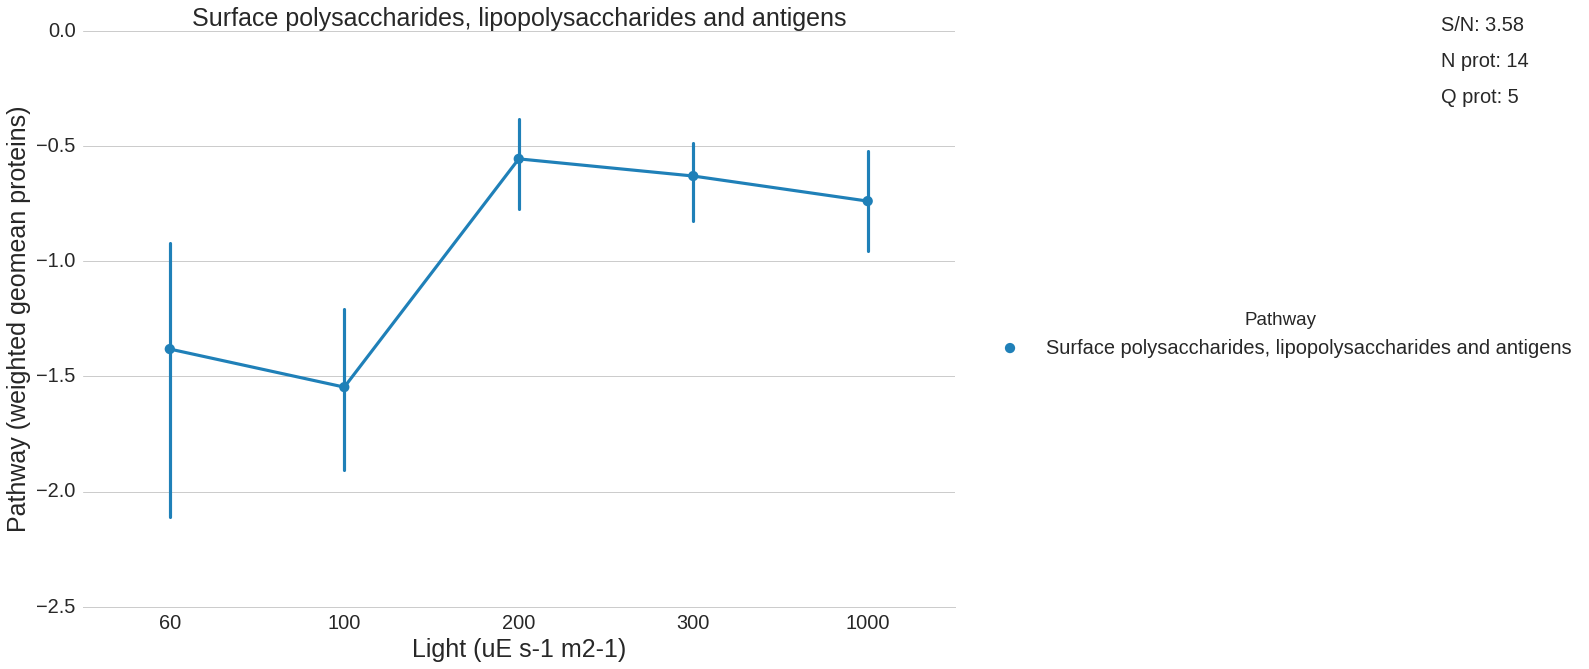

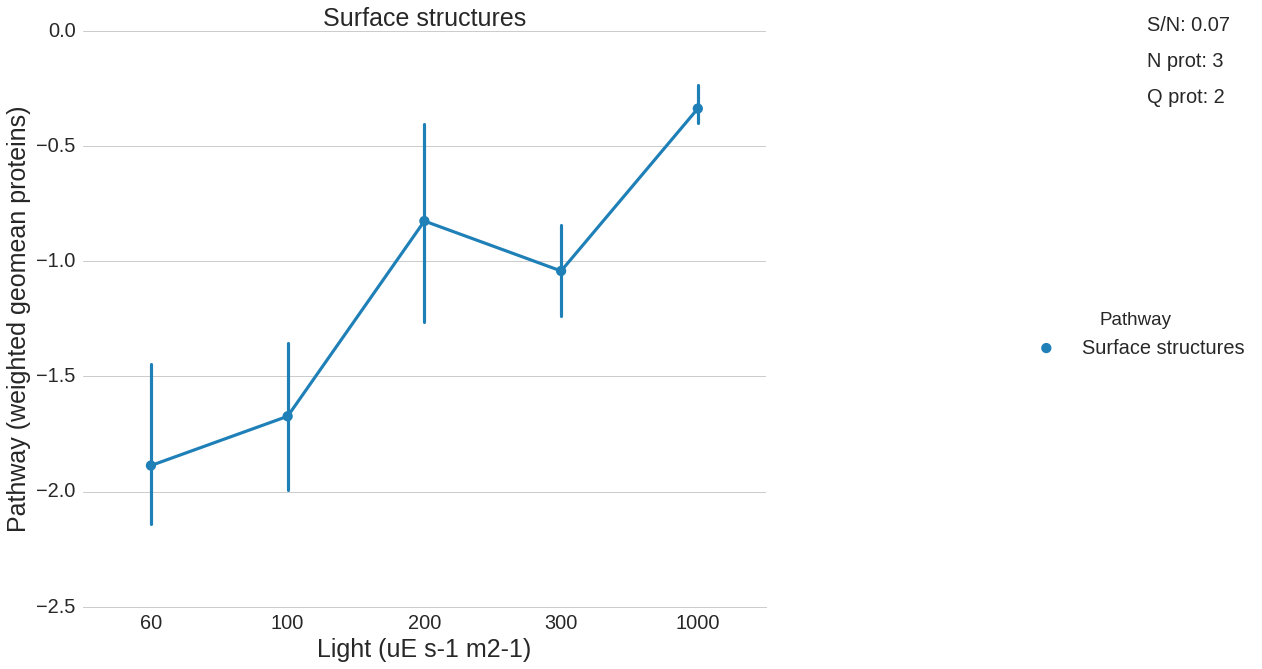

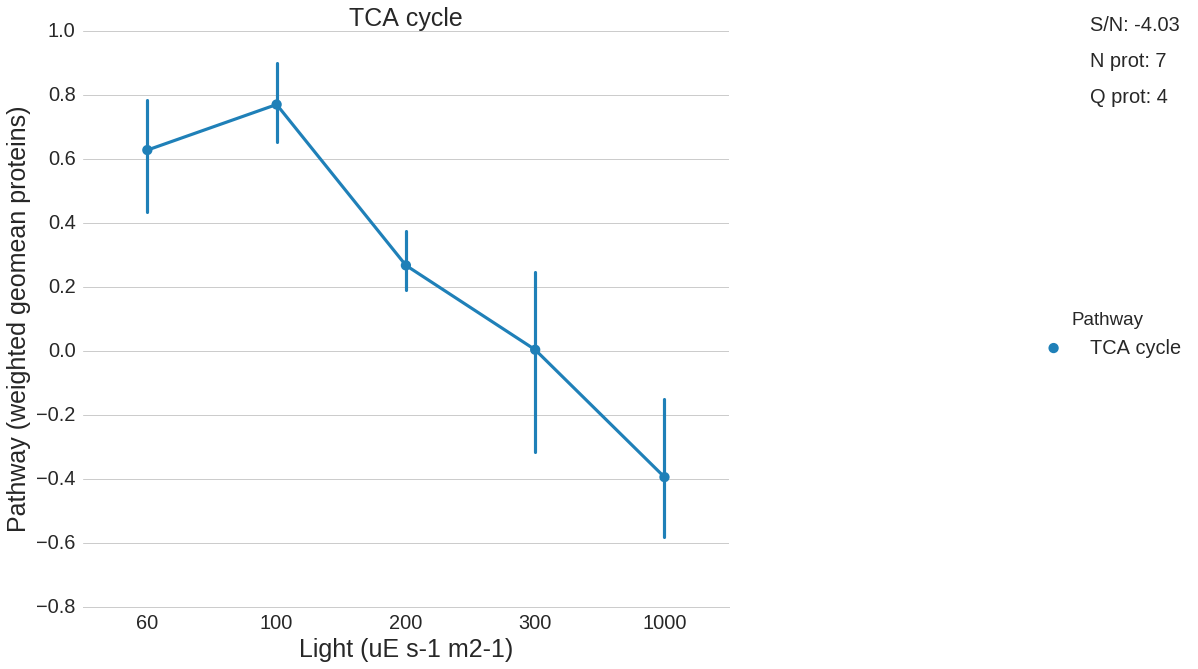

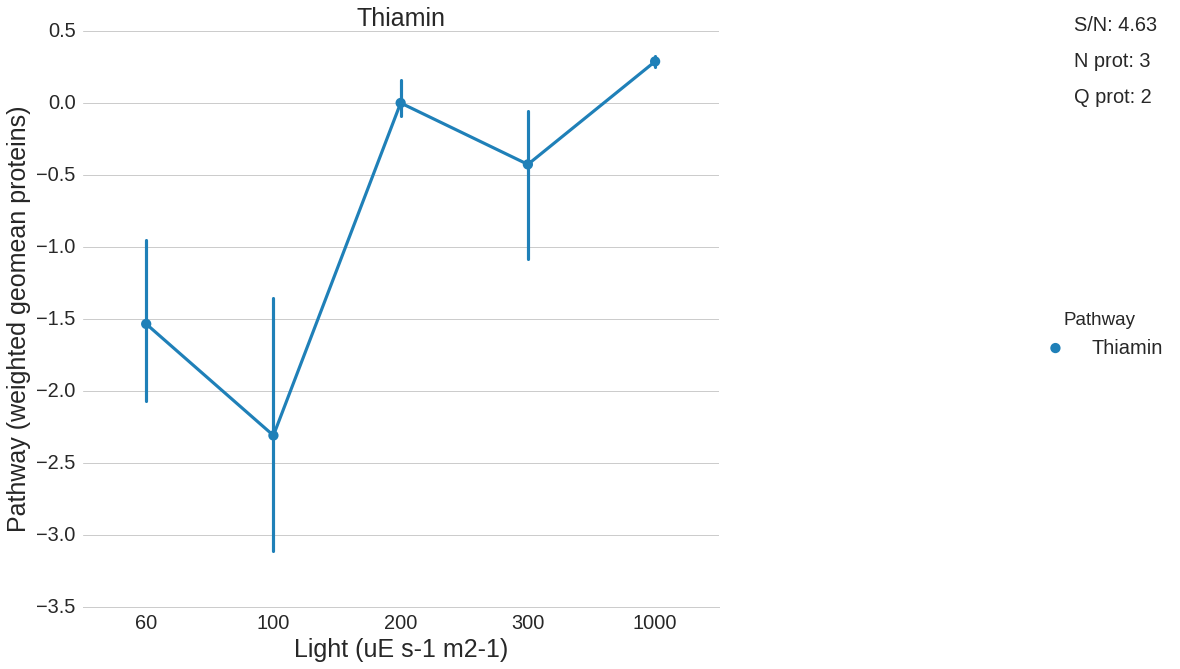

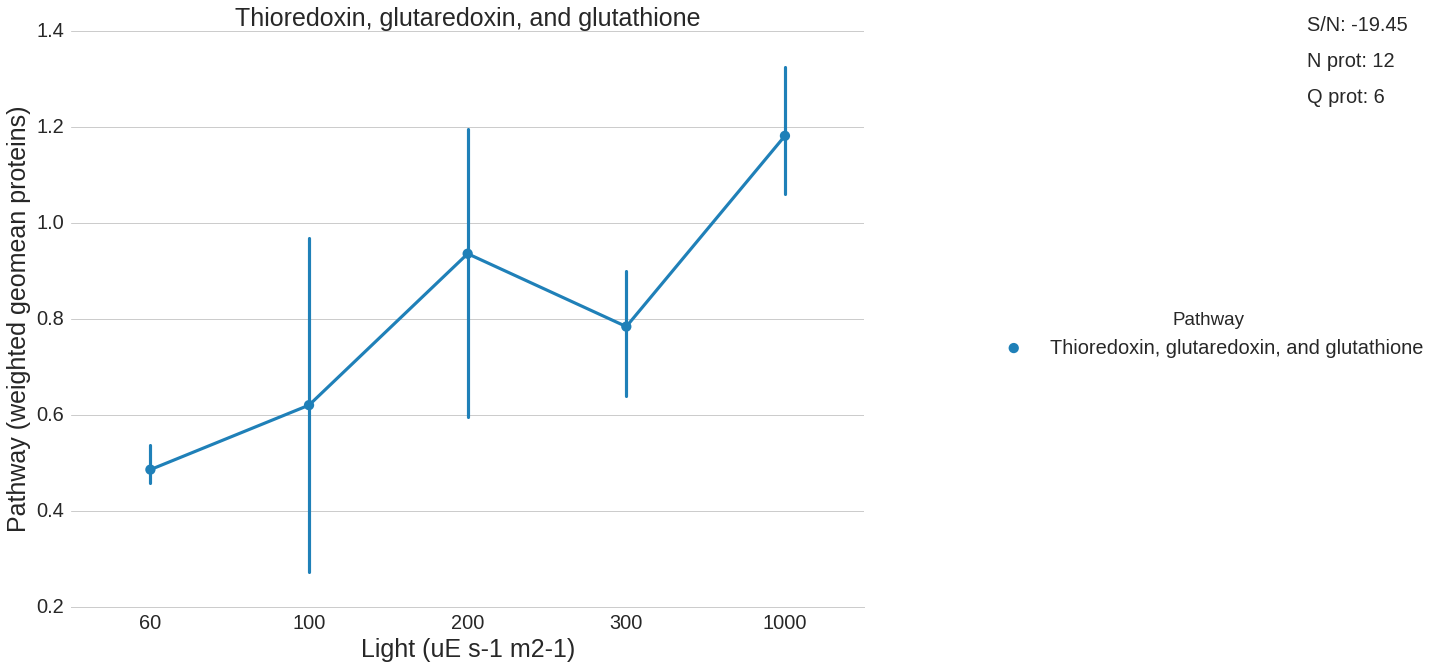

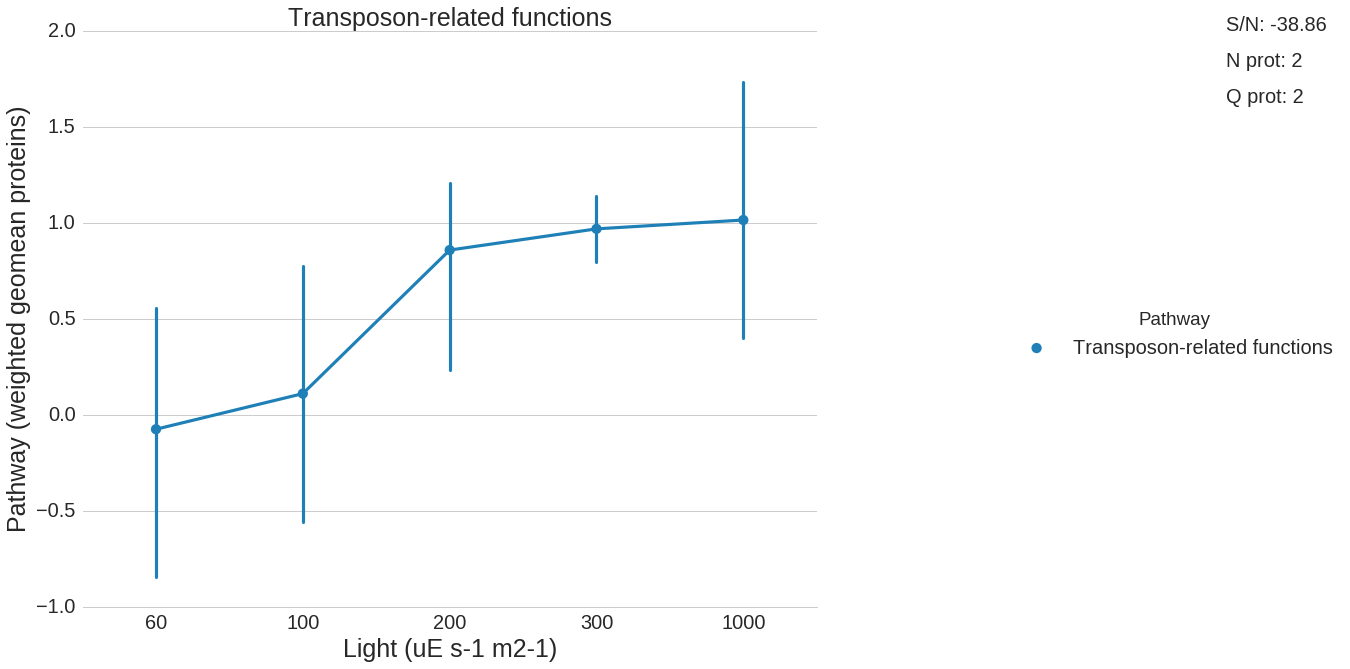

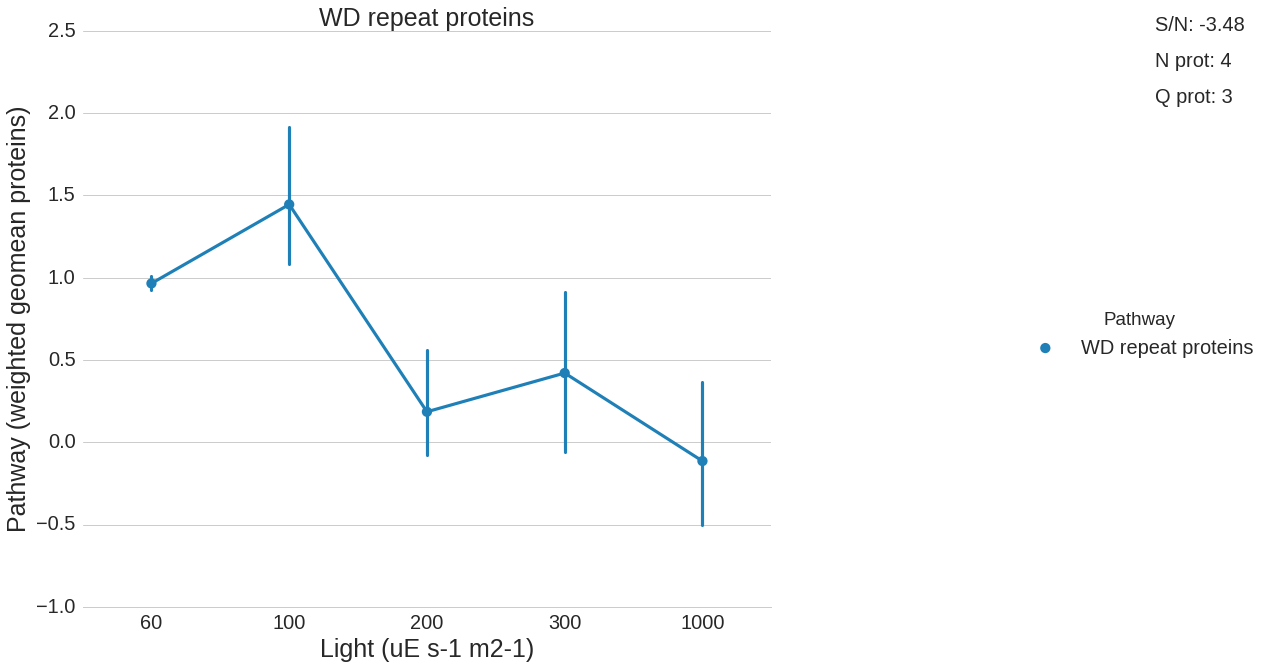

In [36]:
#Run factor analysis again for proteins grouped into second_category annotations:
out_file = "/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways_second_category.csv"

factor(df=df, pathways=sorted(pg.keys()), out_file=out_file) #writes diffacto_out_pathways_second_category.csv

#read diffacto_out_pathways_second_category.csv
data = pd.read_csv("/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_pathways_second_category.csv", sep="\t")

batch_sb_factorplot(pathways_df=data)
